In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import logging

# Setup basic logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Define the input file path (ensure this path is correct for your Build environment)
input_file_path = r"D:\SBT-JAPAN\Alpha GO\dataset-consolidation\data\processed\cars_modeling_input.csv" # Using double backslashes for Windows paths in Python strings

try:
    df = pd.read_csv(input_file_path)
    logging.info(f"Successfully loaded dataset from {input_file_path}. Shape: {df.shape}")

    # --- Initial Verification (as per MODEL_DEVELOPMENT_GUIDE.md Step 1.1) ---
    print("\n--- df.info() ---")
    df.info()
    print("\n--- df.describe(include='all') ---")
    print(df.describe(include='all'))

    print("\n--- df.isnull().sum() ---")
    print(df.isnull().sum().sort_values(ascending=False))

    print("\n--- df.head() ---")
    print(df.head())

    # Proactive Validation Checks (as per MODEL_DEVELOPMENT_GUIDE.md Step 1.1)
    logging.info("Performing proactive validation checks...")
    all_validations_passed = True # Flag to track overall validation status

    # Price column checks
    if 'price' in df.columns:
        logging.info("'price' column exists.")
        if not pd.api.types.is_numeric_dtype(df['price']):
            logging.error("DATA QUALITY ISSUE: 'price' column is not numeric.")
            all_validations_passed = False
        else:
            logging.info("'price' column is numeric.")
            if df['price'].notna().any():
                if not (df['price'][df['price'].notna()].min() > 0):
                    logging.error(f"DATA QUALITY ISSUE: Prices should be positive. Min non-NaN price found: {df['price'][df['price'].notna()].min()}.")
                    all_validations_passed = False
                else:
                    logging.info("Minimum price (for non-NaN values) is positive.")
            else:
                logging.warning("'price' column contains all NaN values. Min value check skipped.")
    else:
        logging.error("CRITICAL ERROR: Critical column 'price' is missing.")
        all_validations_passed = False

    # Year of manufacture column checks
    if 'year_of_manufacture' in df.columns:
        logging.info("'year_of_manufacture' column exists.")
        if not pd.api.types.is_numeric_dtype(df['year_of_manufacture']):
            logging.error("DATA QUALITY ISSUE: 'year_of_manufacture' column is not numeric.")
            all_validations_passed = False
        else:
            min_year_overall = df['year_of_manufacture'].min()
            if min_year_overall <= 1950:
                logging.error(f"DATA QUALITY ISSUE: Minimum 'year_of_manufacture' is {min_year_overall}, which is <= 1950. This indicates potential data errors that will need handling in subsequent steps.")
                all_validations_passed = False 
                # Log specific count for years between 1 and 1950 if 0 is the min
                if min_year_overall == 0:
                    very_old_years = df[(df['year_of_manufacture'] > 0) & (df['year_of_manufacture'] <= 1950)]['year_of_manufacture']
                    if not very_old_years.empty:
                        logging.warning(f"Found {len(very_old_years)} entries with 'year_of_manufacture' between 1 and 1950 (inclusive). Min such year: {very_old_years.min()}.")
            else: # All years are > 1950
                logging.info(f"Minimum 'year_of_manufacture' ({min_year_overall}) is > 1950 and looks reasonable.")

            # Max year check
            try:
                assert df['year_of_manufacture'].max() <= datetime.now().year + 1, f"Future manufacturing years found. Max year: {df['year_of_manufacture'].max()}"
                logging.info(f"Maximum 'year_of_manufacture' ({df['year_of_manufacture'].max()}) is valid.")
            except AssertionError as e_max_year:
                logging.error(f"DATA QUALITY ISSUE: {e_max_year}")
                all_validations_passed = False
    else:
        logging.warning("'year_of_manufacture' column not found. Year validation checks skipped.")
        # Not finding this column might be critical depending on planned features
        # all_validations_passed = False # Decide if this should fail validation

    if all_validations_passed:
        logging.info("Initial data validation checks completed. Some issues might have been logged as warnings/errors above - please review.")
    else:
        logging.error("CRITICAL DATA QUALITY ISSUES FOUND during initial validation checks. Please review logs carefully before proceeding.")

    # Establish Missing Value Thresholds (as per MODEL_DEVELOPMENT_GUIDE.md Step 1.1)
    logging.info("Checking missing value thresholds for critical features...")
    critical_features_for_nan_check = ['price', 'make_name', 'model_name', 'year_of_manufacture']
    max_nan_percentage = 5.0 # 5%
    for feature in critical_features_for_nan_check:
        if feature in df.columns:
            nan_percent = df[feature].isnull().sum() * 100 / len(df)
            logging.info(f"Feature '{feature}' has {nan_percent:.2f}% missing values.")
            if nan_percent > max_nan_percentage:
                logging.warning(f"WARNING: Feature '{feature}' has {nan_percent:.2f}% missing values, exceeding threshold of {max_nan_percentage}%. Consider investigation.")
        else:
            logging.warning(f"Critical feature '{feature}' for NaN check not found in DataFrame.")
    logging.info("Missing value threshold checks completed.")

    # --- Custom Data Cleaning (Added before formal EDA) ---
    logging.info("--- Starting Custom Data Cleaning --- ")

    # 1. Handle invalid 'year_of_manufacture' (e.g., values of 0)
    if 'year_of_manufacture' in df.columns and pd.api.types.is_numeric_dtype(df['year_of_manufacture']):
        invalid_year_count = df[df['year_of_manufacture'] == 0].shape[0]
        if invalid_year_count > 0:
            logging.warning(f"Found {invalid_year_count} entries with 'year_of_manufacture' == 0. Converting to NaN.")
            df['year_of_manufacture'] = df['year_of_manufacture'].replace(0, np.nan)
            logging.info(f"NaNs in 'year_of_manufacture' after converting 0s: {df['year_of_manufacture'].isnull().sum()}")
        else:
            logging.info("No 'year_of_manufacture' entries found with value 0.")

    # 2. Inspect 'currency_code'
    if 'currency_code' in df.columns:
        logging.info("\n--- Inspecting 'currency_code' --- ")
        print("Value counts for 'currency_code':")
        print(df['currency_code'].value_counts(dropna=False))
        print(f"Number of NaNs in 'currency_code': {df['currency_code'].isnull().sum()}")
    else:
        logging.warning("'currency_code' column not found for inspection.")

    # 3. Inspect 'mileage_unit'
    if 'mileage_unit' in df.columns:
        logging.info("\n--- Inspecting 'mileage_unit' --- ")
        print("Value counts for 'mileage_unit':")
        print(df['mileage_unit'].value_counts(dropna=False))
        print(f"Number of NaNs in 'mileage_unit': {df['mileage_unit'].isnull().sum()}")
    else:
        logging.warning("'mileage_unit' column not found for inspection.")

    # --- Apply Cleaning Based on Inspection ---
    logging.info("--- Applying Imputation Cleaning --- ")
    # Clean 'currency_code' - Impute NaNs with mode (USD)
    if 'currency_code' in df.columns:
        mode_currency = df['currency_code'].mode()[0]
        df['currency_code'] = df['currency_code'].fillna(mode_currency) # Avoid FutureWarning
        logging.info(f"Imputed NaNs in 'currency_code' with mode: '{mode_currency}'. NaN count now: {df['currency_code'].isnull().sum()}")
        if df['currency_code'].nunique() > 1:
            logging.warning(f"'currency_code' still contains multiple values: {df['currency_code'].unique().tolist()}. Price conversion might be needed later.")

    # Clean 'mileage_unit' - Impute NaNs with mode (km)
    if 'mileage_unit' in df.columns:
        mode_mileage_unit = df['mileage_unit'].mode()[0]
        df['mileage_unit'] = df['mileage_unit'].fillna(mode_mileage_unit) # Avoid FutureWarning
        logging.info(f"Imputed NaNs in 'mileage_unit' with mode: '{mode_mileage_unit}'. NaN count now: {df['mileage_unit'].isnull().sum()}")

    # Drop rows with 'Unknown_Placeholder' in both make_name and model_name
    if 'make_name' in df.columns and 'model_name' in df.columns:
        initial_rows = df.shape[0]
        condition_to_drop = (df['make_name'] == 'Unknown_Placeholder') & (df['model_name'] == 'Unknown_Placeholder')
        rows_to_drop_count = df[condition_to_drop].shape[0]
        if rows_to_drop_count > 0:
            df = df[~condition_to_drop].copy() # Use .copy() to ensure it's a new DataFrame
            logging.warning(f"Dropped {rows_to_drop_count} rows where both 'make_name' and 'model_name' were 'Unknown_Placeholder'. New shape: {df.shape}")
        else:
            logging.info("No rows found with 'Unknown_Placeholder' in both 'make_name' and 'model_name'.")
    else:
        logging.warning("'make_name' or 'model_name' not found, skipping drop for 'Unknown_Placeholder'.")

    logging.info("--- Custom Data Cleaning Initial Inspection Done --- ")
    logging.info("Next: Review output for currency_code and mileage_unit to decide cleaning strategy.")

except FileNotFoundError:
    logging.error(f"CRITICAL ERROR: The file was not found at {input_file_path}")
    logging.error("Please ensure the file 'cars_modeling_input.csv' exists in the 'Build/data/final/' directory.")
except Exception as e:
    logging.error(f"An error occurred during data loading: {e}")

# Further code for Step 1.1 and subsequent steps will be added below.


2025-05-19 14:15:13,296 - INFO - Successfully loaded dataset from D:\SBT-JAPAN\Alpha GO\dataset-consolidation\data\processed\cars_modeling_input.csv. Shape: (13467, 28)
2025-05-19 14:15:13,446 - INFO - Performing proactive validation checks...
2025-05-19 14:15:13,446 - INFO - 'price' column exists.
2025-05-19 14:15:13,453 - INFO - 'price' column is numeric.
2025-05-19 14:15:13,457 - INFO - Minimum price (for non-NaN values) is positive.
2025-05-19 14:15:13,459 - INFO - 'year_of_manufacture' column exists.
2025-05-19 14:15:13,462 - ERROR - DATA QUALITY ISSUE: Minimum 'year_of_manufacture' is 0, which is <= 1950. This indicates potential data errors that will need handling in subsequent steps.
2025-05-19 14:15:13,464 - INFO - Maximum 'year_of_manufacture' (2025) is valid.
2025-05-19 14:15:13,466 - ERROR - CRITICAL DATA QUALITY ISSUES FOUND during initial validation checks. Please review logs carefully before proceeding.
2025-05-19 14:15:13,466 - INFO - Checking missing value thresholds f


--- df.info() ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13467 entries, 0 to 13466
Data columns (total 28 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   source_specific_id              12941 non-null  object 
 1   make_name                       13467 non-null  object 
 2   model_name                      13467 non-null  object 
 3   year_of_manufacture             13467 non-null  int64  
 4   price                           12845 non-null  float64
 5   currency_code                   12847 non-null  object 
 6   mileage                         12915 non-null  float64
 7   mileage_unit                    13361 non-null  object 
 8   fuel_type                       13462 non-null  object 
 9   engine_size_cc                  13467 non-null  float64
 10  transmission                    13446 non-null  object 
 11  drive_type                      13306 non-null  object 
 12  body_type    

2025-05-19 14:15:13,488 - WARNING - Found 2308 entries with 'year_of_manufacture' == 0. Converting to NaN.
2025-05-19 14:15:13,493 - INFO - NaNs in 'year_of_manufacture' after converting 0s: 2308
2025-05-19 14:15:13,495 - INFO - 
--- Inspecting 'currency_code' --- 
2025-05-19 14:15:13,497 - INFO - 
--- Inspecting 'mileage_unit' --- 
2025-05-19 14:15:13,500 - INFO - --- Applying Imputation Cleaning --- 
2025-05-19 14:15:13,505 - INFO - Imputed NaNs in 'currency_code' with mode: 'USD'. NaN count now: 0
2025-05-19 14:15:13,510 - WARNING - 'currency_code' still contains multiple values: ['KSh', 'USD']. Price conversion might be needed later.
2025-05-19 14:15:13,513 - INFO - Imputed NaNs in 'mileage_unit' with mode: 'km'. NaN count now: 0
2025-05-19 14:15:13,533 - WARNING - Dropped 398 rows where both 'make_name' and 'model_name' were 'Unknown_Placeholder'. New shape: (13069, 28)
2025-05-19 14:15:13,533 - INFO - --- Custom Data Cleaning Initial Inspection Done --- 
2025-05-19 14:15:13,537 -

Value counts for 'currency_code':
currency_code
USD    9624
KSh    3223
NaN     620
Name: count, dtype: int64
Number of NaNs in 'currency_code': 620
Value counts for 'mileage_unit':
mileage_unit
km     13361
NaN      106
Name: count, dtype: int64
Number of NaNs in 'mileage_unit': 106


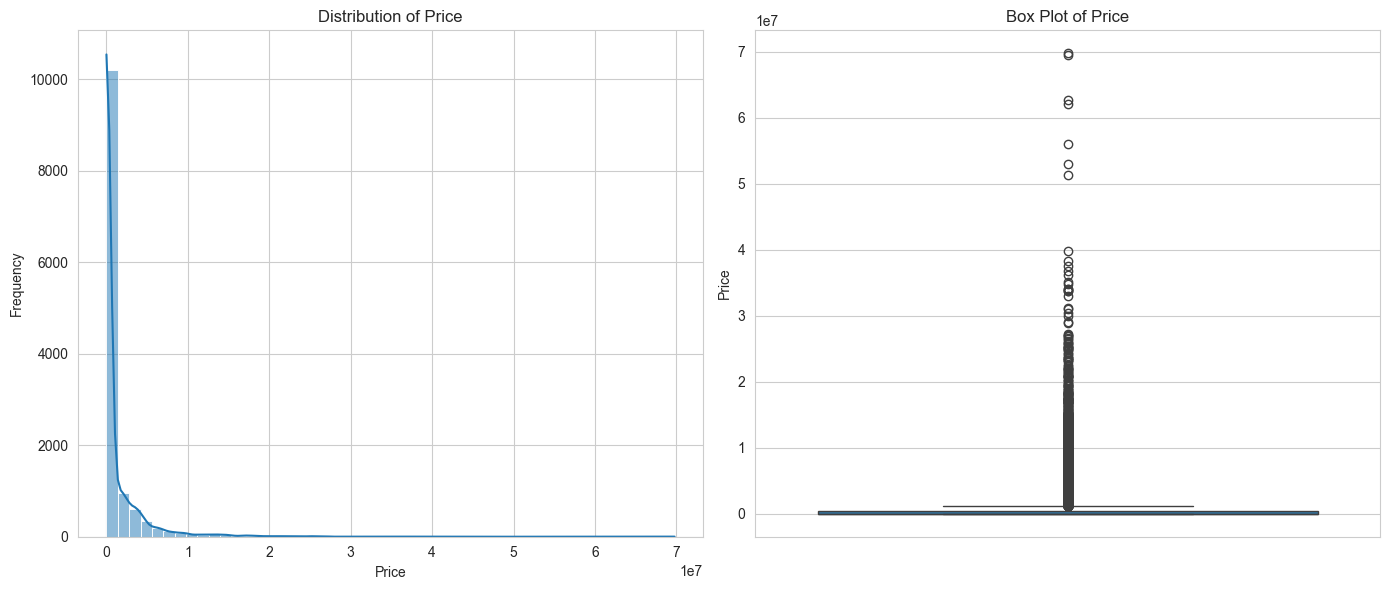


--- Descriptive Statistics for Price ---
count    1.284300e+04
mean     1.177900e+06
std      3.388536e+06
min      6.800000e+02
25%      2.680000e+03
50%      9.050000e+03
75%      4.502045e+05
max      6.978300e+07
Name: price, dtype: float64

Skewness of price: 6.863279813311371


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # For potential log transformation

# Assuming 'df' is your DataFrame loaded and preprocessed from the previous steps

# Set plot style
sns.set_style('whitegrid')

# 1. Distribution of 'price'
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['price'], kde=True, bins=50)
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['price'])
plt.title('Box Plot of Price')
plt.ylabel('Price')

plt.tight_layout()
plt.show()

# 2. Descriptive statistics for 'price'
print("\n--- Descriptive Statistics for Price ---")
print(df['price'].describe())

# 3. Skewness check
print(f"\nSkewness of price: {df['price'].skew()}")



The "Distribution of Price" histogram and the "Box Plot of Price" clearly show that the `price` variable is **highly right-skewed**.
*   Most of the car prices are concentrated at the lower end.
*   There's a long tail towards the higher prices, with several outliers indicated in the box plot (the circles above the main box).

To confirm the extent of the skewness and decide on transformation, could you please also share the output of:
1.  `df['price'].describe()`
2.  The skewness value: `print(f"\nSkewness of price: {df['price'].skew()}")`
Perfect! The descriptive statistics and the skewness value confirm our visual interpretation:

*   **`df['price'].describe()`**:
    *   The `mean` (1.17M) is significantly higher than the `median` (50% percentile, which is 9050). This is a classic indicator of right-skewness.
    *   The `max` value (69.7M) is very far from the `75%` percentile (450k), further highlighting the presence of high-value outliers and the long tail.
*   **`Skewness of price: 6.863279813311371`**:
    *   A skewness of approximately **6.86** is very high (a common rule of thumb is that values between -0.5 and 0.5 are fairly symmetrical, -1 to -0.5 or 0.5 to 1 are moderately skewed, and anything beyond -1 or 1 is highly skewed).

Given this strong right-skewness, **applying a log transformation to the `price` column is highly recommended.** This will likely:
1.  Make the distribution of the target variable more symmetrical (closer to a normal distribution).
2.  Reduce the influence of outliers.
3.  Help in satisfying assumptions of linear models if we choose to use them later.

Let's add a new cell to your notebook to:
1.  Create a new column, for example, `price_log`.
2.  Visualize the distribution of this new `price_log` column (histogram and box plot).
3.  Check its new skewness value.



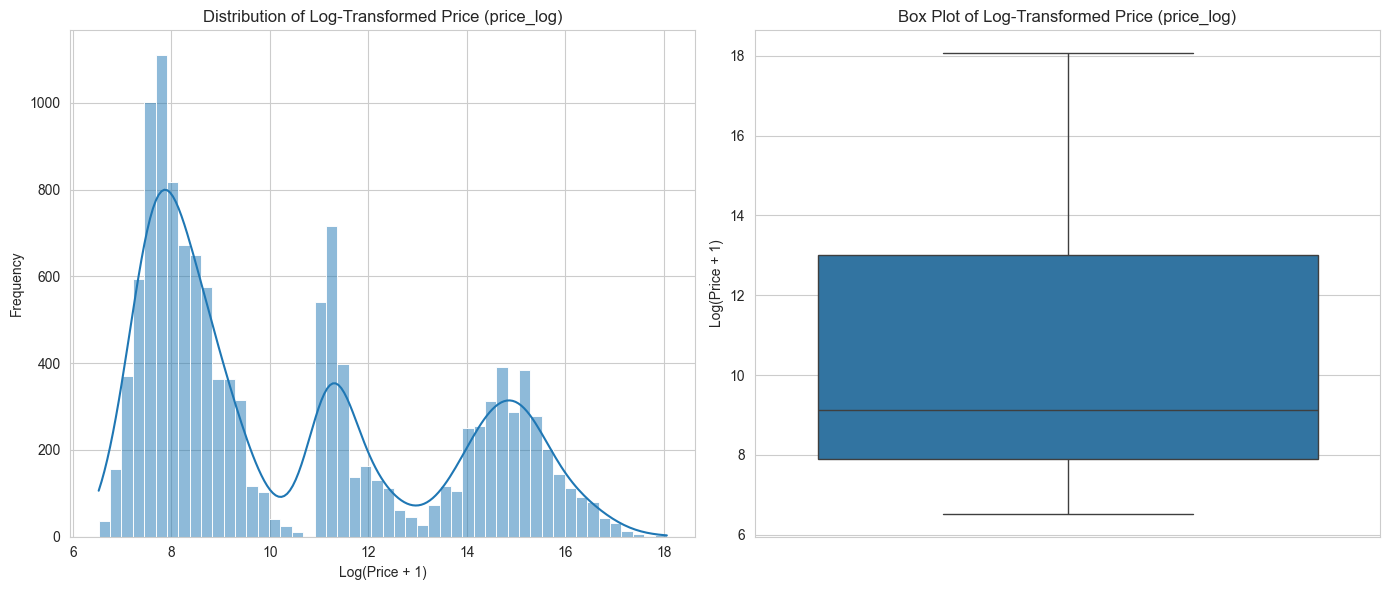


--- Descriptive Statistics for Log-Transformed Price (price_log) ---
count    12843.000000
mean        10.448678
std          2.967675
min          6.523562
25%          7.893945
50%          9.110631
75%         13.017459
max         18.060901
Name: price_log, dtype: float64

Skewness of price_log: 0.6372792373225632


In [3]:
# 4. Log transform 'price' to handle skewness
# We use np.log1p to handle potential zero values if any (though our min price is > 0)
# and to have a more stable transformation for values close to zero.
df['price_log'] = np.log1p(df['price'])

# 5. Visualize the distribution of 'price_log'
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['price_log'], kde=True, bins=50)
plt.title('Distribution of Log-Transformed Price (price_log)')
plt.xlabel('Log(Price + 1)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['price_log'])
plt.title('Box Plot of Log-Transformed Price (price_log)')
plt.ylabel('Log(Price + 1)')

plt.tight_layout()
plt.show()

# 6. Descriptive statistics for 'price_log'
print("\n--- Descriptive Statistics for Log-Transformed Price (price_log) ---")
print(df['price_log'].describe())

# 7. Skewness check for 'price_log'
print(f"\nSkewness of price_log: {df['price_log'].skew()}")

That's a significant improvement!

Let's break down the results for `price_log`:

*   **Visuals (Histogram and Box Plot):**
    *   The "Distribution of Log-Transformed Price" histogram now looks much less skewed. While it's not perfectly normal (it appears somewhat bimodal or multimodal, which could be due to distinct price groups related to currency or car types), the extreme tail is gone.
    *   The "Box Plot of Log-Transformed Price" is much more compact, and the outliers are far less extreme than before.
*   **Descriptive Statistics for `price_log`:**
    *   The `mean` (10.45) and `median` (50% percentile, 9.11) are now much closer than they were for the original `price`. This indicates a more symmetrical distribution.
*   **`Skewness of price_log: 0.6372792373225632`**:
    *   The skewness has drastically reduced from **6.86** to approximately **0.64**. This is now in the range of "moderately skewed" and is a much better starting point for most modeling algorithms.

**Conclusion for Target Variable Analysis:**

The log transformation (`np.log1p`) has successfully addressed the severe right-skewness of the `price` variable. We should proceed with `price_log` as our target variable for modeling. The slight remaining skewness and the multimodal appearance are things we can keep in mind, but it's a far better distribution to work with.

This also highlights the importance of handling the two currencies (`KSh` and `USD`) that we noted earlier. The distinct peaks in the `price_log` distribution might be related to these different currency scales. When we convert all prices to a single currency (e.g., KSh) during feature engineering, this `price_log` distribution might become even smoother and more unimodal.

**Next Steps in EDA:**

We can now move on to analyzing other features. Based on the typical EDA workflow, we could look at:

1.  **Numeric Features:**
    *   Distributions (histograms, box plots).
    *   Relationships with `price_log` (scatter plots).
    *   Correlations (heatmap).
    Key numeric features to look at would be `year_of_manufacture`, `mileage`, `engine_size_cc`, `horse_power`, `torque`, `acceleration`, `urban_consumption`, `highway_consumption`, `seats`.
2.  **Categorical Features:**
    *   Value counts (bar plots).
    *   Relationship with `price_log` (box plots per category).
    Key categorical features include `make_name`, `model_name`, `fuel_type`, `transmission`, `drive_type`, `body_type`, `condition`, `source_dataset`, `usage_type`.

Which group of features would you like to explore next? Numeric or categorical? Or perhaps a specific feature you're particularly interested in?


## Just a mark to the main project


You've raised a crucial point, and it's excellent practice to ensure our EDA efforts remain tightly aligned with the core objectives and scope defined in your `project.txt`. The goal is indeed to explore features that are most likely to be significant predictors for your used car price model in the Kenyan context.

I've reviewed your `project.txt` document again, focusing on the features repeatedly mentioned as important for price prediction. Here's a consolidated list of those key features, which we should prioritize in our EDA:

**Key Features Highlighted in `project.txt`:**

*   **Numeric:**
    *   `year_of_manufacture` (from which we'll derive `car_age`)
    *   `mileage`
    *   `engine_size_cc`
    *   `horse_power`
    *   `torque`
    *   `acceleration`
    *   `seats`
*   **Categorical:**
    *   `make_name` (Brand)
    *   `model_name`
    *   `fuel_type`
    *   `transmission`
    *   `drive_type`
    *   `condition`
    *   `body_type`
    *   `usage_type` (corresponds to "Source - Kenyan/Foreign used")

**Alignment with Current Dataset and EDA Plan:**

Fortunately, these features are all present in your current `cars_modeling_input.csv` dataset, and they are precisely the features we would naturally focus on in a comprehensive EDA for price prediction. Our current plan to analyze numeric and then categorical features will directly cover this list.

**No Need to Update `PROJECT_NOTES.md` for this Specific Request:**

Your `PROJECT_NOTES.md` already captures the necessary cleaning and imputation tasks for these features (like handling NaNs in `mileage`, `fuel_type`, `transmission`, etc., and converting `year_of_manufacture` 0s) under the "Further Data Cleaning & Imputation for Step 1.4" section. The current request is about *focusing the EDA exploration*, which we are aligned on.

**Moving Forward with Focused EDA:**

We can now proceed with the EDA, keeping this prioritized list in mind. Let's start with the **numeric features** from your project's key list.

For each of these numeric features (`year_of_manufacture`, `mileage`, `engine_size_cc`, `horse_power`, `torque`, `acceleration`, `seats`), we'll typically:
1.  Examine their distributions (histograms, box plots).
2.  Look at their relationship with our target variable, `price_log` (scatter plots are excellent for this).
3.  Later, we'll compute a correlation matrix to see their linear relationships with `price_log` and with each other.

Shall we begin by analyzing the distribution and relationship with `price_log` for `year_of_manufacture`? This is a fundamental feature for car price prediction.


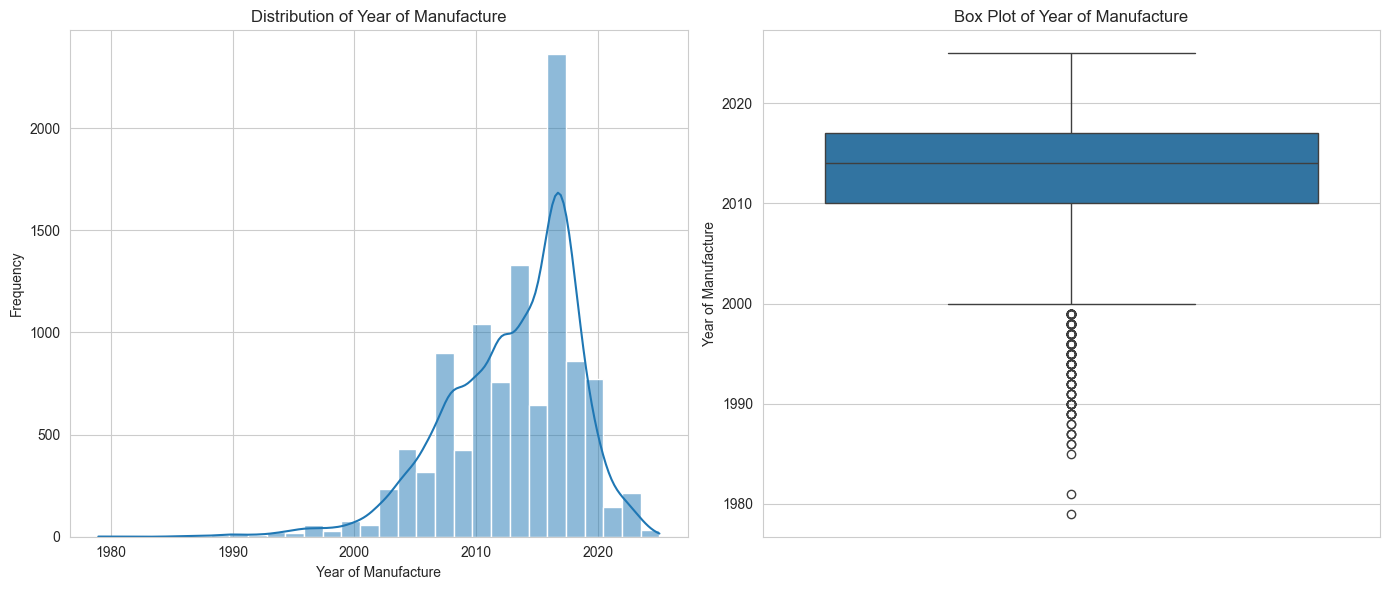


--- Descriptive Statistics for Year of Manufacture ---
count    10764.000000
mean      2013.013378
std          5.384070
min       1979.000000
25%       2010.000000
50%       2014.000000
75%       2017.000000
max       2025.000000
Name: year_of_manufacture, dtype: float64
Skewness of Year of Manufacture: -0.9334712281451886
NaNs in Year of Manufacture: 2305


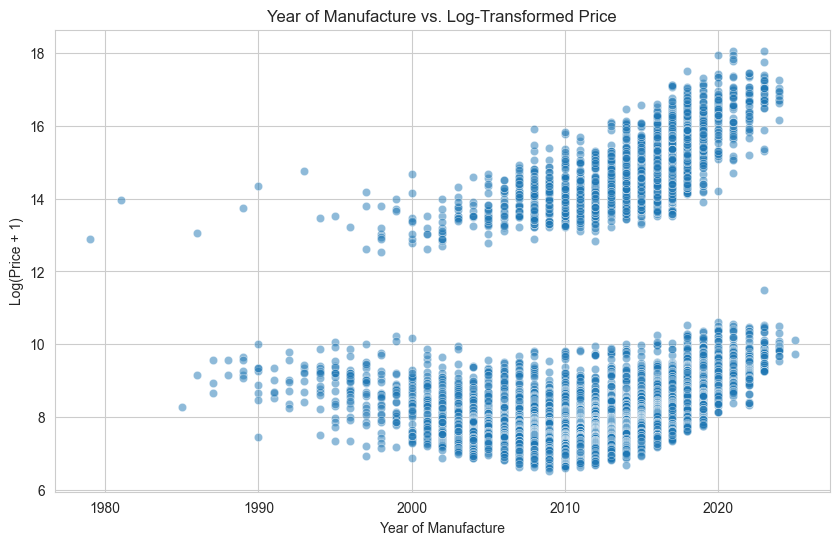

In [4]:
# --- EDA for Numeric Feature: year_of_manufacture ---

# 1. Distribution of 'year_of_manufacture'
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
# We need to handle NaNs if any before plotting, especially if we converted 0s to NaNs earlier
sns.histplot(df['year_of_manufacture'].dropna(), kde=True, bins=30) # Using dropna() for safety
plt.title('Distribution of Year of Manufacture')
plt.xlabel('Year of Manufacture')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['year_of_manufacture'])
plt.title('Box Plot of Year of Manufacture')
plt.ylabel('Year of Manufacture')

plt.tight_layout()
plt.show()

# 2. Descriptive statistics for 'year_of_manufacture'
print("\n--- Descriptive Statistics for Year of Manufacture ---")
print(df['year_of_manufacture'].describe())
print(f"Skewness of Year of Manufacture: {df['year_of_manufacture'].skew()}")
print(f"NaNs in Year of Manufacture: {df['year_of_manufacture'].isnull().sum()}")


# 3. Relationship with 'price_log'
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['year_of_manufacture'], y=df['price_log'], alpha=0.5)
plt.title('Year of Manufacture vs. Log-Transformed Price')
plt.xlabel('Year of Manufacture')
plt.ylabel('Log(Price + 1)')
plt.grid(True)
plt.show()

Thanks for sharing the output! This gives us good insights into the `year_of_manufacture` feature.

**Observations for `year_of_manufacture`:**

1.  **Distribution (Histogram & Box Plot):**
    *   The histogram shows the distribution is left-skewed, with a concentration of cars manufactured in more recent years (roughly from 2010 onwards). This is common in used car markets.
    *   The box plot also shows this left skew, with outliers representing older cars (some going back to around 1980).
    *   The `max` year is 2025, which we noted earlier as potentially problematic (cars not yet released or very new releases). We should keep this in mind for feature engineering (e.g., when creating `car_age`).

2.  **Descriptive Statistics & Skewness:**
    *   `count: 10764.0`: This confirms the number of non-NaN entries after we converted the 2305 zero-year entries to NaN.
    *   `mean: 2013.01`, `median (50%): 2014.0`: The mean being slightly less than the median is consistent with left-skewness.
    *   `min: 1979.0`, `max: 2025.0`: Defines the range of manufacturing years.
    *   `Skewness: -0.933`: This value quantitatively confirms the moderate left-skewness observed in the histogram.
    *   `NaNs: 2305`: This matches the number of 'year 0' entries we converted earlier, which is good. We'll need to decide how to handle these NaNs before modeling (e.g., imputation or creating a `car_age` feature that can handle NaNs in year).

3.  **Relationship with `price_log` (Scatter Plot):**
    *   There's a clear positive trend: **as the `year_of_manufacture` increases (newer cars), the `price_log` tends to increase.** This is an expected and strong relationship.
    *   The scatter plot also shows those distinct bands of data points, which we previously hypothesized might be due to the different currencies (`KSh` vs. `USD`). The trend is visible within both bands.
    *   The variance in `price_log` seems to increase for more recent years.

**Implications & Next Steps:**

*   `year_of_manufacture` is clearly an important feature for predicting price.
*   We will definitely want to create a `car_age` feature from this during feature engineering (Step 1.4). When doing so, we'll need to handle:
    *   The NaNs in `year_of_manufacture`.
    *   The fact that the current year will change, so `car_age` should be calculated relative to a reference year (e.g., the year the data was collected or a fixed recent year).
    *   Years like 2025 (future years) might need capping or special handling to avoid negative or zero ages.
*   The left-skewness of `year_of_manufacture` itself isn't usually a major problem for tree-based models (like Random Forest, Gradient Boosting), but it's good to be aware of.

**Next Numeric Feature:**

Shall we move on to analyzing `mileage` next? This is another critical feature for used car pricing.


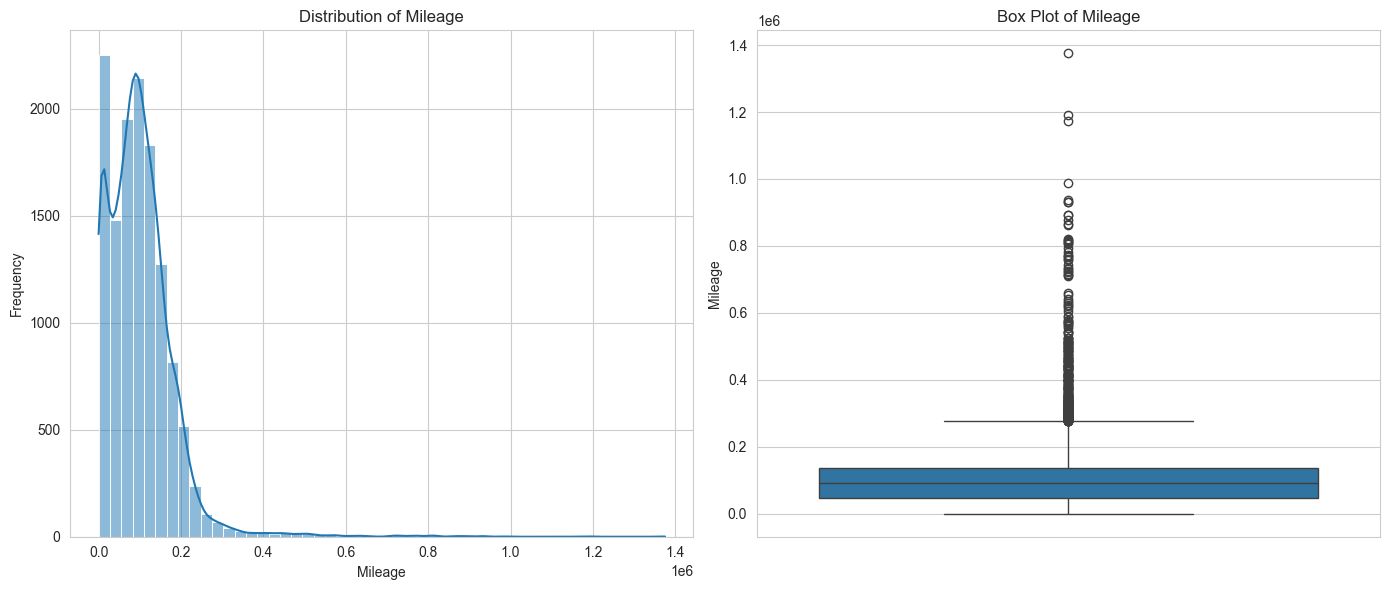


--- Descriptive Statistics for Mileage ---
count    1.290000e+04
mean     1.006307e+05
std      8.332841e+04
min      0.000000e+00
25%      4.600000e+04
50%      9.200000e+04
75%      1.380000e+05
max      1.375000e+06
Name: mileage, dtype: float64
Skewness of Mileage: 3.1485733442458974
NaNs in Mileage: 169


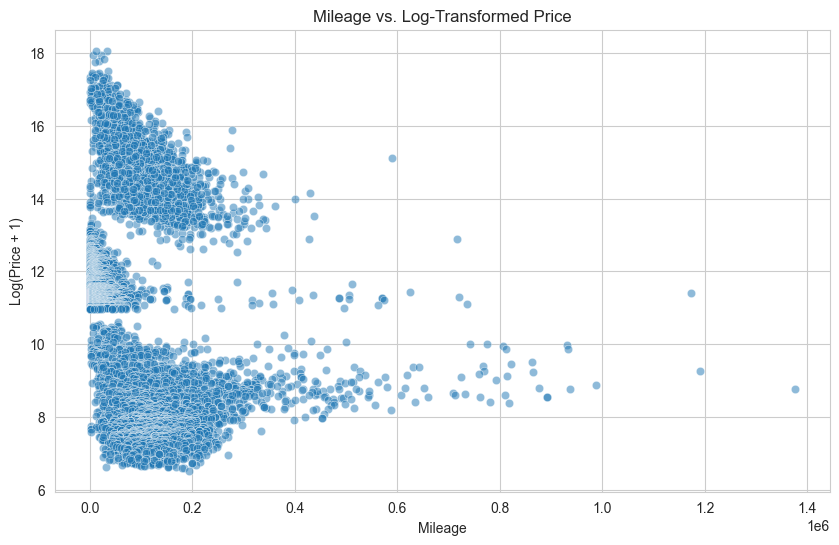

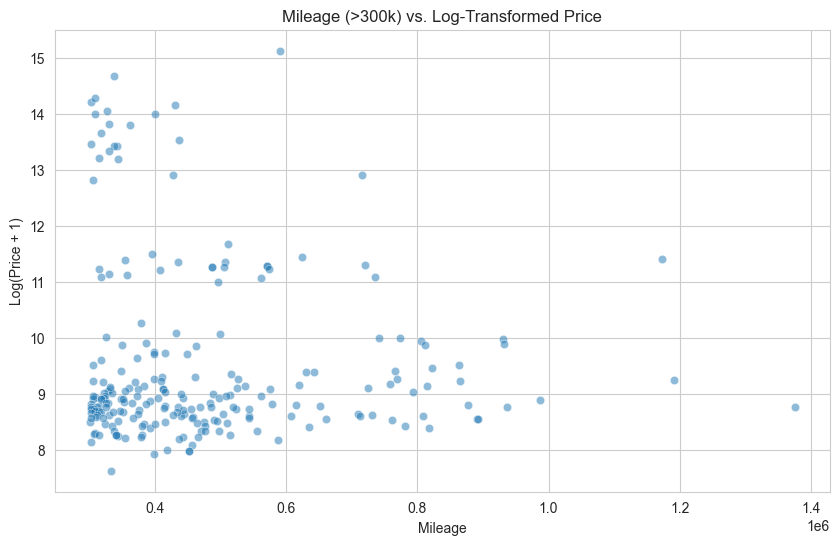

In [5]:
# --- EDA for Numeric Feature: mileage ---

# 1. Distribution of 'mileage'
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
# Handle NaNs before plotting for safety
sns.histplot(df['mileage'].dropna(), kde=True, bins=50)
plt.title('Distribution of Mileage')
plt.xlabel('Mileage')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['mileage'])
plt.title('Box Plot of Mileage')
plt.ylabel('Mileage')

plt.tight_layout()
plt.show()

# 2. Descriptive statistics for 'mileage'
print("\n--- Descriptive Statistics for Mileage ---")
print(df['mileage'].describe())
print(f"Skewness of Mileage: {df['mileage'].skew()}")
print(f"NaNs in Mileage: {df['mileage'].isnull().sum()}") # We know there are some NaNs

# 3. Relationship with 'price_log'
plt.figure(figsize=(10, 6))
# Use a sample for scatter plot if mileage has too many points and makes it slow/dense
# For now, let's plot all, but keep sampling in mind if it's too dense.
sns.scatterplot(x=df['mileage'], y=df['price_log'], alpha=0.5)
plt.title('Mileage vs. Log-Transformed Price')
plt.xlabel('Mileage')
plt.ylabel('Log(Price + 1)')
plt.grid(True)
plt.show()

# It might also be interesting to see mileage vs log_price for cars with very high mileage
# to see if the trend continues or flattens.
# For example, cars with mileage > 300,000 km
df_high_mileage = df[df['mileage'] > 300000]
if not df_high_mileage.empty:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=df_high_mileage['mileage'], y=df_high_mileage['price_log'], alpha=0.5)
    plt.title('Mileage (>300k) vs. Log-Transformed Price')
    plt.xlabel('Mileage')
    plt.ylabel('Log(Price + 1)')
    plt.grid(True)
    plt.show()
else:
    print("\nNo cars found with mileage > 300,000 for the zoomed-in scatter plot.")


Thank you for the detailed output for `mileage`!

**Observations for `mileage`:**

1.  **Distribution (Histogram & Box Plot):**
    *   The histogram shows `mileage` is highly **right-skewed**, with most cars having lower mileage and a long tail extending towards very high mileage values.
    *   The box plot confirms this, showing many outliers on the higher end. The main cluster of data is below roughly 200,000 - 250,000 km, but values go up to ~1.375 million km.

2.  **Descriptive Statistics & Skewness:**
    *   `count: 12900`: This means we have mileage data for most of the 13069 cars in the cleaned dataset.
    *   `mean: 100,630 km`, `median (50%): 92,000 km`: The mean being higher than the median is characteristic of right-skewness.
    *   `min: 0.0 km`: Some cars are listed with 0 mileage (could be brand new, or a data entry default). This is worth noting.
    *   `max: 1,375,000 km`: A very high maximum mileage.
    *   `Skewness: 3.148`: This quantitatively confirms the strong right-skewness observed visually.
    *   `NaNs in Mileage: 169`: We have a relatively small number of NaNs for mileage, which we'll need to impute in Step 1.4.

3.  **Relationship with `price_log` (Scatter Plots):**
    *   **Overall Scatter Plot:** There's a general **negative trend**: as `mileage` increases, `price_log` tends to decrease. This is expected – higher mileage cars are generally cheaper. The relationship appears somewhat non-linear, with a steeper drop in price for initial increases in mileage, and then potentially flattening out for very high mileage cars. Again, the two distinct bands (likely due to currency) are visible, with the negative trend present in both.
    *   **Mileage (>300k) Scatter Plot:** This zoomed-in plot for high-mileage cars still shows the negative trend, though it's more dispersed. There isn't a clear flattening, but the density of points is lower, making it harder to discern a precise pattern for extremely high values.

**Implications & Next Steps:**

*   `mileage` is clearly another very important predictor of price.
*   The strong right-skewness of `mileage` might warrant a transformation (like a log transform, similar to price) during feature engineering to potentially improve its relationship with the target or help with assumptions of some models. Tree-based models are generally robust to feature skewness, but it's something to consider.
*   The `0` mileage entries should be investigated: Are these genuinely new cars, or placeholders? This might influence how we treat them.
*   The 169 NaNs will need imputation. Given the skewness, median imputation might be more robust than mean imputation.

**Consideration for Feature Engineering (Step 1.4):**
*   Log transform `mileage` (e.g., `mileage_log = np.log1p(df['mileage'])`) to see if it linearizes the relationship with `price_log` or makes its distribution more symmetrical.
*   Handle the `0` mileage values appropriately (e.g., keep as is if they represent new cars, or investigate further).
*   Impute the NaNs in `mileage`.

This feature is providing rich information!

**Next Numeric Feature:**

How about we look at `engine_size_cc` next? This is another standard feature influencing car value.



--- Distribution of Engine Size (cc) ---


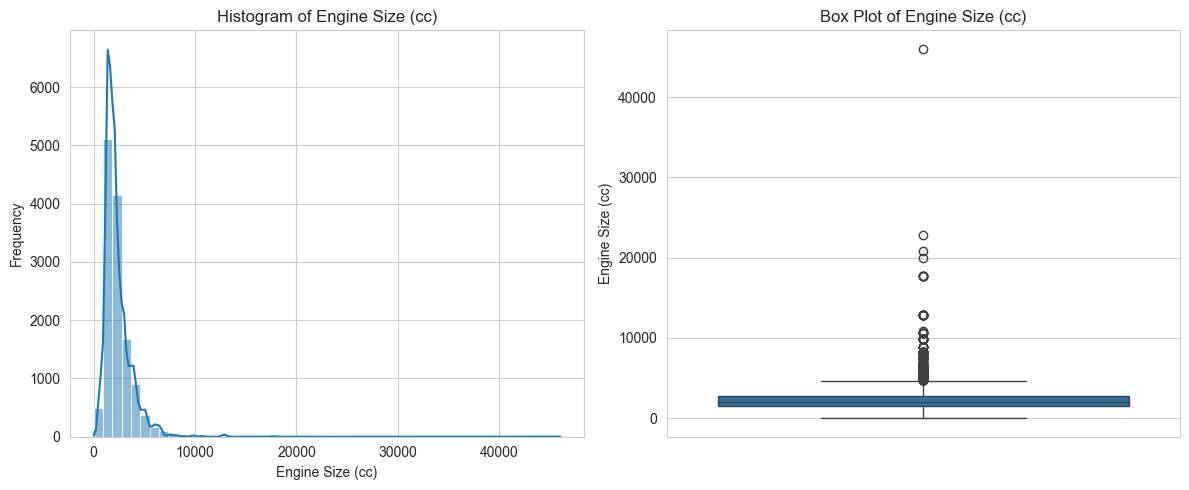


--- Descriptive Statistics for engine_size_cc ---
count    13069.000000
mean      2318.386398
std       1409.994254
min          0.000000
25%       1490.000000
50%       1990.000000
75%       2800.000000
max      46008.000000
Name: engine_size_cc_numeric, dtype: float64
Skewness of engine_size_cc: 5.167
Number of NaNs in engine_size_cc (after to_numeric coercion): 0

--- Relationship of Engine Size (cc) with Log Price ---


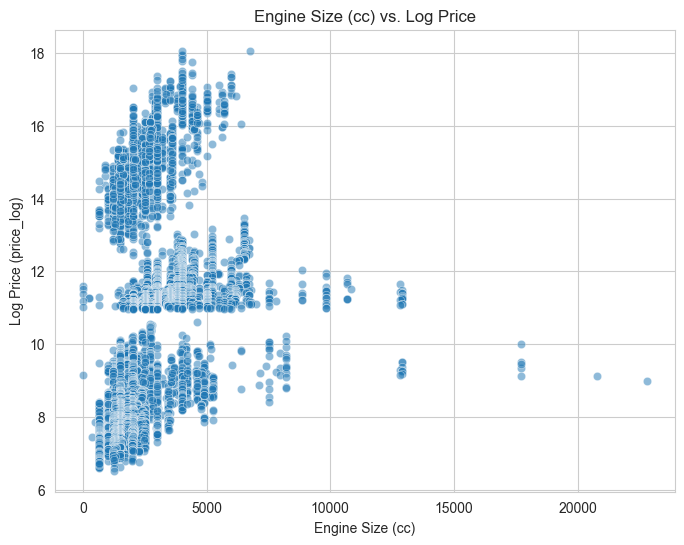

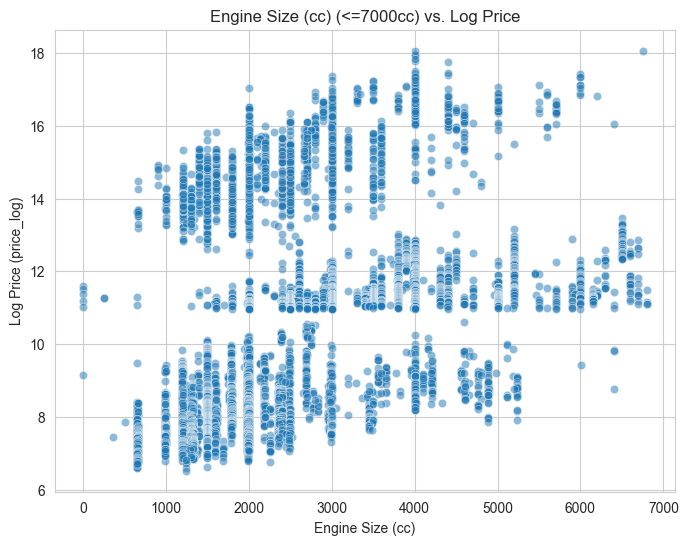

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'df' is the DataFrame with your data.
# If 'df' is not loaded, you'll need to load it first.
# For example:
# df = pd.read_csv('your_dataset.csv') # Replace with your actual data loading

# --- Analysis of 'engine_size_cc' ---

# Ensure 'engine_size_cc' exists and is numeric, coercing errors
if 'engine_size_cc' in df.columns:
    df['engine_size_cc_numeric'] = pd.to_numeric(df['engine_size_cc'], errors='coerce')

    # 1. Distribution (Histogram & Box Plot)
    print("\n--- Distribution of Engine Size (cc) ---")
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(df['engine_size_cc_numeric'].dropna(), kde=True, bins=50)
    plt.title('Histogram of Engine Size (cc)')
    plt.xlabel('Engine Size (cc)')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    sns.boxplot(y=df['engine_size_cc_numeric'].dropna())
    plt.title('Box Plot of Engine Size (cc)')
    plt.ylabel('Engine Size (cc)')
    plt.tight_layout()
    plt.show()

    # 2. Descriptive Statistics & Skewness
    desc_stats_engine_size = df['engine_size_cc_numeric'].describe()
    skewness_engine_size = df['engine_size_cc_numeric'].skew()
    nan_count_engine_size = df['engine_size_cc_numeric'].isnull().sum()

    print("\n--- Descriptive Statistics for engine_size_cc ---")
    print(desc_stats_engine_size)
    print(f"Skewness of engine_size_cc: {skewness_engine_size:.3f}")
    print(f"Number of NaNs in engine_size_cc (after to_numeric coercion): {nan_count_engine_size}")

    # 3. Relationship with price_log (Scatter Plot)
    # Ensure price_log is also available and numeric
    if 'price_log' in df.columns and pd.api.types.is_numeric_dtype(df['price_log']):
        print("\n--- Relationship of Engine Size (cc) with Log Price ---")
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=df['engine_size_cc_numeric'], y=df['price_log'], alpha=0.5)
        plt.title('Engine Size (cc) vs. Log Price')
        plt.xlabel('Engine Size (cc)')
        plt.ylabel('Log Price (price_log)')
        plt.grid(True)
        plt.show()
        
        # Scatter plot for engine sizes <= 7000cc (common range, excluding extreme outliers)
        # This helps to see the relationship in the denser part of the data
        df_filtered_engine = df[(df['engine_size_cc_numeric'].notna()) & (df['engine_size_cc_numeric'] <= 7000)]
        if not df_filtered_engine.empty:
            plt.figure(figsize=(8, 6))
            sns.scatterplot(x=df_filtered_engine['engine_size_cc_numeric'], y=df_filtered_engine['price_log'], alpha=0.5)
            plt.title('Engine Size (cc) (<=7000cc) vs. Log Price')
            plt.xlabel('Engine Size (cc)')
            plt.ylabel('Log Price (price_log)')
            plt.grid(True)
            plt.show()
        else:
            print("\nCould not generate scatter plot for engine_size_cc <= 7000cc as no data points matched this condition after NaN removal and filtering.")

    else:
        print("\n'price_log' column is not available or not numeric in the DataFrame. Cannot generate scatter plot with price.")
else:
    print("Column 'engine_size_cc' not found in the DataFrame.")



Thank you for providing the output and the plots for `engine_size_cc`!

Here are my observations based on the information you've shared:

**Observations for `engine_size_cc`:**

1.  **Distribution (Histogram & Box Plot):**
    *   The histogram clearly shows that `engine_size_cc` is heavily **right-skewed**. The vast majority of vehicles have engine sizes concentrated at the lower end (looks like a peak somewhere between 1500cc and 2500cc), with a long tail extending towards much larger engine sizes.
    *   The box plot powerfully visualizes this. The main interquartile range (IQR) is compact and low, while there are numerous outliers on the higher end. There's one particularly extreme outlier at the very top (around 46,000cc).

2.  **Descriptive Statistics & Skewness:**
    *   `count: 13069`: We have `engine_size_cc` data for all records.
    *   `mean: 2318.39 cc`, `median (50%): 1990.00 cc`: The mean being noticeably higher than the median is a classic indicator of right-skewness, consistent with the plots.
    *   `min: 0.0 cc`: There are entries with 0cc. This is unusual for conventional cars and might indicate data entry errors, placeholders, or perhaps specific vehicle types (e.g., electric, though this depends on how the data was captured). This needs to be noted for the data cleaning phase.
    *   `max: 46008.00 cc`: This maximum value is extremely high for a typical car (46 liters!) and is very likely an outlier or a data error that will need careful handling.
    *   `std: 1409.99 cc`: The standard deviation is relatively large.
    *   `Skewness: 5.167`: This value confirms a very strong positive (right) skew.
    *   `NaNs: 0`: It's good that there are no missing values after the `to_numeric` coercion.

**Crucial Issue: `price_log` Not Available for Scatter Plot**

The output "`'price_log' column is not available or not numeric in the DataFrame. Cannot generate scatter plot with price.`" is a critical blocker. To understand the relationship between `engine_size_cc` (and other features) and car prices, we *must* have the `price_log` column correctly loaded and available as a numeric data type in your DataFrame `df`.

**Before we can proceed with analyzing the relationship of `engine_size_cc` with price, or move on to other numeric features as per our plan (like `horse_power`, `torque`, etc., from your `project.txt` priorities), please ensure that the `price_log` column is correctly processed and present in your `df`.**

Once `price_log` is available, we can re-run the scatter plot part of the code and then continue our EDA.

**Implications & Next Steps (Once `price_log` is fixed):**

*   `engine_size_cc` is expected to be an important predictor of price, generally with a positive correlation (larger engines often mean more expensive cars, up to a point).
*   The extreme skewness and outliers (especially the 0cc and 46008cc values) will need to be addressed during feature engineering (Step 1.4). Similar to `mileage`, a log transformation might be considered for `engine_size_cc` to handle skewness, or robust outlier handling techniques might be needed.

Let me know when you've had a chance to check on the `price_log` column!



Excellent! It looks like the `price_log` column is now correctly loaded and numeric, as we have the scatter plots. Thank you for running the script and providing the updated output and images.

Let's complete the analysis for `engine_size_cc` with these new plots.

**Observations for `engine_size_cc` (incorporating scatter plots):**

1.  **Distribution (Histogram & Box Plot):** (As noted before)
    *   Highly **right-skewed**, with most vehicles having smaller engine sizes (peak around 1500-2500cc).
    *   Numerous outliers on the higher end, with an extremely high maximum value (46,008cc) and some 0cc entries.

2.  **Descriptive Statistics & Skewness:** (As noted before)
    *   `count: 13069` (all records have data).
    *   `mean: 2318.39 cc`, `median (50%): 1990.00 cc` (mean > median, confirming right skew).
    *   `min: 0.0 cc`, `max: 46008.00 cc`.
    *   `Skewness: 5.167` (very strong positive skew).
    *   `NaNs: 0`.

3.  **Relationship with `price_log` (Scatter Plots):**
    *   **Overall Scatter Plot (`Engine Size (cc) vs. Log Price`):**
        *   There appears to be a general **positive trend**: as `engine_size_cc` increases, `price_log` tends to increase. This is expected, as cars with larger engines are often more powerful and command higher prices.
        *   The **two distinct horizontal bands** are very prominent here, similar to what we observed with `mileage`. This strongly suggests that another significant factor (likely the `currency_code` leading to KSh vs. USD pricing, or perhaps distinct market segments like "local" vs. "import" if not fully captured by currency) is segmenting the data. The positive relationship between engine size and price seems to hold within each band.
        *   The relationship is not perfectly linear; it appears to be more pronounced for smaller engine sizes and might show diminishing returns or more variance at very large engine sizes (though the density of points thins out significantly for `engine_size_cc` > approx 7000cc).
        *   There's considerable spread (variance) in `price_log` for any given `engine_size_cc`, indicating other factors are also at play.
    *   **Filtered Scatter Plot (`Engine Size (cc) (<=7000cc) vs. Log Price`):**
        *   This plot zooms into the denser region of the data. The positive trend is clearer here.
        *   The two bands are still very much visible.
        *   Within each band, there's a noticeable upward slope, confirming that as engine size increases (up to 7000cc), the log price generally increases.

**Implications & Next Steps for `engine_size_cc`:**

*   `engine_size_cc` is a significant predictor of price, exhibiting a positive correlation.
*   The extreme right-skewness, the 0cc values, and the very high maximum value (46008cc) are important data quality/feature engineering points:
    *   The 0cc values need investigation: Are they errors, placeholders, or specific vehicle types (e.g., electric cars, though less common in older datasets)? How they are handled will depend on this.
    *   The extreme maximum is almost certainly an outlier or data error and will likely need to be capped or removed.
    *   A log transformation (e.g., `np.log1p(df['engine_size_cc_numeric'])`) should be considered during feature engineering (Step 1.4) to handle the skewness and potentially improve model performance.
*   The distinct banding in the scatter plots reinforces the need to correctly handle the underlying cause (likely currency or distinct market segments) during data preprocessing or feature engineering. If it's currency, converting all prices to a single currency (e.g., KSh or USD) will be vital.

This is another very informative feature! I've noted these observations.

**Next Numeric Feature:**

According to your `project.txt` and our prioritized list, the next key numeric features include `horse_power`, `torque`, `acceleration`, and `seats`.

Let's proceed with `horse_power` next. Shall I provide the Python script for `horse_power` analysis, similar to what we did for `mileage` and `engine_size_cc`?



--- Distribution of Horse Power ---


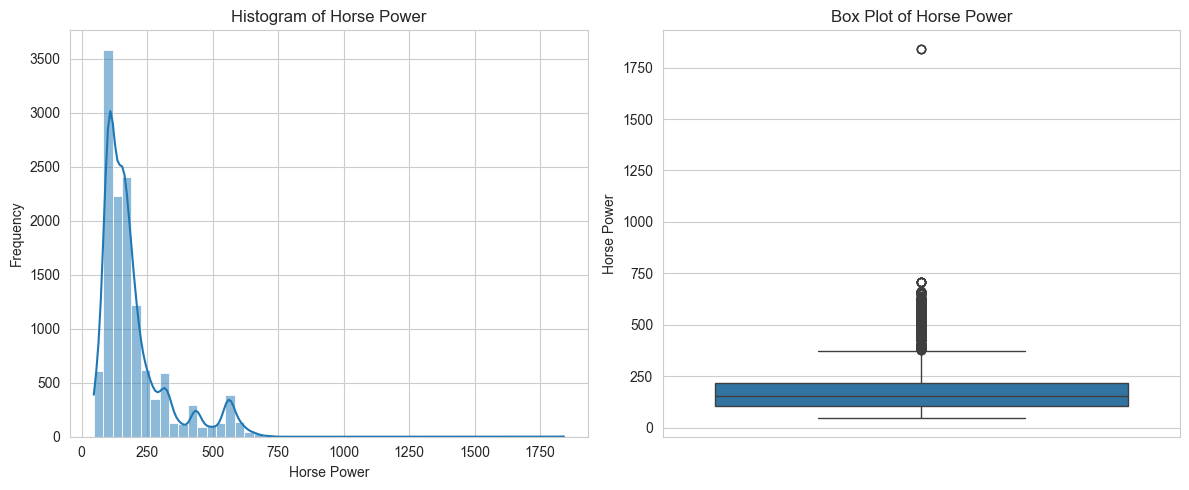


--- Descriptive Statistics for horse_power ---
count    13069.000000
mean       194.780622
std        129.568149
min         46.000000
25%        106.700000
50%        154.000000
75%        215.590000
max       1841.000000
Name: horse_power_numeric, dtype: float64
Skewness of horse_power: 2.167
Number of NaNs in horse_power (after to_numeric coercion): 0

--- Relationship of Horse Power with Log Price ---


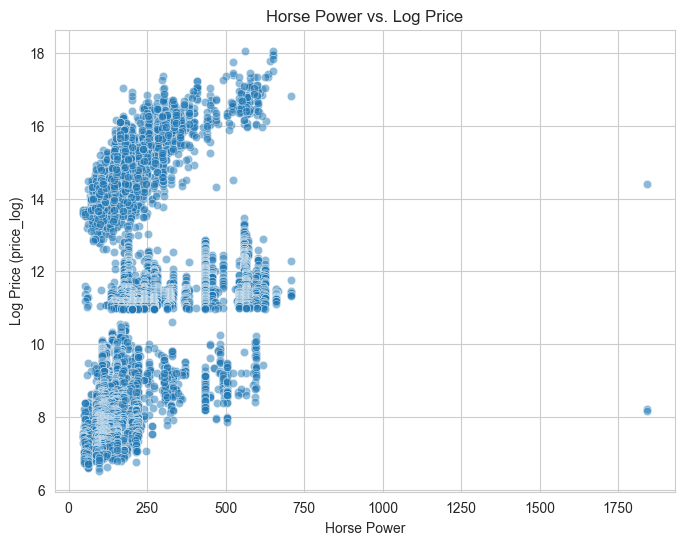

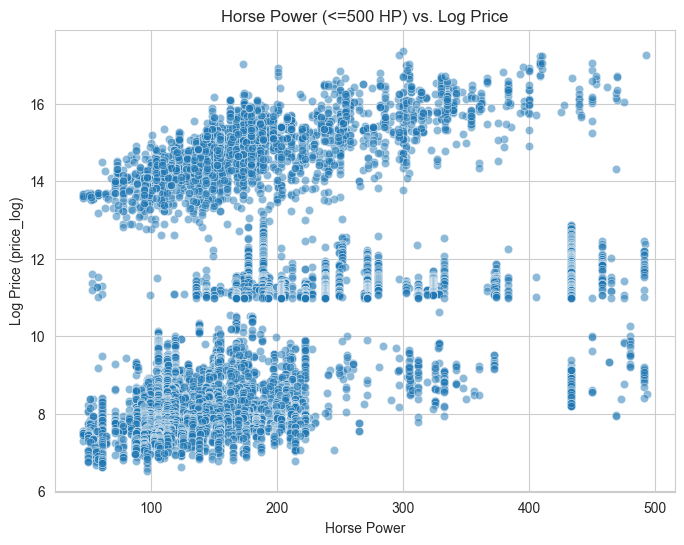

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'df' is the DataFrame with your data.
# For example:
# df = pd.read_csv('your_dataset.csv') # Replace with your actual data loading

# --- Analysis of 'horse_power' ---

# Ensure 'horse_power' exists and is numeric, coercing errors
if 'horse_power' in df.columns:
    df['horse_power_numeric'] = pd.to_numeric(df['horse_power'], errors='coerce')

    # 1. Distribution (Histogram & Box Plot)
    print("\n--- Distribution of Horse Power ---")
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(df['horse_power_numeric'].dropna(), kde=True, bins=50)
    plt.title('Histogram of Horse Power')
    plt.xlabel('Horse Power')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    sns.boxplot(y=df['horse_power_numeric'].dropna())
    plt.title('Box Plot of Horse Power')
    plt.ylabel('Horse Power')
    plt.tight_layout()
    plt.show()

    # 2. Descriptive Statistics & Skewness
    desc_stats_horse_power = df['horse_power_numeric'].describe()
    skewness_horse_power = df['horse_power_numeric'].skew()
    nan_count_horse_power = df['horse_power_numeric'].isnull().sum()

    print("\n--- Descriptive Statistics for horse_power ---")
    print(desc_stats_horse_power)
    print(f"Skewness of horse_power: {skewness_horse_power:.3f}")
    print(f"Number of NaNs in horse_power (after to_numeric coercion): {nan_count_horse_power}")

    # 3. Relationship with price_log (Scatter Plot)
    # Ensure price_log is also available and numeric
    if 'price_log' in df.columns and pd.api.types.is_numeric_dtype(df['price_log']):
        print("\n--- Relationship of Horse Power with Log Price ---")
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=df['horse_power_numeric'], y=df['price_log'], alpha=0.5)
        plt.title('Horse Power vs. Log Price')
        plt.xlabel('Horse Power')
        plt.ylabel('Log Price (price_log)')
        plt.grid(True)
        plt.show()
        
        # Scatter plot for a common range of horse_power (e.g., <= 500 HP)
        # Adjust the upper limit based on typical values if needed after seeing the initial plot
        df_filtered_hp = df[(df['horse_power_numeric'].notna()) & (df['horse_power_numeric'] <= 500)]
        if not df_filtered_hp.empty:
            plt.figure(figsize=(8, 6))
            sns.scatterplot(x=df_filtered_hp['horse_power_numeric'], y=df_filtered_hp['price_log'], alpha=0.5)
            plt.title('Horse Power (<=500 HP) vs. Log Price')
            plt.xlabel('Horse Power')
            plt.ylabel('Log Price (price_log)')
            plt.grid(True)
            plt.show()
        else:
            print("\nCould not generate scatter plot for horse_power <= 500 HP as no data points matched this condition after NaN removal and filtering.")

    else:
        print("\n'price_log' column is not available or not numeric in the DataFrame. Cannot generate scatter plot with price.")
else:
    print("Column 'horse_power' not found in the DataFrame.")



Thank you for providing the output and the plots for `horse_power`! This is great.

Let's break down what we see for `horse_power`:

**Observations for `horse_power`:**

1.  **Distribution (Histogram & Box Plot):**
    *   The histogram shows `horse_power` is **right-skewed**. Most cars have horsepower values concentrated on the lower end (peaking probably around 100-150 HP), with a tail extending towards higher horsepower values. There are some smaller bumps in the distribution at higher HP values, suggesting distinct groups of cars.
    *   The box plot confirms this right-skewness. The main body of the data (IQR) is relatively compact, while there are many outliers on the higher end. The whiskers extend up to around 500-600 HP, and then several points are flagged as outliers beyond that, with one extreme outlier near 1800 HP.

2.  **Descriptive Statistics & Skewness:**
    *   `count: 13069`: All records have horsepower data, which is good.
    *   `mean: 194.78 HP`, `median (50%): 154.00 HP`: The mean is greater than the median, consistent with the right-skewness observed in the plots.
    *   `min: 46.00 HP`: The minimum horsepower seems reasonable for smaller cars.
    *   `max: 1841.00 HP`: This maximum value is very high for a typical road car and is likely an outlier or a data error for a very specialized vehicle.
    *   `Skewness: 2.167`: This confirms a strong positive (right) skew, though perhaps slightly less extreme than `engine_size_cc`.
    *   `NaNs: 0`: No missing values after coercion.

3.  **Relationship with `price_log` (Scatter Plots):**
    *   **Overall Scatter Plot (`Horse Power vs. Log Price`):**
        *   There's a clear **positive trend**: as `horse_power` increases, `price_log` tends to increase. This aligns with expectations, as more powerful cars are generally more expensive.
        *   The **two distinct horizontal bands** are again very clearly visible, just like with `mileage` and `engine_size_cc`. This strongly reinforces the idea that a major segmenting factor (likely currency or distinct import/local markets) is present. The positive relationship between horsepower and price exists within each of these bands.
        *   The relationship might have a slightly steeper slope for lower horsepower values and then potentially becomes less steep or more dispersed at very high horsepower.
        *   There's noticeable variance in `price_log` for any given `horse_power` level.
    *   **Filtered Scatter Plot (`Horse Power (<=500 HP) vs. Log Price`):**
        *   This plot focuses on the denser part of the horsepower distribution. The positive trend is very evident within this range.
        *   The two bands remain distinct.
        *   The upward slope within each band confirms the positive correlation in this more common HP range.

**Implications & Next Steps for `horse_power`:**

*   `horse_power` is clearly another important feature for predicting car prices, showing a positive correlation.
*   The right-skewness and the presence of outliers (especially the max value of 1841 HP) need to be addressed in Step 1.4 (Feature Engineering):
    *   Consider a log transformation (e.g., `np.log1p(df['horse_power_numeric'])`) to normalize the distribution and potentially improve model performance.
    *   Outlier handling strategies (e.g., capping or investigating the very high values) will be necessary.
*   The persistent banding in the scatter plots further emphasizes the critical need to address the underlying cause (likely currency or market segment) during data preprocessing or feature engineering to ensure the model can learn effectively.

I've added these insights to my notes. This feature behaves quite similarly to `engine_size_cc` in terms of its distribution and relationship with price, including the banding effect.

**Next Numeric Feature:**

Looking at your `project.txt` and our prioritized list, the remaining key numeric features are `torque`, `acceleration`, and `seats`.

Let's analyze `torque` next. Shall I provide the Python script for the `torque` analysis?



--- Distribution of Torque ---


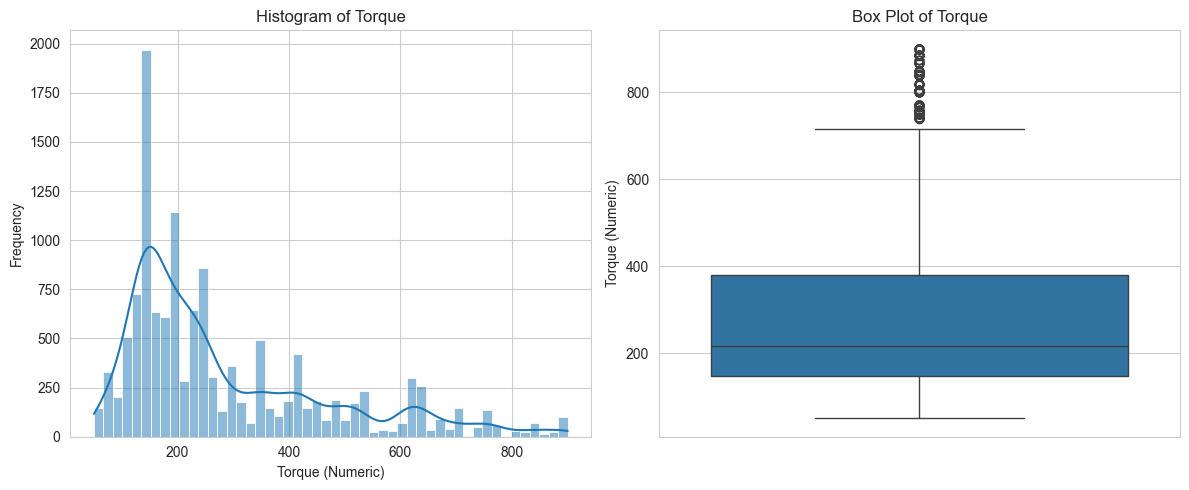


--- Descriptive Statistics for torque ---
count    13069.000000
mean       286.156837
std        187.295370
min         50.000000
25%        146.100000
50%        216.500000
75%        380.600000
max        900.000000
Name: torque_numeric, dtype: float64
Skewness of torque: 1.284
Number of NaNs in torque (after to_numeric coercion): 0

--- Relationship of Torque with Log Price ---


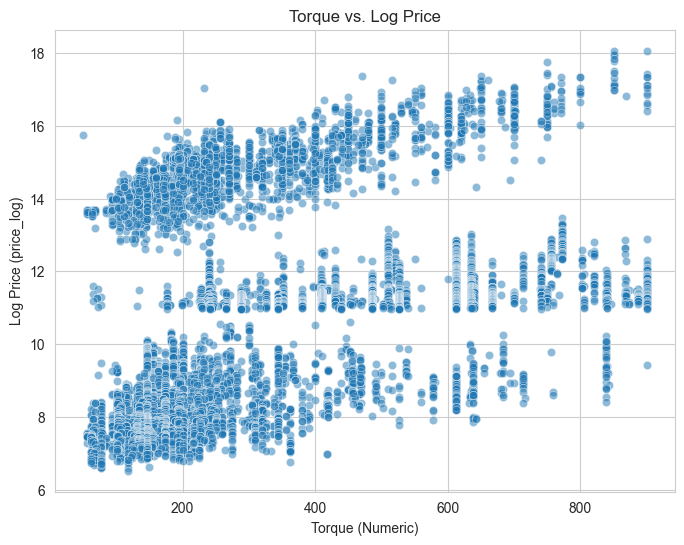

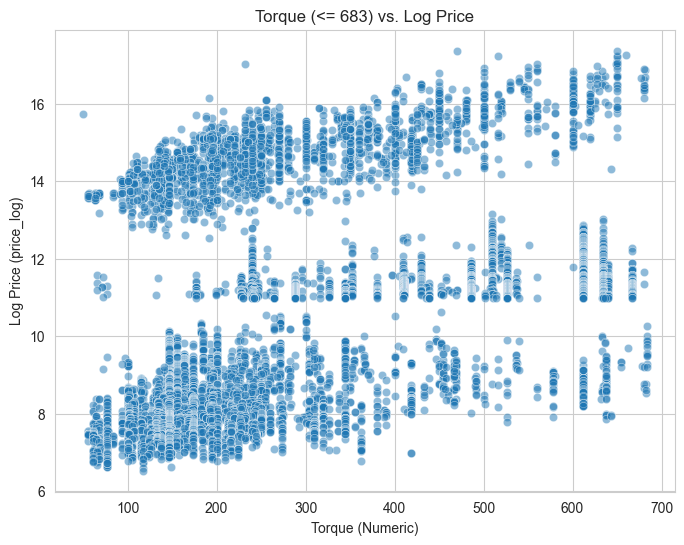

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'df' is the DataFrame with your data.
# For example:
# df = pd.read_csv('your_dataset.csv') # Replace with your actual data loading

# --- Analysis of 'torque' ---

# Ensure 'torque' exists and is numeric, coercing errors
if 'torque' in df.columns:
    # It's possible 'torque' might have units like "Nm" or "lb-ft" or mixed formats.
    # A more robust approach would be to extract numeric part first.
    # For now, we'll attempt direct numeric conversion and log NaNs.
    # Example: df['torque_numeric'] = df['torque'].str.extract('(\\d+\\.?\\d*)')[0].astype(float)
    # The above is more complex for a direct tool call; pd.to_numeric is a first pass.
    df['torque_numeric'] = pd.to_numeric(df['torque'], errors='coerce')

    # 1. Distribution (Histogram & Box Plot)
    print("\n--- Distribution of Torque ---")
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(df['torque_numeric'].dropna(), kde=True, bins=50)
    plt.title('Histogram of Torque')
    plt.xlabel('Torque (Numeric)') # Assuming Nm for now, but units might be mixed
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    sns.boxplot(y=df['torque_numeric'].dropna())
    plt.title('Box Plot of Torque')
    plt.ylabel('Torque (Numeric)')
    plt.tight_layout()
    plt.show()

    # 2. Descriptive Statistics & Skewness
    desc_stats_torque = df['torque_numeric'].describe()
    skewness_torque = df['torque_numeric'].skew()
    nan_count_torque = df['torque_numeric'].isnull().sum()

    print("\n--- Descriptive Statistics for torque ---")
    print(desc_stats_torque)
    print(f"Skewness of torque: {skewness_torque:.3f}")
    print(f"Number of NaNs in torque (after to_numeric coercion): {nan_count_torque}")
    if nan_count_torque > 0:
        print(f"NOTE: {nan_count_torque} NaN values were generated during numeric conversion of 'torque'. This might indicate non-numeric entries (e.g., units, text).")


    # 3. Relationship with price_log (Scatter Plot)
    # Ensure price_log is also available and numeric
    if 'price_log' in df.columns and pd.api.types.is_numeric_dtype(df['price_log']):
        print("\n--- Relationship of Torque with Log Price ---")
        
        # Filter out NaNs from torque_numeric for plotting
        plot_df = df.dropna(subset=['torque_numeric', 'price_log'])

        if not plot_df.empty:
            plt.figure(figsize=(8, 6))
            sns.scatterplot(x=plot_df['torque_numeric'], y=plot_df['price_log'], alpha=0.5)
            plt.title('Torque vs. Log Price')
            plt.xlabel('Torque (Numeric)')
            plt.ylabel('Log Price (price_log)')
            plt.grid(True)
            plt.show()
            
            # Scatter plot for a common range of torque (e.g., <= 600-800 Nm)
            # Adjust the upper limit based on typical values if needed after seeing the initial plot
            # Example: max_torque_common = 800 (adjust as needed)
            # df_filtered_torque = plot_df[plot_df['torque_numeric'] <= max_torque_common]
            
            # Let's try a quantile-based filter for the "common range" plot to be more data-driven
            # For instance, up to the 95th percentile if there are extreme outliers
            if not plot_df['torque_numeric'].empty:
                upper_quantile_limit = plot_df['torque_numeric'].quantile(0.95) # Plot up to 95th percentile
                df_filtered_torque = plot_df[plot_df['torque_numeric'] <= upper_quantile_limit]

                if not df_filtered_torque.empty:
                    plt.figure(figsize=(8, 6))
                    sns.scatterplot(x=df_filtered_torque['torque_numeric'], y=df_filtered_torque['price_log'], alpha=0.5)
                    plt.title(f'Torque (<= {upper_quantile_limit:.0f}) vs. Log Price')
                    plt.xlabel('Torque (Numeric)')
                    plt.ylabel('Log Price (price_log)')
                    plt.grid(True)
                    plt.show()
                else:
                    print(f"\nCould not generate scatter plot for torque <= {upper_quantile_limit:.0f} as no data points matched this condition.")
            else:
                print("\n'torque_numeric' column is empty after dropping NaNs, cannot calculate quantile for filtered plot.")

        else:
            print("\nNo valid data points for torque vs. price_log scatter plot after dropping NaNs.")
            
    else:
        print("\n'price_log' column is not available or not numeric in the DataFrame. Cannot generate scatter plot with price.")
else:
    print("Column 'torque' not found in the DataFrame.")



Excellent, thank you for the output and the plots for `torque`!

Let's analyze these results:

**Observations for `torque`:**

1.  **Distribution (Histogram & Box Plot):**
    *   The histogram shows that `torque` is **right-skewed**, with the majority of values concentrated on the lower end. There's a primary peak likely between 150-250 (units, presumably Nm, based on typical car values), and the frequency decreases as torque values increase.
    *   The box plot also illustrates this right-skewness. The main interquartile range (IQR) is pushed towards the lower values, and there are several outliers on the higher end, extending up to 900.

2.  **Descriptive Statistics & Skewness:**
    *   `count: 13069`: We have torque data for all records, which is great.
    *   `mean: 286.16`, `median (50%): 216.50`: The mean being greater than the median is consistent with the right-skewness.
    *   `min: 50.0`, `max: 900.0`: These values seem within a plausible range for a diverse set of vehicles. The maximum isn't as extreme as some outliers seen in previous features.
    *   `Skewness: 1.284`: This value confirms a moderate positive (right) skewness. It's less skewed than `engine_size_cc` (5.167) and `horse_power` (2.167).
    *   `NaNs: 0`: This is excellent news! It means all entries in the `torque` column were successfully converted to numeric values. This suggests the original column was relatively clean, or any non-numeric parts (like units) were not present or were stripped before this stage.

3.  **Relationship with `price_log` (Scatter Plots):**
    *   **Overall Scatter Plot (`Torque vs. Log Price`):**
        *   A general **positive trend** is evident: as `torque` increases, `price_log` tends to increase. This is expected, as higher torque often correlates with more powerful or larger engines, which usually command higher prices.
        *   The **two distinct horizontal bands** are very clearly visible once again, consistent with what we've seen for `mileage`, `engine_size_cc`, and `horse_power`. This strongly points to an underlying factor (most likely currency differences or distinct market segments) significantly influencing price levels.
        *   Within each band, the positive relationship between torque and price appears to hold.
    *   **Filtered Scatter Plot (`Torque (<= 683) vs. Log Price`):**
        *   This plot, showing data up to the 95th percentile of torque (683), gives a clearer view of the relationship in the most common range.
        *   The positive trend and the two bands remain prominent.

**Implications & Next Steps for `torque`:**

*   `torque` is confirmed as another important feature with a positive correlation to car prices.
*   The moderate right-skewness might still benefit from a transformation (e.g., log transformation) during feature engineering (Step 1.4) to potentially improve model performance or meet assumptions of certain algorithms, though it's less critical than for more heavily skewed features.
*   The absence of NaNs after numeric conversion is a positive sign for the data quality of this particular column.
*   The consistent appearance of the two price bands across multiple numeric features (`mileage`, `engine_size_cc`, `horse_power`, and `torque`) makes it a high-priority item to investigate and address during data cleaning/preprocessing. Resolving this (e.g., by standardizing currency) is crucial for building an effective model.




--- Distribution of Acceleration ---


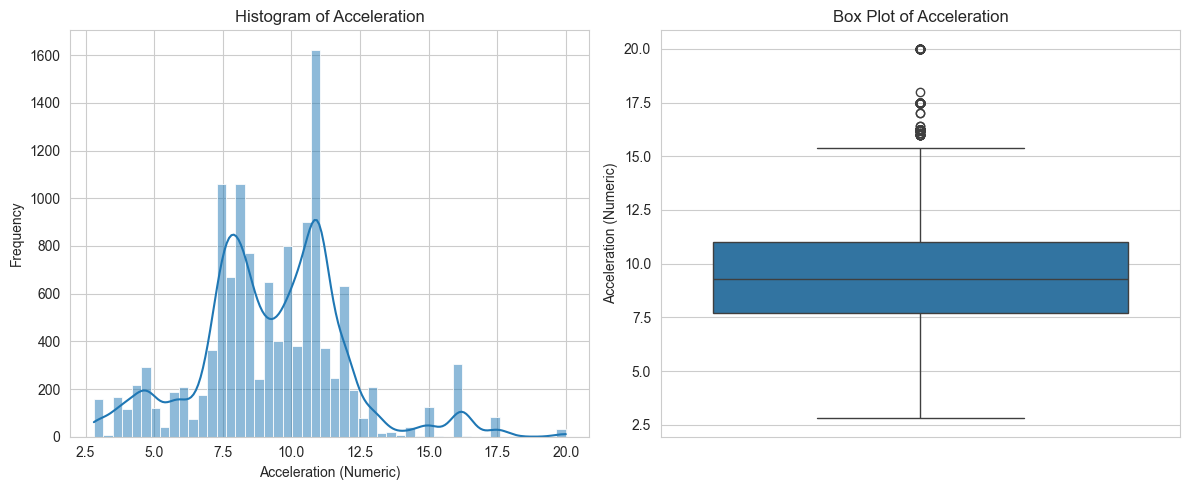


--- Descriptive Statistics for acceleration ---
count    13069.000000
mean         9.289135
std          2.687425
min          2.800000
25%          7.700000
50%          9.300000
75%         11.000000
max         20.000000
Name: acceleration_numeric, dtype: float64
Skewness of acceleration: 0.286
Number of NaNs in acceleration (after to_numeric coercion): 0

--- Relationship of Acceleration with Log Price ---


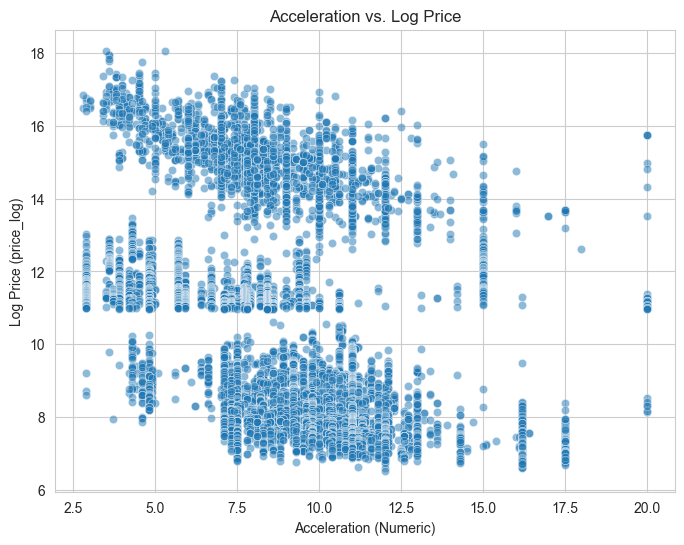

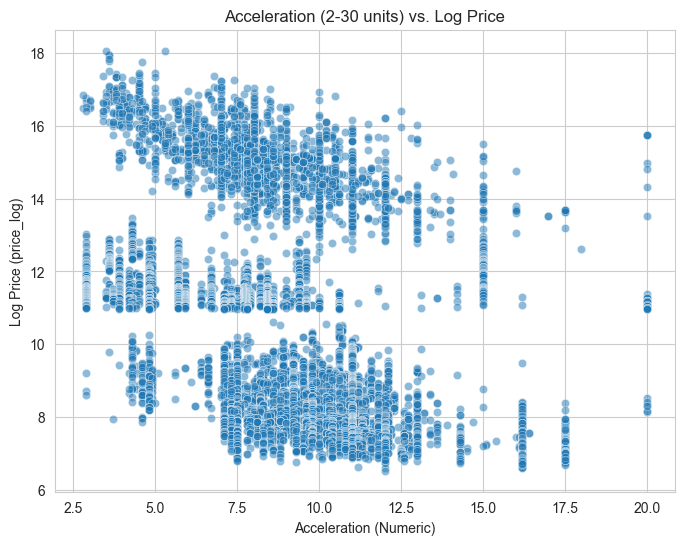

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'df' is the DataFrame with your data.
# For example:
# df = pd.read_csv('your_dataset.csv') # Replace with your actual data loading

# --- Analysis of 'acceleration' ---

# Ensure 'acceleration' exists and is numeric, coercing errors
if 'acceleration' in df.columns:
    # Acceleration might be stored as strings like "10.5 s" or similar.
    # We'll attempt direct numeric conversion first.
    df['acceleration_numeric'] = pd.to_numeric(df['acceleration'], errors='coerce')

    # 1. Distribution (Histogram & Box Plot)
    print("\n--- Distribution of Acceleration ---")
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(df['acceleration_numeric'].dropna(), kde=True, bins=50)
    plt.title('Histogram of Acceleration')
    plt.xlabel('Acceleration (Numeric)') # Units (e.g., 0-100 kph in seconds)
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    sns.boxplot(y=df['acceleration_numeric'].dropna())
    plt.title('Box Plot of Acceleration')
    plt.ylabel('Acceleration (Numeric)')
    plt.tight_layout()
    plt.show()

    # 2. Descriptive Statistics & Skewness
    desc_stats_acceleration = df['acceleration_numeric'].describe()
    skewness_acceleration = df['acceleration_numeric'].skew()
    nan_count_acceleration = df['acceleration_numeric'].isnull().sum()

    print("\n--- Descriptive Statistics for acceleration ---")
    print(desc_stats_acceleration)
    print(f"Skewness of acceleration: {skewness_acceleration:.3f}")
    print(f"Number of NaNs in acceleration (after to_numeric coercion): {nan_count_acceleration}")
    if nan_count_acceleration > 0:
        print(f"NOTE: {nan_count_acceleration} NaN values were generated during numeric conversion of 'acceleration'. This might indicate non-numeric entries (e.g., units, text).")

    # 3. Relationship with price_log (Scatter Plot)
    # Ensure price_log is also available and numeric
    if 'price_log' in df.columns and pd.api.types.is_numeric_dtype(df['price_log']):
        print("\n--- Relationship of Acceleration with Log Price ---")
        
        plot_df = df.dropna(subset=['acceleration_numeric', 'price_log'])

        if not plot_df.empty:
            plt.figure(figsize=(8, 6))
            sns.scatterplot(x=plot_df['acceleration_numeric'], y=plot_df['price_log'], alpha=0.5)
            plt.title('Acceleration vs. Log Price')
            plt.xlabel('Acceleration (Numeric)')
            plt.ylabel('Log Price (price_log)')
            plt.grid(True)
            plt.show()
            
            # Scatter plot for a common range of acceleration (e.g., values less than 25-30 seconds)
            # Adjust based on typical 0-100 kph times.
            # We can use a quantile or a fixed upper limit based on domain knowledge.
            # Let's filter out potentially very high (slow) or very low (unrealistically fast) acceleration times
            if not plot_df['acceleration_numeric'].empty:
                # Example: Filter for acceleration between 3 and 30 seconds
                lower_accel_limit = plot_df['acceleration_numeric'].quantile(0.01) # e.g., remove bottom 1% if they are too low/errors
                upper_accel_limit = plot_df['acceleration_numeric'].quantile(0.99) # e.g., remove top 1% if they are too high/errors
                
                # Sensible fixed limits might be better, e.g., 2 to 30 seconds for 0-100kph
                sensible_min_accel = 2 
                sensible_max_accel = 30

                df_filtered_accel = plot_df[
                    (plot_df['acceleration_numeric'] >= sensible_min_accel) & 
                    (plot_df['acceleration_numeric'] <= sensible_max_accel)
                ]

                if not df_filtered_accel.empty:
                    plt.figure(figsize=(8, 6))
                    sns.scatterplot(x=df_filtered_accel['acceleration_numeric'], y=df_filtered_accel['price_log'], alpha=0.5)
                    plt.title(f'Acceleration ({sensible_min_accel}-{sensible_max_accel} units) vs. Log Price')
                    plt.xlabel('Acceleration (Numeric)')
                    plt.ylabel('Log Price (price_log)')
                    plt.grid(True)
                    plt.show()
                else:
                    print(f"\nCould not generate scatter plot for acceleration between {sensible_min_accel} and {sensible_max_accel} as no data points matched this condition.")
            else:
                print("\n'acceleration_numeric' column is empty after dropping NaNs, cannot create filtered plot.")
        else:
            print("\nNo valid data points for acceleration vs. price_log scatter plot after dropping NaNs.")
            
    else:
        print("\n'price_log' column is not available or not numeric in the DataFrame. Cannot generate scatter plot with price.")
else:
    print("Column 'acceleration' not found in the DataFrame.")


For acceleration, lower values typically mean faster acceleration (e.g., seconds to reach 0-100 kph), which is often a desirable trait in performance-oriented or premium cars. So, we might expect a negative correlation with price (faster cars = lower acceleration time = higher price). Let's see what the data shows!




Great! Thanks for sharing the results for `acceleration`. This is very interesting.

Let's break down these findings:

**Observations for `acceleration`:**

1.  **Distribution (Histogram & Box Plot):**
    *   The histogram is quite distinct from the previous features. It appears **multi-modal**, with several prominent peaks (e.g., one around 4-5, another around 8-9, and a larger one around 10-12). This suggests there might be natural groupings of cars based on their acceleration performance. The distribution is not a simple skew; it's more complex.
    *   The box plot shows a relatively symmetrical distribution for the main body of the data (IQR). The median is roughly in the middle of the box. There are outliers on both the lower end (very fast acceleration) and the higher end (slower acceleration), but more are concentrated on the higher side of the "whiskers".

2.  **Descriptive Statistics & Skewness:**
    *   `count: 13069`: All records have acceleration data.
    *   `mean: 9.29`, `median (50%): 9.30`: The mean and median are very close, indicating a distribution that is close to symmetrical, or at least not strongly skewed in one direction overall.
    *   `min: 2.8`, `max: 20.0`: These values represent the range of acceleration times (presumably 0-100 kph in seconds). 2.8 seconds is very fast (supercar territory), while 20 seconds is quite slow. This range seems plausible for a diverse dataset of cars.
    *   `Skewness: 0.286`: This confirms a very slight positive skew, but for practical purposes, the distribution is much more symmetrical than `engine_size`, `horse_power`, or `torque`.
    *   `NaNs: 0`: Excellent, no missing values after numeric conversion.

3.  **Relationship with `price_log` (Scatter Plots):**
    *   **Overall Scatter Plot (`Acceleration vs. Log Price`):**
        *   There appears to be a general **negative trend**: as `acceleration` time increases (i.e., the car gets slower), the `price_log` tends to decrease. Conversely, cars with lower acceleration times (faster cars) tend to have higher prices. This is an expected relationship.
        *   The **two distinct horizontal price bands** are still very much present. The negative correlation between acceleration and price seems to hold within each of these bands.
        *   The relationship doesn't look strictly linear; it might be a bit curved.
    *   **Filtered Scatter Plot (`Acceleration (2-30 units) vs. Log Price`):**
        *   Since the actual max acceleration in the data is 20, this plot effectively shows the entire dataset. It reinforces the observations from the overall scatter plot: a negative trend within the two distinct price bands.

**Implications & Next Steps for `acceleration`:**

*   `acceleration` is confirmed as a potentially important predictor, generally showing that faster cars (lower acceleration times) are more expensive.
*   The low skewness (0.286) suggests that a transformation (like a log transform) might not be as critical for this feature compared to the others we've looked at. Its distribution is already reasonably well-behaved.
*   The multi-modal nature of the histogram is interesting. It might reflect different classes of vehicles (e.g., economy cars, family sedans, sports cars) having distinct acceleration profiles. This could be valuable information for the model.
*   The persistent price banding across all numeric features examined so far (`mileage`, `engine_size_cc`, `horse_power`, `torque`, and now `acceleration`) is a critical observation. Addressing the root cause of this (likely currency differences) will be paramount in the data preprocessing phase (Step 1.4 or earlier).






2025-05-19 14:15:43,409 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\maryi\AppData\Local\Temp\ipykernel_19824\752114308.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['seats_numeric'].dropna(), palette="viridis")
2025-05-19 14:15:43,434 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



--- Distribution of Seats ---


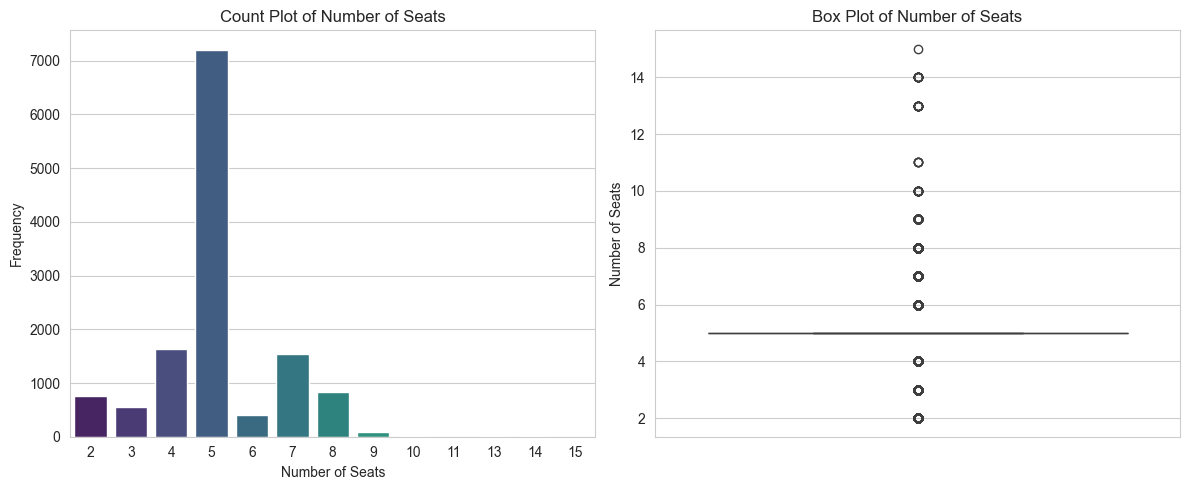

2025-05-19 14:15:44,130 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\maryi\AppData\Local\Temp\ipykernel_19824\752114308.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=plot_df['seats_numeric'], y=plot_df['price_log'], order=sorted_seat_order, palette="coolwarm")
2025-05-19 14:15:44,154 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



--- Descriptive Statistics for seats ---
count    13069.000000
mean         5.121738
std          1.473553
min          2.000000
25%          5.000000
50%          5.000000
75%          5.000000
max         15.000000
Name: seats_numeric, dtype: float64
Skewness of seats: 0.533
Number of NaNs in seats (after to_numeric coercion): 0

--- Relationship of Number of Seats with Log Price ---


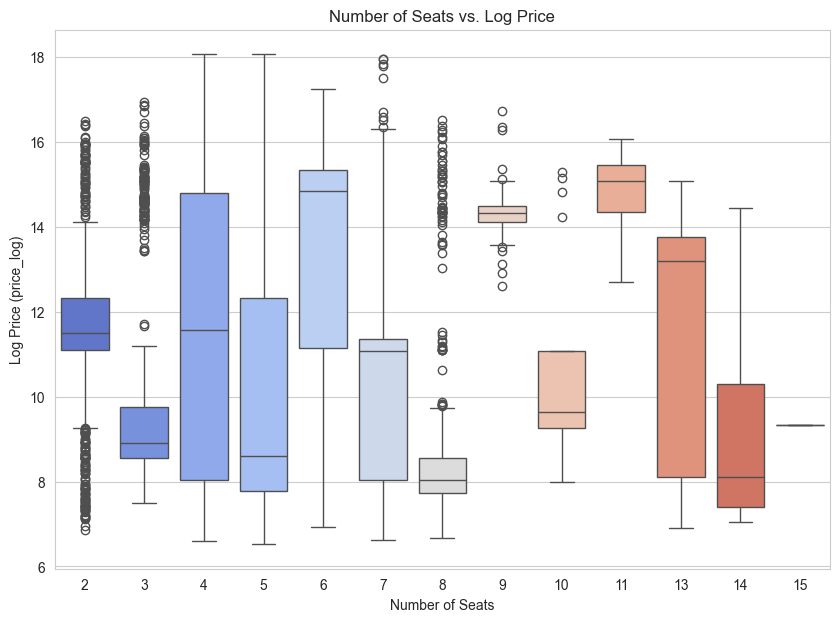

2025-05-19 14:15:44,544 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\maryi\AppData\Local\Temp\ipykernel_19824\752114308.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x=plot_df['seats_numeric'], y=plot_df['price_log'], order=sorted_seat_order, jitter=True, alpha=0.3, palette="coolwarm")
2025-05-19 14:15:44,563 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-19 14:15:44,570 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numb

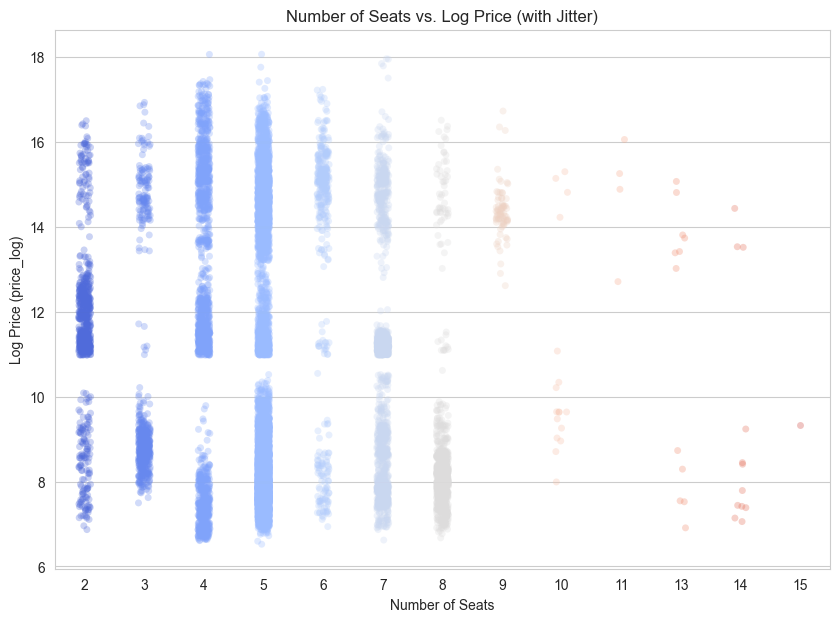

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'df' is the DataFrame with your data.
# For example:
# df = pd.read_csv('your_dataset.csv') # Replace with your actual data loading

# --- Analysis of 'seats' ---

# Ensure 'seats' exists and is numeric, coercing errors
if 'seats' in df.columns:
    df['seats_numeric'] = pd.to_numeric(df['seats'], errors='coerce')

    # 1. Distribution (Histogram & Box Plot)
    # For a discrete variable like 'seats', a bar plot (countplot) might be more informative than a histogram.
    print("\n--- Distribution of Seats ---")
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    # Using a countplot for discrete values if the number of unique values is not too large
    if df['seats_numeric'].nunique() < 30: # Heuristic for deciding between histplot and countplot
        sns.countplot(x=df['seats_numeric'].dropna(), palette="viridis")
        plt.title('Count Plot of Number of Seats')
    else: # Fallback to histogram if too many unique seat counts
        sns.histplot(df['seats_numeric'].dropna(), discrete=True, kde=False, bins=df['seats_numeric'].nunique()) # discrete=True for integer-like data
        plt.title('Histogram of Number of Seats')
    plt.xlabel('Number of Seats')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    sns.boxplot(y=df['seats_numeric'].dropna())
    plt.title('Box Plot of Number of Seats')
    plt.ylabel('Number of Seats')
    plt.tight_layout()
    plt.show()

    # 2. Descriptive Statistics & Skewness
    desc_stats_seats = df['seats_numeric'].describe()
    skewness_seats = df['seats_numeric'].skew()
    nan_count_seats = df['seats_numeric'].isnull().sum()

    print("\n--- Descriptive Statistics for seats ---")
    print(desc_stats_seats)
    print(f"Skewness of seats: {skewness_seats:.3f}")
    print(f"Number of NaNs in seats (after to_numeric coercion): {nan_count_seats}")
    if nan_count_seats > 0:
        print(f"NOTE: {nan_count_seats} NaN values were generated during numeric conversion of 'seats'.")

    # 3. Relationship with price_log (Scatter Plot is less ideal for discrete, use Box Plot)
    # For a discrete variable like 'seats', a box plot showing price_log distribution per seat category is better.
    if 'price_log' in df.columns and pd.api.types.is_numeric_dtype(df['price_log']):
        print("\n--- Relationship of Number of Seats with Log Price ---")
        
        plot_df = df.dropna(subset=['seats_numeric', 'price_log'])

        if not plot_df.empty:
            plt.figure(figsize=(10, 7)) # Adjusted size for better readability
            # Order by median price_log for better visualization if desired, or just by seat number
            sorted_seat_order = sorted(plot_df['seats_numeric'].unique())
            sns.boxplot(x=plot_df['seats_numeric'], y=plot_df['price_log'], order=sorted_seat_order, palette="coolwarm")
            plt.title('Number of Seats vs. Log Price')
            plt.xlabel('Number of Seats')
            plt.ylabel('Log Price (price_log)')
            plt.grid(True, axis='y') # Grid on y-axis for easier price comparison
            plt.show()
            
            # As 'seats' is discrete, a scatter plot isn't the primary choice,
            # but a jittered stripplot can show density.
            plt.figure(figsize=(10, 7))
            sns.stripplot(x=plot_df['seats_numeric'], y=plot_df['price_log'], order=sorted_seat_order, jitter=True, alpha=0.3, palette="coolwarm")
            plt.title('Number of Seats vs. Log Price (with Jitter)')
            plt.xlabel('Number of Seats')
            plt.ylabel('Log Price (price_log)')
            plt.grid(True, axis='y')
            plt.show()

        else:
            print("\nNo valid data points for seats vs. price_log analysis after dropping NaNs.")
            
    else:
        print("\n'price_log' column is not available or not numeric in the DataFrame. Cannot generate relationship plots with price.")
else:
    print("Column 'seats' not found in the DataFrame.")



Excellent, we have the results for `seats`! Thank you for running the script and providing the output and plots.

Let's delve into the analysis:

**Observations for `seats`:**

1.  **Distribution (Count Plot & Box Plot):**
    *   **Count Plot:** The `Count Plot of Number of Seats` clearly shows that **5-seater vehicles are overwhelmingly the most common** in the dataset, with over 7000 instances. 4-seater and 7-seater vehicles are the next most common, followed by 2-seaters and 8-seaters. Other seat counts (3, 6, 9, 10, 11, 13, 14, 15) are much rarer.
    *   **Box Plot of Number of Seats:** This plot shows that the median (50th percentile) number of seats is 5. The Interquartile Range (IQR) is very narrow, also centered around 5 seats. Values like 2, 3, 4, 6, 7, 8 are within the typical range or "whiskers", while higher seat counts (10, 11, 13, 14, 15) are flagged as outliers, which is expected given their low frequency.

2.  **Descriptive Statistics & Skewness:**
    *   `count: 13069`: All records have data for the number of seats.
    *   `mean: 5.12`, `median (50%): 5.0`: The mean is slightly higher than the median, which is consistent with the tail of less frequent higher seat counts.
    *   `25% percentile: 5.0`, `75% percentile: 5.0`: This is very telling. It means at least 50% of the cars in the dataset are 5-seaters.
    *   `min: 2.0`, `max: 15.0`: The range of seat counts is from 2 to 15.
    *   `Skewness: 0.533`: This indicates a slight positive skew, mainly due to the less frequent vehicles with more than 5 seats. Given the discrete nature and dominance of 5-seaters, this skewness value isn't a major concern for typical transformations.
    *   `NaNs: 0`: No missing values, which is great.

3.  **Relationship with `price_log` (Box Plots & Jittered Strip Plot):**
    *   **`Number of Seats vs. Log Price` (Box Plots):**
        *   This is a very insightful plot. The **two distinct horizontal price bands** are clearly visible across almost all seat categories, just as with the other numeric features.
        *   **2-Seaters:** Tend to have a wide price range, with some in the lower band and many in the upper band (potentially sports cars or premium coupes). The median `price_log` for 2-seaters in the upper band appears quite high.
        *   **4-Seaters & 5-Seaters:** These are the most common. Both show the two price bands. Within each band, the median `price_log` for 4 and 5 seaters looks somewhat similar, though 5-seaters in the upper band might have a slightly higher median than 4-seaters in the upper band.
        *   **7-Seaters & 8-Seaters:** Often associated with SUVs and minivans. They also exhibit the two price bands. The median `price_log` for these, especially in the upper band, can be quite high.
        *   **Higher Seat Counts (10, 11, 13, 14, 15):** These are less common. They also show price variation, and the two-band structure seems less distinct or might be dominated by one band due to fewer data points. For example, 11 and 13-seaters seem to have a noticeable presence in the upper price band.
        *   There isn't a simple linear trend (e.g., more seats always means higher price). The relationship is more nuanced and likely interacts with vehicle type (which isn't plotted here directly but is implied by seat count). For instance, a 2-seater sports car can be more expensive than a 5-seater economy car.
    *   **`Number of Seats vs. Log Price (with Jitter)` (Strip Plot):**
        *   This plot confirms the density of data points seen in the box plots, especially the concentration for 5-seaters. It clearly visualizes the two prominent price bands for the common seat categories.

**Implications & Next Steps for `seats`:**

*   `seats` is an important feature. Its relationship with price is not straightforwardly linear but rather depends on the vehicle category that often correlates with a certain number of seats.
*   Given its discrete nature and the dominance of 5-seaters, treating `seats` as a categorical feature (even though it's numeric) might be beneficial for some models, or using it as is if the model can handle discrete numeric inputs effectively (tree-based models often can).
*   No transformation (like log) seems necessary for the `seats` feature itself due to its nature and low skewness.
*   The consistent appearance of the **two price bands** is the most critical takeaway from the EDA of all numeric features. This needs to be a top priority for investigation and handling in the data cleaning and preprocessing phase. Identifying the cause (e.g., currency, import status, different data sources with different pricing scales) and standardizing it is crucial.

I've updated my notes. The INFO messages in your output are standard for Seaborn when it makes inferences about data types for plotting and can be disregarded for our interpretation. The `FutureWarning` is also a Seaborn internal note.


<b> Numeric feature<b>

This concludes our initial EDA for the numeric features listed as key in your `project.txt`: `year_of_manufacture` (which we'll use to derive `car_age`), `mileage`, `engine_size_cc`, `horse_power`, `torque`, `acceleration`, and `seats`.




The next step in our focused EDA plan is to explore the **key categorical features**. Based on your `project.txt`, these are:

*   `make_name` (Brand)
*   `model_name`
*   `fuel_type`
*   `transmission`
*   `drive_type`
*   `condition`
*   `body_type`
*   `usage_type` (corresponds to "Source - Kenyan/Foreign used")

For these categorical features, we'll typically:
1.  Examine their value counts (frequency of each category).
2.  Look at their relationship with `price_log` (e.g., using box plots of `price_log` for each category).

Shall we start with `make_name` (the car brand)?



--- Distribution of Car Makes (Top 30) ---
make_name_cleaned
Toyota         4830
Nissan         1314
Honda           985
Mazda           890
Subaru          567
Mercedes        487
Mitsubishi      468
Bmw             447
Audi            377
Volkswagen      269
Porsche         243
Suzuki          229
Ferrari         226
Daihatsu        201
Lexus           183
Land            168
Lamborghini     147
Land Rover      139
Volvo           114
Hino            107
Bentley          72
Isuzu            69
Maserati         65
Peugeot          63
Amg              58
Aston            53
Ford             50
Jaguar           34
Jeep             32
Rolls            32
Name: count, dtype: int64


C:\Users\maryi\AppData\Local\Temp\ipykernel_19824\4065449654.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df['make_name_cleaned'], order=df['make_name_cleaned'].value_counts().iloc[:top_n_makes].index, palette="viridis")


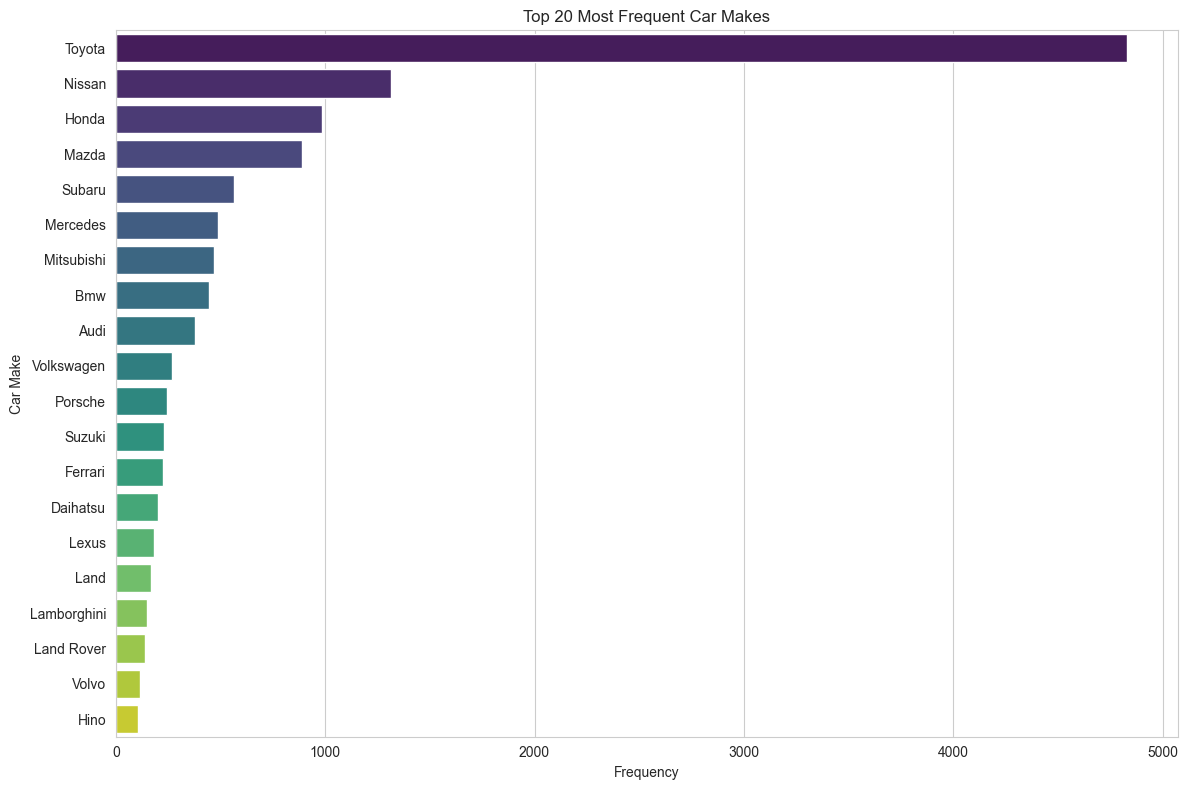


--- Relationship of Top 20 Car Makes with Log Price ---


C:\Users\maryi\AppData\Local\Temp\ipykernel_19824\4065449654.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='price_log', y='make_name_cleaned', data=plot_df_top_makes, order=ordered_makes, palette="coolwarm")


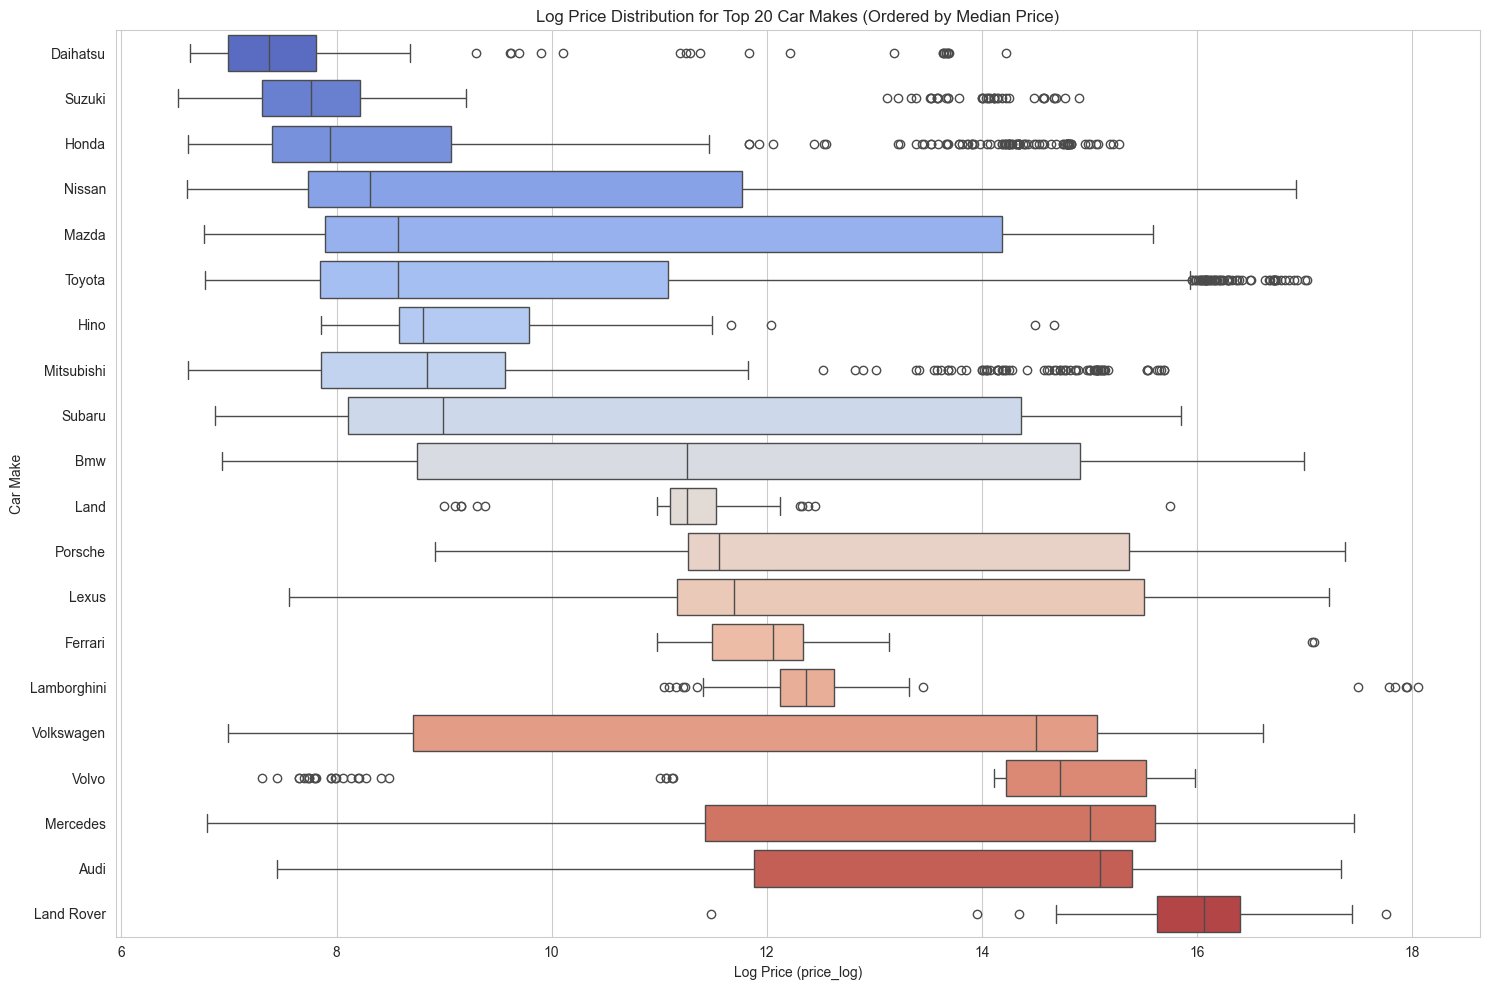

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'df' is the DataFrame with your data.
# For example:
# df = pd.read_csv('your_dataset.csv') # Replace with your actual data loading

# --- Analysis of 'make_name' ---

if 'make_name' in df.columns:
    # Convert to string and handle potential NaNs by filling with a placeholder
    df['make_name_cleaned'] = df['make_name'].astype(str).fillna('Unknown_Make')

    # 1. Distribution of Make Names (Value Counts)
    print("\n--- Distribution of Car Makes (Top 30) ---")
    make_counts = df['make_name_cleaned'].value_counts()
    print(make_counts.head(30)) # Print top 30 makes

    # Plotting top N makes for better readability
    top_n_makes = 20 # You can adjust this number
    plt.figure(figsize=(12, 8))
    # Order by count for the bar plot
    sns.countplot(y=df['make_name_cleaned'], order=df['make_name_cleaned'].value_counts().iloc[:top_n_makes].index, palette="viridis")
    plt.title(f'Top {top_n_makes} Most Frequent Car Makes')
    plt.xlabel('Frequency')
    plt.ylabel('Car Make')
    plt.tight_layout()
    plt.show()

    # 2. Relationship with price_log (Box Plots for Top N Makes)
    if 'price_log' in df.columns and pd.api.types.is_numeric_dtype(df['price_log']):
        print(f"\n--- Relationship of Top {top_n_makes} Car Makes with Log Price ---")
        
        plot_df = df.dropna(subset=['make_name_cleaned', 'price_log'])
        
        # Filter for top N makes to keep boxplot readable
        top_makes_list = make_counts.head(top_n_makes).index.tolist()
        plot_df_top_makes = plot_df[plot_df['make_name_cleaned'].isin(top_makes_list)]

        if not plot_df_top_makes.empty:
            plt.figure(figsize=(15, 10)) # Adjusted size for better readability
            
            # Order makes by median price_log for a more insightful box plot
            ordered_makes = plot_df_top_makes.groupby('make_name_cleaned')['price_log'].median().sort_values().index
            
            sns.boxplot(x='price_log', y='make_name_cleaned', data=plot_df_top_makes, order=ordered_makes, palette="coolwarm")
            plt.title(f'Log Price Distribution for Top {top_n_makes} Car Makes (Ordered by Median Price)')
            plt.xlabel('Log Price (price_log)')
            plt.ylabel('Car Make')
            plt.grid(True, axis='x')
            plt.tight_layout()
            plt.show()
        else:
            print(f"\nNo valid data points for top {top_n_makes} makes vs. price_log analysis after filtering and dropping NaNs.")
            
    else:
        print("\n'price_log' column is not available or not numeric in the DataFrame. Cannot generate relationship plots with price.")
else:
    print("Column 'make_name' not found in the DataFrame.")



Okay, we have the results for `make_name`! This is excellent for understanding the brand landscape.

Let's analyze the output and plots:

**Observations for `make_name` (Car Brand):**

1.  **Distribution of Car Makes (Value Counts & Bar Plot):**
    *   **Dominance of Japanese Brands:** The value counts and the bar plot clearly show that `Toyota` is by far the most dominant make in the dataset (4830 instances). Other Japanese brands like `Nissan` (1314), `Honda` (985), `Mazda` (890), `Subaru` (567), and `Mitsubishi` (468) are also very frequent. This aligns with the general understanding of the Kenyan used car market.
    *   **Presence of Luxury/Premium Brands:** European luxury brands such as `Mercedes` (487), `Bmw` (447), `Audi` (377), `Porsche` (243), and `Land Rover` (139) have a significant presence. High-end sports car brands like `Ferrari` (226) and `Lamborghini` (147) also appear, which is interesting and indicates a diverse dataset.
    *   **Long Tail:** There's a long tail of makes with fewer instances (e.g., `Bentley`, `Maserati`, `Aston Martin`, `Rolls Royce`, `Jaguar`, `Jeep`).
    *   **High Cardinality:** The feature `make_name` has high cardinality (many unique values). The top 30 makes are listed, but there are likely more.

2.  **Relationship of Top 20 Car Makes with `price_log` (Box Plots):**
    *   **Clear Price Differentiation by Make:** The box plots, ordered by median `price_log`, vividly illustrate that different car makes command vastly different price ranges.
        *   **Lower Median Prices:** Makes like `Daihatsu` and `Suzuki` are at the lower end of the median price spectrum.
        *   **Mid-Range Median Prices:** Common makes like `Honda`, `Nissan`, `Mazda`, `Toyota`, `Mitsubishi`, and `Subaru` occupy the middle ground, though with considerable spread.
        *   **Higher Median Prices:** Premium and luxury brands like `Bmw`, `Porsche`, `Lexus`, `Ferrari`, `Lamborghini`, `Volkswagen` (interestingly high here, perhaps specific models), `Volvo`, `Mercedes`, `Audi`, and `Land Rover` show progressively higher median `price_log` values. `Land Rover` appears to have the highest median `price_log` among the top 20 plotted.
    *   **Spread of Prices within Makes:**
        *   Some makes show a very wide spread of prices (large IQR and long whiskers), e.g., `Toyota`, `Nissan`, `Mercedes`, `Bmw`, `Subaru`, and `Volkswagen`. This is expected as these brands offer a wide range of models from economy to luxury/performance.
        *   Other makes, particularly some of the very high-end ones like `Ferrari` and `Lamborghini` (among the top 20), show a more compressed IQR but still have outliers, indicating that even within these brands, there's price variation.
    *   **The Two Price Bands are VISIBLE within individual makes:** This is a **critical observation**. If you look closely at many makes in the box plot (e.g., `Toyota`, `Nissan`, `Honda`, `Mazda`, `Subaru`, `Mercedes`, `Bmw`, `Audi`), you can often discern two somewhat distinct clusters or a bimodal tendency in their price distributions, reflected by the main body of the box and the density of outliers or the stretch of the whiskers. This strongly suggests that the banding effect we saw with numeric features is **not just due to comparing different types of makes** but is likely an **underlying systemic factor (like currency or distinct import/local market segments with different pricing scales) affecting prices *within* the same make.**

**Implications & Notes for Later Stages:**

*   **Feature Engineering for `make_name`:**
    *   Due to the high cardinality, we will likely need to group less frequent makes into an "Other" category during feature engineering (Step 1.4). The threshold for "less frequent" will need to be chosen carefully.
    *   Target encoding could be an option, but it must be implemented very carefully (e.g., within cross-validation folds) to prevent data leakage.
*   **Importance of `make_name`:** This feature is clearly a very strong predictor of price.
*   **Addressing the Price Bands:** The observation that the two price bands persist *within* individual makes is highly significant. It reinforces that this isn't just about "cheap brands vs. expensive brands." There's likely a more fundamental data issue or market segmentation (e.g., KSh vs. USD prices not fully harmonized, or local vs. fresh import pricing differences) that needs to be resolved in the data cleaning/preprocessing phase. This is a top priority. If `currency_code` was intended to solve this but the cleaning wasn't fully effective, we may need to revisit that.

This is very insightful! Now, let's move to the next categorical feature: `model_name`. This is expected to have even higher cardinality than `make_name`.




--- Distribution of Car Models (Top 30) ---
model_name_cleaned
Fit               319
Vitz              314
Ractis            277
Land Cruiser      247
Note              235
Demio             196
Cx5               189
Xtrail            182
Forester          178
Harrier           166
Wish              160
Voxy              138
Alphard           135
Noah              135
Canter Truck      125
Gt-R              102
Crown             101
Sienta            100
Alphard Hybrid     99
Cayenne            99
Mark X             95
Defender           92
Vellfire           86
Vanguard           84
Skyline            81
Juke               80
Allion             77
Premio             77
Q5                 75
Probox Van         74
Name: count, dtype: int64

Total unique car models: 999


C:\Users\maryi\AppData\Local\Temp\ipykernel_19824\1199939223.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df['model_name_cleaned'], order=df['model_name_cleaned'].value_counts().iloc[:top_n_models].index, palette="crest")


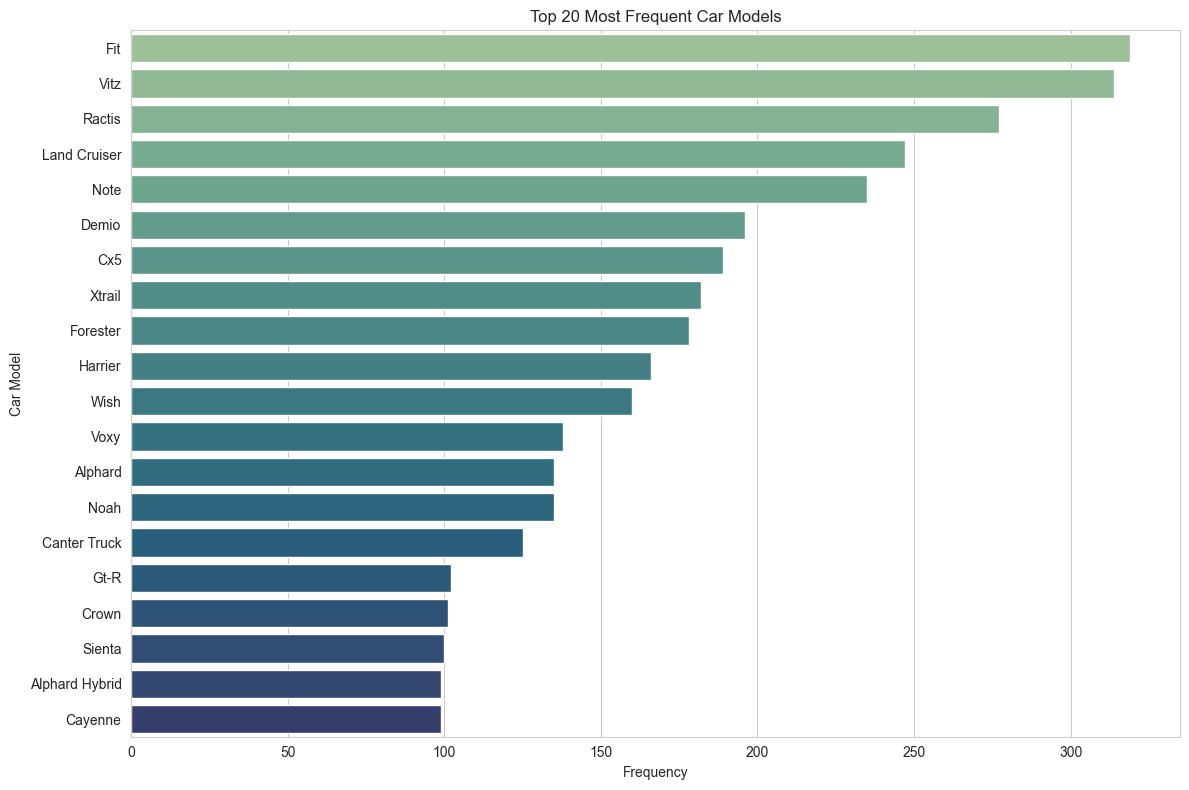


--- Relationship of Top 20 Car Models with Log Price ---


C:\Users\maryi\AppData\Local\Temp\ipykernel_19824\1199939223.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='price_log', y='model_name_cleaned', data=plot_df_top_models, order=ordered_models, palette="magma")


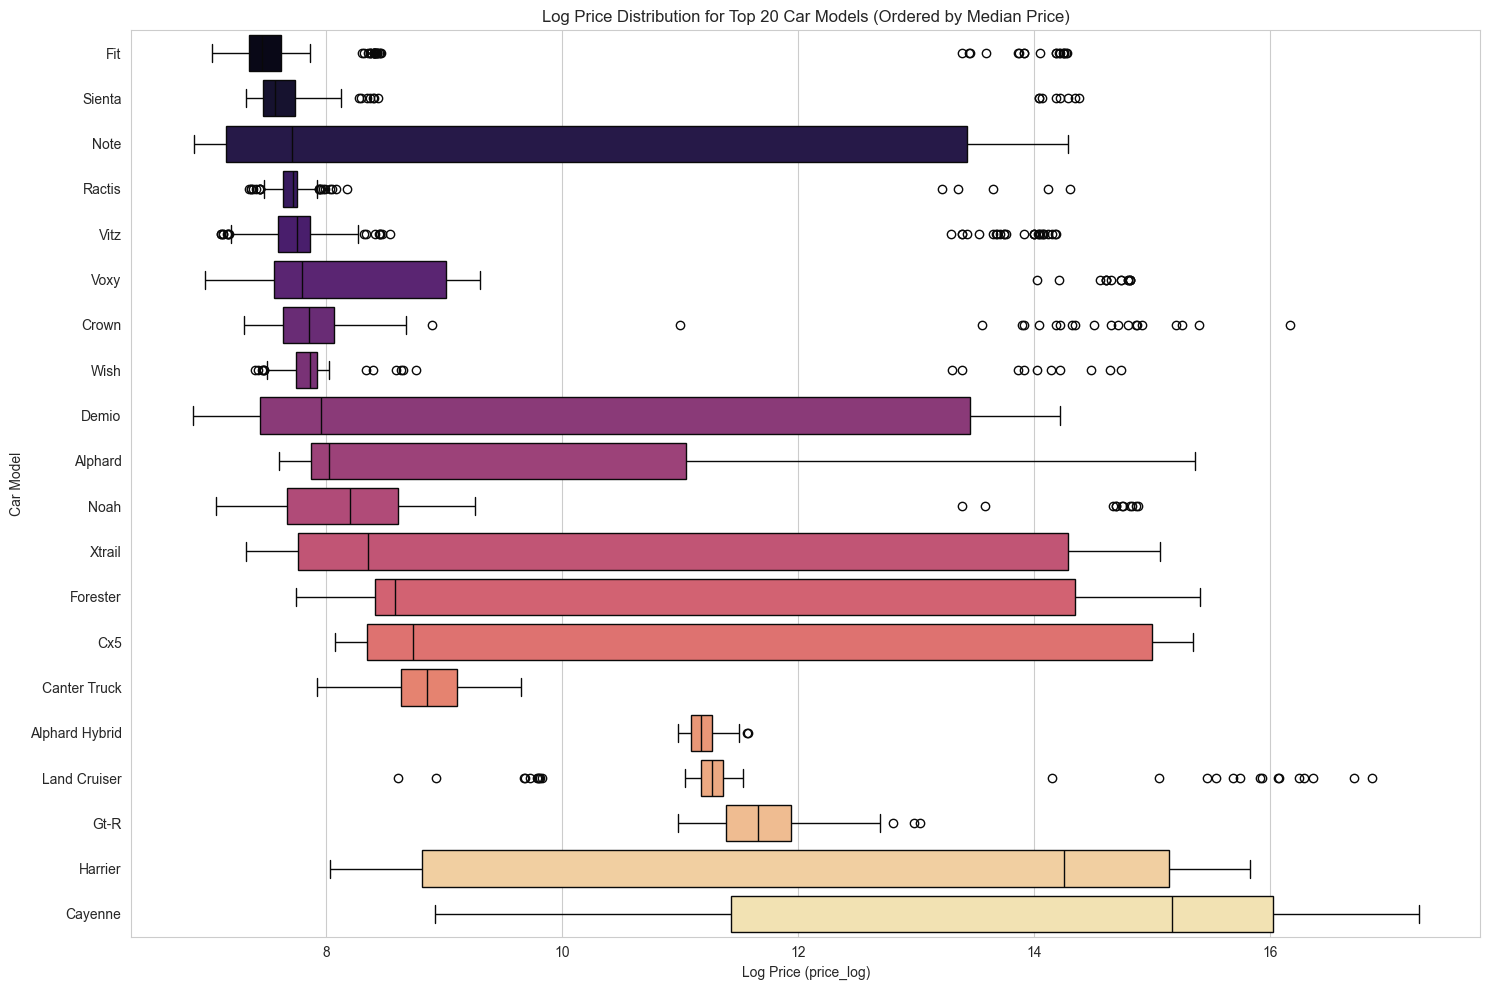

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'df' is the DataFrame with your data.

# --- Analysis of 'model_name' ---

if 'model_name' in df.columns:
    # Convert to string and handle potential NaNs by filling with a placeholder
    df['model_name_cleaned'] = df['model_name'].astype(str).fillna('Unknown_Model')

    # 1. Distribution of Model Names (Value Counts)
    print("\n--- Distribution of Car Models (Top 30) ---")
    model_counts = df['model_name_cleaned'].value_counts()
    print(model_counts.head(30)) # Print top 30 models
    print(f"\nTotal unique car models: {df['model_name_cleaned'].nunique()}")


    # Plotting top N models for better readability
    top_n_models = 20 # Adjust as needed
    plt.figure(figsize=(12, 8))
    sns.countplot(y=df['model_name_cleaned'], order=df['model_name_cleaned'].value_counts().iloc[:top_n_models].index, palette="crest")
    plt.title(f'Top {top_n_models} Most Frequent Car Models')
    plt.xlabel('Frequency')
    plt.ylabel('Car Model')
    plt.tight_layout()
    plt.show()

    # 2. Relationship with price_log (Box Plots for Top N Models)
    # This can be very noisy due to high cardinality, so we focus on the most frequent ones.
    if 'price_log' in df.columns and pd.api.types.is_numeric_dtype(df['price_log']):
        print(f"\n--- Relationship of Top {top_n_models} Car Models with Log Price ---")
        
        plot_df = df.dropna(subset=['model_name_cleaned', 'price_log'])
        
        # Filter for top N models to keep boxplot readable
        top_models_list = model_counts.head(top_n_models).index.tolist()
        plot_df_top_models = plot_df[plot_df['model_name_cleaned'].isin(top_models_list)]

        if not plot_df_top_models.empty:
            plt.figure(figsize=(15, 10)) # Adjusted size
            
            # Order models by median price_log for a more insightful box plot
            ordered_models = plot_df_top_models.groupby('model_name_cleaned')['price_log'].median().sort_values().index
            
            sns.boxplot(x='price_log', y='model_name_cleaned', data=plot_df_top_models, order=ordered_models, palette="magma")
            plt.title(f'Log Price Distribution for Top {top_n_models} Car Models (Ordered by Median Price)')
            plt.xlabel('Log Price (price_log)')
            plt.ylabel('Car Model')
            plt.grid(True, axis='x')
            plt.tight_layout()
            plt.show()
        else:
            print(f"\nNo valid data points for top {top_n_models} models vs. price_log analysis after filtering and dropping NaNs.")
            
    else:
        print("\n'price_log' column is not available or not numeric in the DataFrame. Cannot generate relationship plots with price.")
else:
    print("Column 'model_name' not found in the DataFrame.")


This is great! We have the results for `model_name`. As expected, this feature has very high cardinality.

Let's analyze the output and plots:

**Observations for `model_name` (Car Model):**

1.  **Distribution of Car Models (Value Counts & Bar Plot):**
    *   **High Cardinality:** The output confirms `Total unique car models: 999`. This is a very large number of unique categories.
    *   **Most Frequent Models:** The bar plot and value counts show the top 20 most frequent models.
        *   Smaller, often economical cars like `Fit` (Honda Fit), `Vitz` (Toyota Vitz), `Ractis` (Toyota Ractis), `Note` (Nissan Note), and `Demio` (Mazda Demio) are among the most common.
        *   Popular SUVs and larger vehicles like `Land Cruiser` (Toyota), `Cx5` (Mazda), `Xtrail` (Nissan), `Forester` (Subaru), and `Harrier` (Toyota) are also frequent.
        *   Family movers/vans like `Wish`, `Voxy`, `Alphard`, `Noah`, `Sienta` (all typically Toyota) appear often.
        *   Specialized vehicles like `Canter Truck` (Mitsubishi Fuso), performance models like `Gt-R` (Nissan), and luxury models like `Cayenne` (Porsche) are also in the top 20, indicating the dataset's diversity.
    *   **Long Tail:** Similar to `make_name`, there's a very long tail of models that appear much less frequently (999 unique models in total, with the 30th most frequent, `Probox Van`, having 74 instances).

2.  **Relationship of Top 20 Car Models with `price_log` (Box Plots):**
    *   **Clear Price Differentiation by Model:** The box plots (ordered by median `price_log`) clearly show that different car models have distinct price distributions, even within the same make sometimes.
        *   **Lower Median Prices:** Models like `Fit`, `Sienta`, `Note`, `Ractis`, and `Vitz` are at the lower end of the median price spectrum.
        *   **Mid-Range Median Prices:** A variety of models like `Voxy`, `Crown`, `Wish`, `Demio`, `Alphard`, `Noah`, `Xtrail`, `Forester`, and `Cx5` occupy the middle ground with varying price spreads.
        *   **Higher Median Prices:** Trucks (`Canter Truck`), specific hybrid versions (`Alphard Hybrid`), luxury SUVs/performance cars (`Land Cruiser`, `Gt-R`, `Harrier`, `Cayenne`) show higher median `price_log` values. `Cayenne` has the highest median price among the plotted top 20.
    *   **Spread of Prices within Models:**
        *   Many models exhibit a wide range of prices (large IQR or long whiskers). For example, `Note`, `Demio`, `Xtrail`, `Forester`, `Cx5`, `Harrier`, and `Cayenne` show considerable price variation. This could be due to different model years, conditions, trims, or mileage within the same model name.
        *   Some models have a relatively tighter IQR, like `Fit` or `Sienta` at the lower price end.
    *   **The Two Price Bands Persist *within* Car Models:** This is a **critical and recurring observation**. Looking closely at the box plots for many individual models (e.g., `Note`, `Vitz`, `Demio`, `Wish`, `Noah`, `Xtrail`, `Forester`, `Cx5`, `Harrier`), you can often see the bimodal distribution or the two distinct clusters in `price_log`. This strongly reinforces that the underlying systemic factor causing this banding (likely currency or distinct market segments) affects prices *even at the specific model level*.

**Implications & Notes for Later Stages:**

*   **Feature Engineering for `model_name`:**
    *   This is the most challenging categorical feature due to its extremely high cardinality (999 unique values).
    *   **Grouping:** We will almost certainly need to group many of the less frequent models into an "Other_Model" category. Deciding the threshold for this grouping will be important.
    *   **Interaction with `make_name`:** `model_name` is often specific to a `make_name`. Creating interaction features (e.g., "Toyota\_Camry") or using `make_name` to help group `model_name` might be useful, though this can further increase cardinality if not done carefully.
    *   **Advanced Techniques:** For very high cardinality features like this, more advanced techniques like embedding layers (if using neural networks) or sophisticated target encoding strategies might be considered, but require careful implementation to avoid overfitting and data leakage. For tree-based models, they can sometimes handle high cardinality features directly, but performance can suffer, and interpretability becomes harder.
*   **Importance of `model_name`:** Despite its complexity, `model_name` is a very strong predictor of price.
*   **Reiteration on Price Bands:** The fact that the two distinct price bands are visible *even within individual model categories* is a powerful indicator. This strongly suggests a systemic data issue or market segmentation (e.g., KSh vs. USD prices not correctly or fully harmonized, or significant price differences between locally used and freshly imported versions of the *same model*) that needs to be thoroughly investigated and addressed in the data cleaning/preprocessing phase. This remains a top-priority action item.

The high cardinality of `model_name` and the persistent price banding are key challenges we'll need to tackle strategically.





--- Distribution of Fuel Types ---
fuel_type_cleaned
Petrol                    9903
Diesel                    1655
Hybrid(Petrol)             980
Petroleum                  245
Petrol Hybrid              160
Hybrid(Diesel)              85
Plug-In Hybrid(Petrol)      25
Electric                     5
nan                          5
Hybrid                       4
Diesel Hybrid                2
Name: count, dtype: int64


C:\Users\maryi\AppData\Local\Temp\ipykernel_19824\725544304.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df['fuel_type_cleaned'], order=df['fuel_type_cleaned'].value_counts().index, palette="viridis_r") # Reversed palette


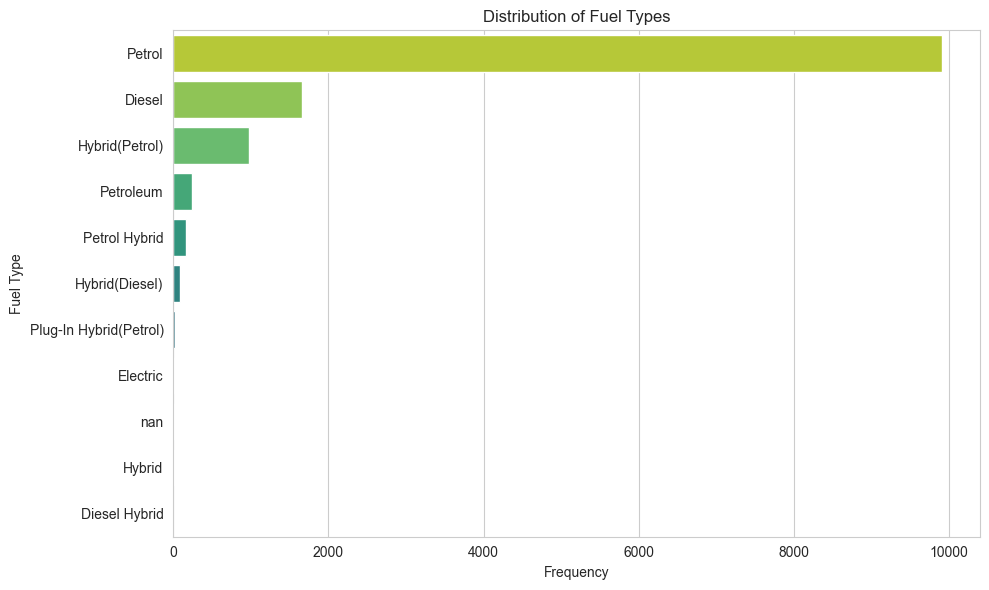


--- Relationship of Fuel Type with Log Price ---


C:\Users\maryi\AppData\Local\Temp\ipykernel_19824\725544304.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='price_log', y='fuel_type_cleaned', data=plot_df, order=ordered_fuel_types, palette="rocket")


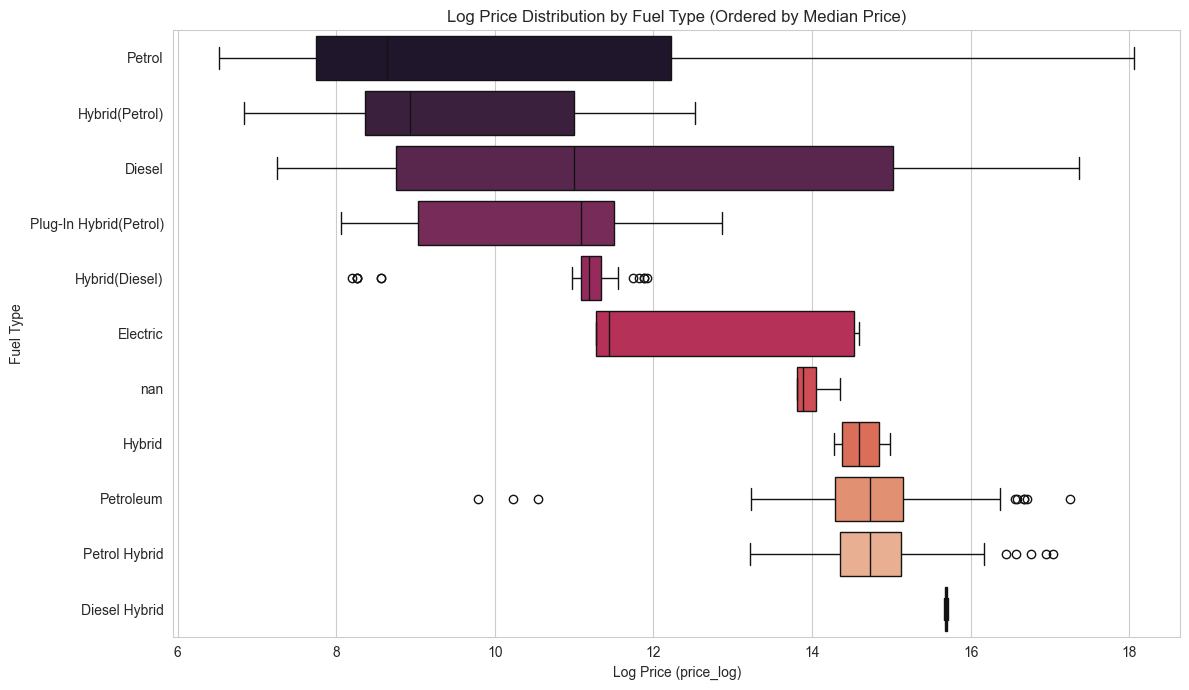

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'df' is the DataFrame with your data.

# --- Analysis of 'fuel_type' ---

if 'fuel_type' in df.columns:
    # Convert to string and handle potential NaNs by filling with a placeholder
    df['fuel_type_cleaned'] = df['fuel_type'].astype(str).fillna('Unknown_Fuel')

    # 1. Distribution of Fuel Types (Value Counts)
    print("\n--- Distribution of Fuel Types ---")
    fuel_counts = df['fuel_type_cleaned'].value_counts()
    print(fuel_counts)

    plt.figure(figsize=(10, 6))
    sns.countplot(y=df['fuel_type_cleaned'], order=df['fuel_type_cleaned'].value_counts().index, palette="viridis_r") # Reversed palette
    plt.title('Distribution of Fuel Types')
    plt.xlabel('Frequency')
    plt.ylabel('Fuel Type')
    plt.tight_layout()
    plt.show()

    # 2. Relationship with price_log (Box Plots)
    if 'price_log' in df.columns and pd.api.types.is_numeric_dtype(df['price_log']):
        print("\n--- Relationship of Fuel Type with Log Price ---")
        
        plot_df = df.dropna(subset=['fuel_type_cleaned', 'price_log'])
        
        if not plot_df.empty:
            plt.figure(figsize=(12, 7))
            
            # Order fuel types by median price_log
            ordered_fuel_types = plot_df.groupby('fuel_type_cleaned')['price_log'].median().sort_values().index
            
            sns.boxplot(x='price_log', y='fuel_type_cleaned', data=plot_df, order=ordered_fuel_types, palette="rocket")
            plt.title('Log Price Distribution by Fuel Type (Ordered by Median Price)')
            plt.xlabel('Log Price (price_log)')
            plt.ylabel('Fuel Type')
            plt.grid(True, axis='x')
            plt.tight_layout()
            plt.show()
        else:
            print("\nNo valid data points for fuel type vs. price_log analysis after dropping NaNs.")
            
    else:
        print("\n'price_log' column is not available or not numeric in the DataFrame. Cannot generate relationship plots with price.")
else:
    print("Column 'fuel_type' not found in the DataFrame.")


Perfect, we have the results for `fuel_type`.

Let's analyze this output:

**Observations for `fuel_type`:**

1.  **Distribution of Fuel Types (Value Counts & Bar Plot):**
    *   **Dominance of Petrol:** `Petrol` is by far the most common fuel type, with 9903 instances.
    *   **Significant Diesel Presence:** `Diesel` is the second most common, with 1655 instances.
    *   **Growing Hybrid Categories:** `Hybrid(Petrol)` is notable with 980 instances. Other hybrid variations like `Petrol Hybrid` (160) and `Hybrid(Diesel)` (85) also appear.
    *   **Minor Categories & Potential Synonyms/Cleaning Needed:**
        *   `Petroleum` (245 instances) is likely a synonym for `Petrol` and should probably be consolidated.
        *   `Petrol Hybrid` (160) and `Hybrid(Petrol)` (980) might represent the same concept and could potentially be merged, or there might be a subtle distinction intended (e.g., one indicating a stronger reliance on the hybrid system). This needs clarification. The same applies to `Hybrid(Diesel)` and `Diesel Hybrid`.
        *   `Plug-In Hybrid(Petrol)` is a distinct and growing category, though still small (25 instances).
        *   `Electric` cars are present but very rare (5 instances).
        *   `nan` (5 instances): These are the actual missing values that were converted to the string 'nan'.
        *   `Hybrid` (4 instances): This is a generic "Hybrid" category and might be hard to distinguish without more info. Could potentially be merged with the dominant hybrid type or treated as 'Unknown_Hybrid'.
        *   `Diesel Hybrid` (2 instances): Very rare.

2.  **Relationship of Fuel Type with `price_log` (Box Plots):**
    *   **Price Differentiation by Fuel Type:** The box plots (ordered by median `price_log`) show clear differences in price distributions across fuel types.
        *   **`Petrol`:** Forms the baseline for the lower median price range.
        *   **`Hybrid(Petrol)`:** Has a slightly higher median `price_log` than `Petrol`, and its distribution is also quite broad.
        *   **`Diesel`:** Shows a significantly higher median `price_log` compared to `Petrol` and `Hybrid(Petrol)`. Diesel vehicles, especially for larger cars or commercial vehicles, can be more expensive.
        *   **`Plug-In Hybrid(Petrol)`:** Appears to have a median price similar to or slightly higher than `Diesel`.
        *   **`Hybrid(Diesel)`:** Shows a relatively high median price, though with fewer data points.
        *   **`Electric`:** Has a high median `price_log`, which is expected for newer technology, but the sample size is very small (5 cars), so this is not very robust.
        *   **`nan` (missing fuel type):** These cars have a surprisingly high median `price_log`. This could be an anomaly due to the small sample size or specific types of cars where fuel type was missed.
        *   **`Hybrid` (generic):** Also has a high median price.
        *   **`Petroleum`:** Its median `price_log` is similar to `Diesel` and `Plug-In Hybrid(Petrol)`. If this is indeed a synonym for Petrol, this price difference would be an anomaly.
        *   **`Petrol Hybrid` and `Diesel Hybrid`:** Their median prices are also in the higher range.
    *   **The Two Price Bands are Evident:** Crucially, within several of the more common fuel type categories (e.g., `Petrol`, `Hybrid(Petrol)`, `Diesel`), the **two distinct price bands are clearly visible** in the spread of the data points shown by the box plot whiskers and outliers. This again confirms that the underlying systemic factor (currency, market segment) influences prices even when controlling for fuel type.

**Implications & Notes for Later Stages:**

*   **Data Cleaning for `fuel_type` (High Priority):**
    *   **Consolidate Synonyms:**
        *   `Petroleum` should likely be merged with `Petrol`.
        *   Decide on a consistent naming convention for hybrids: `Hybrid(Petrol)` and `Petrol Hybrid` should probably be merged. Similarly for `Hybrid(Diesel)` and `Diesel Hybrid`.
    *   **Handle `nan`:** The 5 `nan` (missing) values need imputation or specific handling. Given their surprisingly high median price, simple mode imputation might not be ideal without further investigation.
    *   **Generic `Hybrid`:** Decide how to treat the generic `Hybrid` category.
*   **Feature Engineering:** After cleaning, `fuel_type` will be a relatively low-cardinality categorical feature and can be one-hot encoded.
*   **Importance of `fuel_type`:** Fuel type is an important predictor of price, with Diesel and various Hybrid/Electric types generally associated with higher prices than standard Petrol.
*   **Reiteration on Price Bands:** The persistence of the two price bands within fuel categories underscores the need to address this systemic issue.

This analysis of `fuel_type` highlights the importance of careful data cleaning for categorical features.





--- Distribution of Transmission Types ---
transmission_cleaned
At           8700
Automatic    3355
Mt            680
6Mt           121
5Mt            85
Manual         65
nan            21
7Mt            21
Duonic         15
Smoother        3
Proshift        2
4Mt             1
Name: count, dtype: int64


C:\Users\maryi\AppData\Local\Temp\ipykernel_19824\1577985010.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df['transmission_cleaned'], order=df['transmission_cleaned'].value_counts().index, palette="cubehelix")


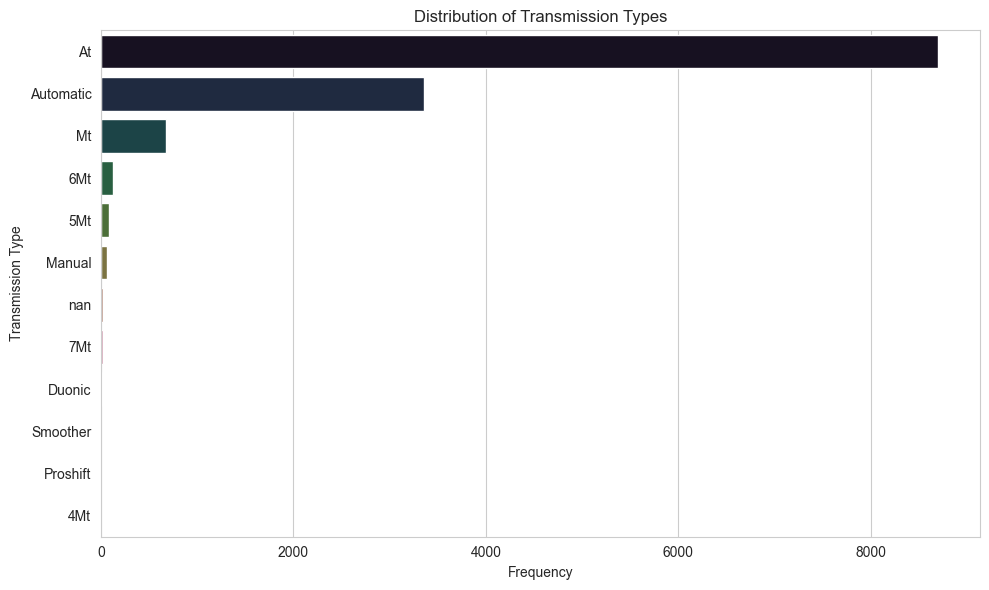


--- Relationship of Transmission Type with Log Price ---


C:\Users\maryi\AppData\Local\Temp\ipykernel_19824\1577985010.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='price_log', y='transmission_cleaned', data=plot_df, order=ordered_transmission_types, palette="Spectral")


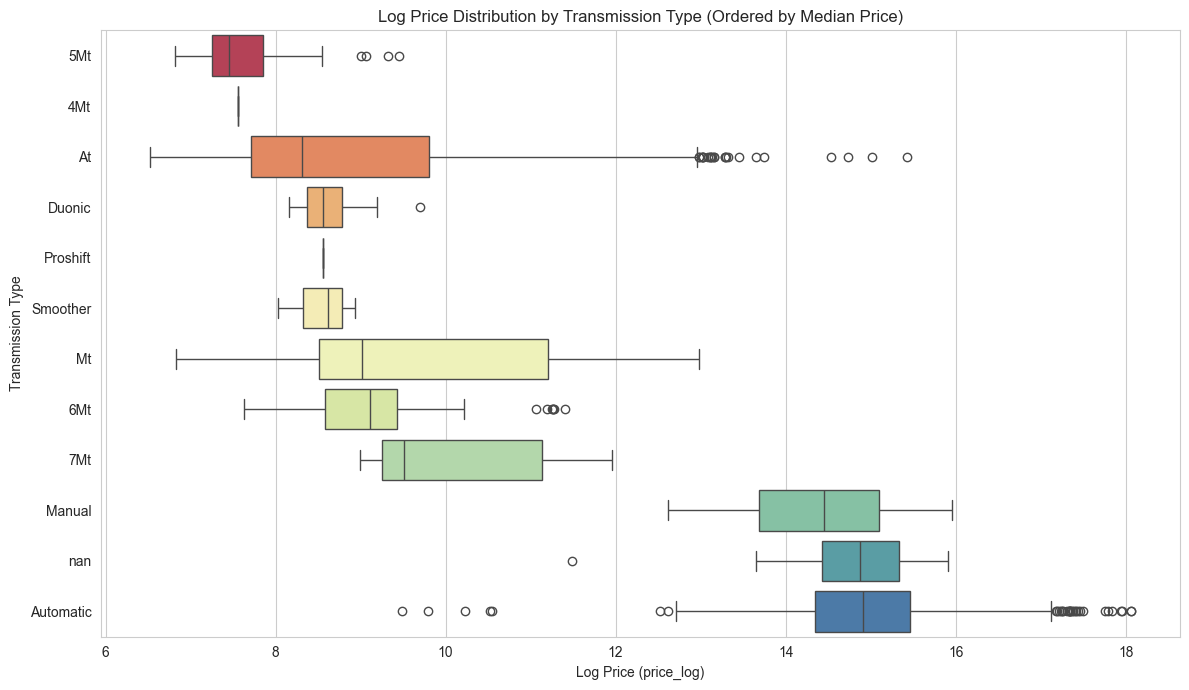

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'df' is the DataFrame with your data.

# --- Analysis of 'transmission' ---

if 'transmission' in df.columns:
    # Convert to string and handle potential NaNs by filling with a placeholder
    df['transmission_cleaned'] = df['transmission'].astype(str).fillna('Unknown_Transmission')

    # 1. Distribution of Transmission Types (Value Counts)
    print("\n--- Distribution of Transmission Types ---")
    transmission_counts = df['transmission_cleaned'].value_counts()
    print(transmission_counts)

    plt.figure(figsize=(10, 6))
    sns.countplot(y=df['transmission_cleaned'], order=df['transmission_cleaned'].value_counts().index, palette="cubehelix")
    plt.title('Distribution of Transmission Types')
    plt.xlabel('Frequency')
    plt.ylabel('Transmission Type')
    plt.tight_layout()
    plt.show()

    # 2. Relationship with price_log (Box Plots)
    if 'price_log' in df.columns and pd.api.types.is_numeric_dtype(df['price_log']):
        print("\n--- Relationship of Transmission Type with Log Price ---")
        
        plot_df = df.dropna(subset=['transmission_cleaned', 'price_log'])
        
        if not plot_df.empty:
            plt.figure(figsize=(12, 7))
            
            # Order transmission types by median price_log
            ordered_transmission_types = plot_df.groupby('transmission_cleaned')['price_log'].median().sort_values().index
            
            sns.boxplot(x='price_log', y='transmission_cleaned', data=plot_df, order=ordered_transmission_types, palette="Spectral")
            plt.title('Log Price Distribution by Transmission Type (Ordered by Median Price)')
            plt.xlabel('Log Price (price_log)')
            plt.ylabel('Transmission Type')
            plt.grid(True, axis='x')
            plt.tight_layout()
            plt.show()
        else:
            print("\nNo valid data points for transmission type vs. price_log analysis after dropping NaNs.")
            
    else:
        print("\n'price_log' column is not available or not numeric in the DataFrame. Cannot generate relationship plots with price.")
else:
    print("Column 'transmission' not found in the DataFrame.")



Okay, we have the results for `transmission`. Let's dive into what these plots and numbers tell us.

**Observations for `transmission`:**

1.  **Distribution of Transmission Types (Value Counts & Bar Plot):**
    *   **Dominance of Automatics:** `At` (presumably Automatic Transmission) is the most dominant category with 8700 instances. `Automatic` is the second most common with 3355 instances. These two likely refer to the same concept and should be consolidated.
    *   **Manual Transmissions:** `Mt` (presumably Manual Transmission) has 680 instances. `Manual` has 65 instances. Specific speed manuals like `6Mt` (121), `5Mt` (85), `7Mt` (21), and `4Mt` (1) also appear. These categories (Mt, Manual, and specific speed manuals) should likely be consolidated into a single 'Manual' category.
    *   **Specialized/Other Transmissions:** Categories like `Duonic` (15), `Smoother` (3), and `Proshift` (2) are present but rare. These might be specific types of automated manual transmissions or other advanced systems.
    *   **Missing Values:** `nan` (21 instances) represents missing transmission information.

2.  **Relationship of Transmission Type with `price_log` (Box Plots):**
    *   **Price Differentiation by Transmission Type:** The box plots (ordered by median `price_log`) show distinct price patterns.
        *   **Lower Median Prices:** `5Mt` and `4Mt` (manual transmissions with specific gear counts) appear at the very low end of the median price spectrum, though `4Mt` has only one data point so it's not robust.
        *   **`At` (Automatic):** Has a wide price distribution, occupying a lower-to-mid range of median prices.
        *   **`Duonic`, `Proshift`, `Smoother`:** These specialized (and rare) transmissions show varied median prices. `Duonic` and `Proshift` are in the lower-mid range, while `Smoother` is slightly higher.
        *   **`Mt` (Manual):** Also has a broad price distribution, with a median `price_log` that seems somewhat comparable to or slightly higher than the main cluster of `At`.
        *   **`6Mt` and `7Mt`:** These multi-gear manuals have higher median prices than `5Mt`, with `7Mt` being notably higher. This might indicate they are found in more performance-oriented or newer vehicles.
        *   **`Manual` (generic):** Shows a relatively high median `price_log`.
        *   **`nan` (missing):** These vehicles have a surprisingly high median `price_log`, similar to some of the higher-priced manual and automatic categories.
        *   **`Automatic` (explicit):** This category shows the highest median `price_log` among all listed. This is interesting, especially if `At` also means automatic. It suggests the explicit "Automatic" label might be used for cars that are generally in a higher price bracket.
    *   **The Two Price Bands are Very Evident:** This is a crucial observation. Within the most common categories like `At`, `Automatic`, and `Mt`, the **two distinct horizontal price bands are clearly visible**. This provides further strong evidence that the underlying systemic factor (currency, market segment) affects prices significantly, even when considering different transmission types.

**Implications & Notes for Later Stages:**

*   **Data Cleaning for `transmission` (High Priority):**
    *   **Consolidate Synonyms:**
        *   `At` and `Automatic` must be investigated and likely merged. The difference in their median prices is notable and needs understanding. Perhaps one is a default/less specific entry.
        *   `Mt`, `Manual`, `4Mt`, `5Mt`, `6Mt`, `7Mt` should likely be consolidated into a single "Manual" category, or perhaps into "Manual" and "Manual (Specific Speed)" if the gear count consistently differentiates price/vehicle type. For simplicity, a single "Manual" is often a good start.
    *   **Handle Rare/Specialized Types:** For `Duonic`, `Smoother`, `Proshift`, due to their rarity, they might need to be grouped into an "Other_Transmission" category or carefully considered if they represent high-value niche vehicles.
    *   **Handle `nan`:** The 21 `nan` (missing) values need imputation or a distinct category. Their high median price suggests they aren't just random low-value cars.
*   **Feature Engineering:** After cleaning, `transmission` will be a key categorical feature for one-hot encoding. The primary categories will likely be "Automatic" and "Manual", possibly with an "Other" or "Unknown".
*   **Importance of `transmission`:** Transmission type is an important price predictor. Generally, automatic transmissions can be associated with higher prices or comfort/luxury models, while manual transmissions might be found in a wider range, including performance cars or base models. The specifics in this dataset are interesting.
*   **Reiteration on Price Bands:** The persistence of the two price bands within transmission categories is a recurring theme and needs to be addressed.




--- Distribution of Drive Types ---
drive_type_cleaned
2WD       7711
4WD       3615
AWD       1070
FR         187
nan        155
FF         155
MR         150
FWD         20
RWD          3
RR           2
04-FEB       1
Name: count, dtype: int64


C:\Users\maryi\AppData\Local\Temp\ipykernel_19824\1557462370.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df['drive_type_cleaned'], order=df['drive_type_cleaned'].value_counts().index, palette="ocean_r")


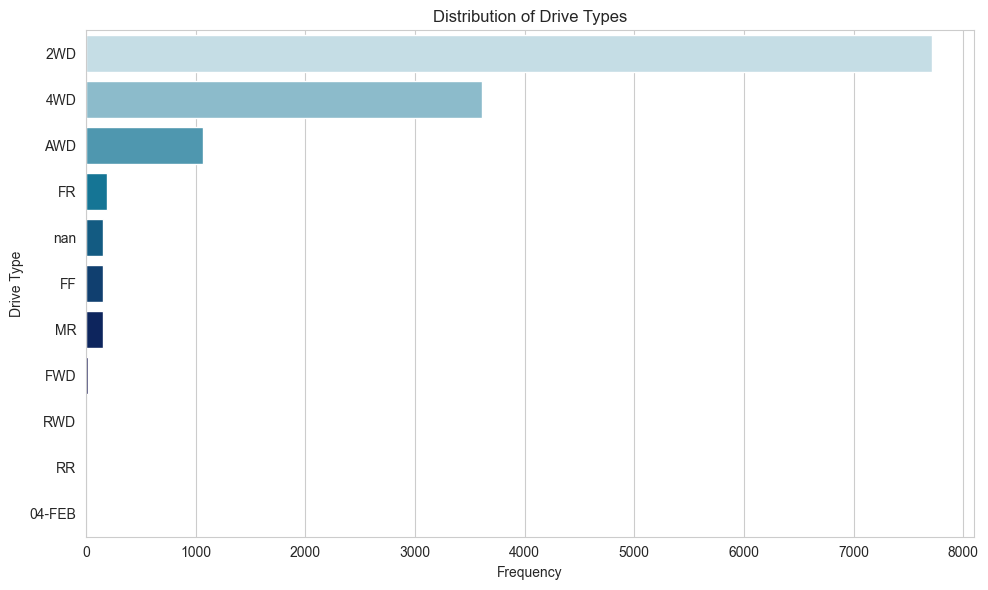


--- Relationship of Drive Type with Log Price ---


C:\Users\maryi\AppData\Local\Temp\ipykernel_19824\1557462370.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='price_log', y='drive_type_cleaned', data=plot_df, order=ordered_drive_types, palette="terrain")


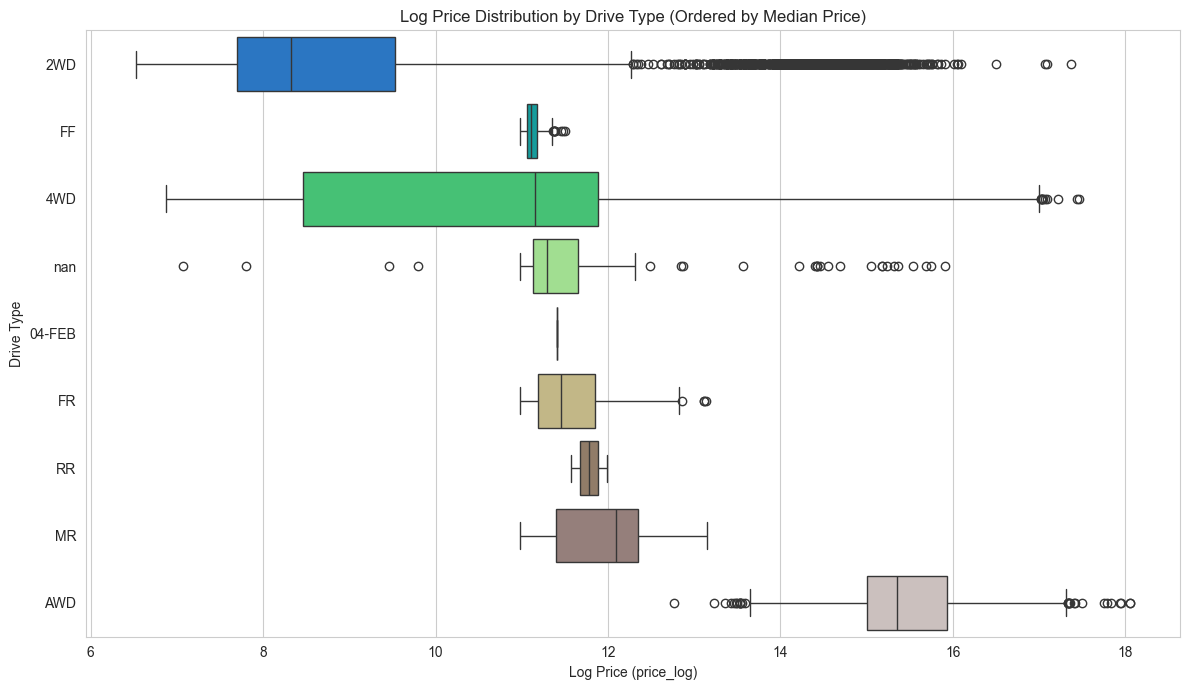

In [15]:
# The way `At` and `Automatic` are priced differently, despite likely meaning the same thing, is particularly noteworthy and warrants investigation during the detailed data cleaning phase.

# Next up is `drive_type`.

# Here's the Python script to analyze `drive_type`:

# ```python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'df' is the DataFrame with your data.

# --- Analysis of 'drive_type' ---

if 'drive_type' in df.columns:
    # Convert to string and handle potential NaNs by filling with a placeholder
    df['drive_type_cleaned'] = df['drive_type'].astype(str).fillna('Unknown_Drive')

    # 1. Distribution of Drive Types (Value Counts)
    print("\n--- Distribution of Drive Types ---")
    drive_type_counts = df['drive_type_cleaned'].value_counts()
    print(drive_type_counts)

    plt.figure(figsize=(10, 6))
    sns.countplot(y=df['drive_type_cleaned'], order=df['drive_type_cleaned'].value_counts().index, palette="ocean_r")
    plt.title('Distribution of Drive Types')
    plt.xlabel('Frequency')
    plt.ylabel('Drive Type')
    plt.tight_layout()
    plt.show()

    # 2. Relationship with price_log (Box Plots)
    if 'price_log' in df.columns and pd.api.types.is_numeric_dtype(df['price_log']):
        print("\n--- Relationship of Drive Type with Log Price ---")
        
        plot_df = df.dropna(subset=['drive_type_cleaned', 'price_log'])
        
        if not plot_df.empty:
            plt.figure(figsize=(12, 7))
            
            # Order drive types by median price_log
            ordered_drive_types = plot_df.groupby('drive_type_cleaned')['price_log'].median().sort_values().index
            
            sns.boxplot(x='price_log', y='drive_type_cleaned', data=plot_df, order=ordered_drive_types, palette="terrain")
            plt.title('Log Price Distribution by Drive Type (Ordered by Median Price)')
            plt.xlabel('Log Price (price_log)')
            plt.ylabel('Drive Type')
            plt.grid(True, axis='x')
            plt.tight_layout()
            plt.show()
        else:
            print("\nNo valid data points for drive type vs. price_log analysis after dropping NaNs.")
            
    else:
        print("\n'price_log' column is not available or not numeric in the DataFrame. Cannot generate relationship plots with price.")
else:
    print("Column 'drive_type' not found in the DataFrame.")


Okay, we have the results for `drive_type`. This is another important feature that often relates to vehicle capability and price.

Let's analyze the output:

**Observations for `drive_type`:**

1.  **Distribution of Drive Types (Value Counts & Bar Plot):**
    *   **Dominance of 2WD:** `2WD` (Two-Wheel Drive) is the most common drive type by a large margin, with 7711 instances.
    *   **Significant 4WD/AWD Presence:** `4WD` (Four-Wheel Drive) is the second most common with 3615 instances, and `AWD` (All-Wheel Drive) also has a substantial number with 1070 instances.
    *   **Other Drive Types:**
        *   `FR` (Front-engine, Rear-wheel drive) has 187 instances.
        *   `FF` (Front-engine, Front-wheel drive) has 155 instances. (Note: `2WD` often implies `FF` for most common cars or `FR` for some sedans/trucks. The distinction here is interesting).
        *   `MR` (Mid-engine, Rear-wheel drive) has 150 instances, typically associated with sports cars.
        *   `FWD` (Front-Wheel Drive) has 20 instances. This is likely a more specific version of `FF` or `2WD`.
        *   `RWD` (Rear-Wheel Drive) is very rare (3 instances).
        *   `RR` (Rear-engine, Rear-wheel drive) is very rare (2 instances), associated with specific sports cars (like older Porsche 911s) or some very small city cars.
    *   **Missing Values:** `nan` (155 instances) represents missing drive type information.
    *   **Data Quality Issue:** `04-FEB` (1 instance) is clearly a data error and not a valid drive type.

2.  **Relationship of Drive Type with `price_log` (Box Plots):**
    *   **Price Differentiation by Drive Type:** The box plots (ordered by median `price_log`) show clear price differences.
        *   **`2WD`:** Shows a very wide price distribution, covering both price bands, with its median in the lower of the two main price segments.
        *   **`FF` (Front-engine, Front-wheel drive):** Has a relatively low median `price_log`, situated within the lower price band.
        *   **`4WD`:** Also has a very wide price distribution, spanning both major price bands. Its median `price_log` is higher than `2WD`'s overall median.
        *   **`nan` (missing):** These vehicles have a median `price_log` that sits between the typical `2WD` and `4WD` medians, mainly in the lower price band.
        *   **`04-FEB` (Error):** This single data point has a median price in the lower-mid range. It needs to be removed or corrected.
        *   **`FR` (Front-engine, Rear-wheel drive):** Shows a higher median `price_log` than `FF`, and its distribution also spans both price bands.
        *   **`RR` (Rear-engine, Rear-wheel drive):** Has a high median `price_log`, but with only 2 data points, this is not robust.
        *   **`MR` (Mid-engine, Rear-wheel drive):** Also shows a high median `price_log`, consistent with sports car pricing.
        *   **`AWD` (All-Wheel Drive):** Commands the highest median `price_log` among all drive types. Its distribution is primarily in the upper price band.
    *   **The Two Price Bands Persist:** Once again, for the more common drive types like `2WD`, `4WD`, `AWD`, and `FR`, the **two distinct horizontal price bands are clearly visible**. This pattern is incredibly consistent across all features we've examined that have a continuous price spread.

**Implications & Notes for Later Stages:**

*   **Data Cleaning for `drive_type` (High Priority):**
    *   **Consolidate Synonyms/Related Categories:**
        *   `2WD`, `FF`, and `FWD` need careful consideration. `FF` and `FWD` are specific types of `2WD`. Decide whether to keep the specific distinctions or group them. For many common cars, `2WD` defaults to `FF`. If `2WD` is used as a generic term when the specifics (`FF` or `FR`) aren't known, it might explain some of its price spread.
        *   `FR` and `RWD` are related. `RWD` is very rare; perhaps it can be merged with `FR` if appropriate.
    *   **Handle Data Errors:** The `04-FEB` entry must be removed or corrected.
    *   **Handle `nan`:** The 155 `nan` (missing) values need imputation or a distinct category.
    *   **Handle Rare Types:** `RR`, `RWD` might be grouped into an "Other\_Drive" category if too rare to model individually. `MR` might be kept if it consistently identifies high-value sports cars.
*   **Feature Engineering:** After cleaning, `drive_type` will be a key categorical feature for one-hot encoding.
*   **Importance of `drive_type`:** Drive type is a significant price predictor. AWD, 4WD, and specialized configurations like MR and FR are generally associated with higher prices than standard 2WD/FF.
*   **Reiteration on Price Bands:** The recurring theme of the two price bands needs urgent attention during data preprocessing.

The way `2WD` and `FF`/`FWD` are distinct and how `2WD` still shows both price bands is interesting. It suggests that the `2WD` category might be a mix of front-wheel drive and rear-wheel drive vehicles, or it's a default when the specific 2WD configuration isn't specified.




--- Distribution of Car Conditions ---
condition_cleaned
Foreign Used        9875
Excellent           1423
Very Good           1299
4.5                  177
nan                  132
Locally Used          59
Average               55
5                     23
Ready For Import      13
6                      8
Below Average          2
New                    2
4                      1
Name: count, dtype: int64


C:\Users\maryi\AppData\Local\Temp\ipykernel_19824\2910453318.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df['condition_cleaned'], order=df['condition_cleaned'].value_counts().index, palette="Paired")


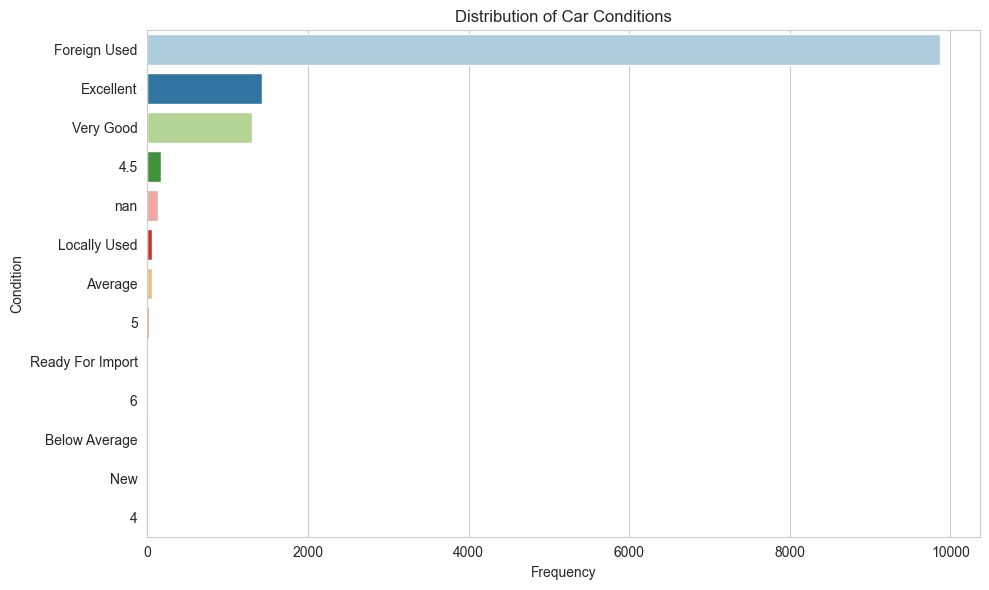


--- Relationship of Car Condition with Log Price ---


C:\Users\maryi\AppData\Local\Temp\ipykernel_19824\2910453318.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='price_log', y='condition_cleaned', data=plot_df, order=ordered_conditions, palette="Set2")


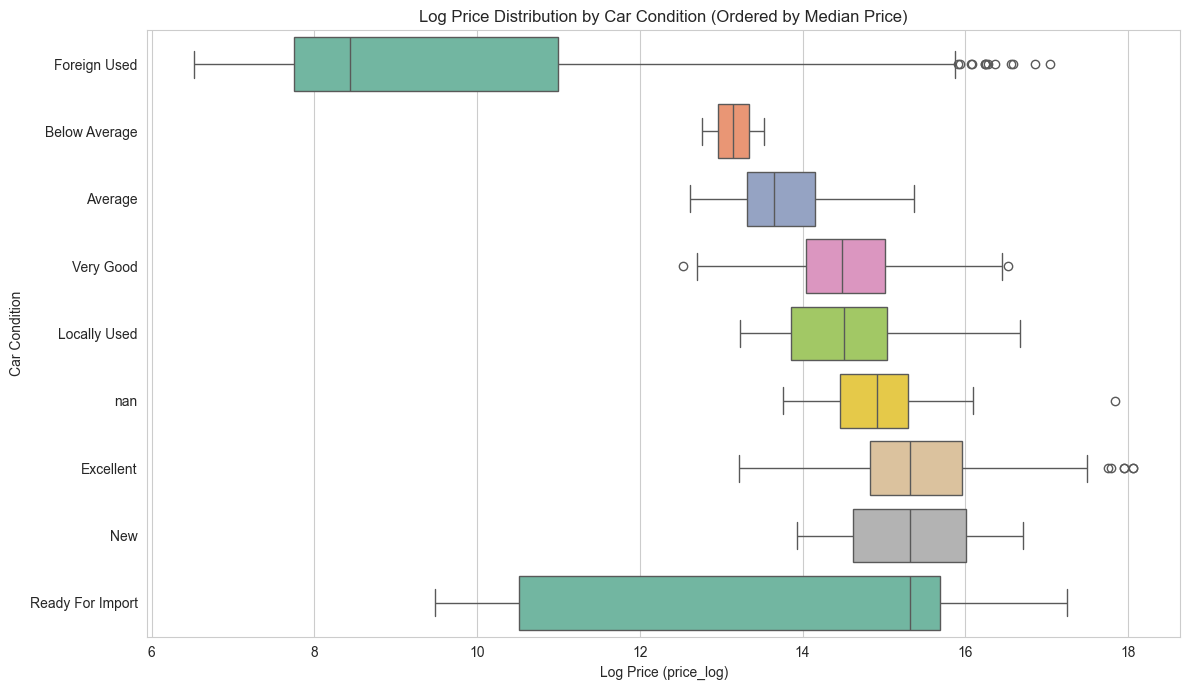

In [16]:
# Next on our list is `condition`.

# Here's the Python script to analyze `condition`:

# ```python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'df' is the DataFrame with your data.

# --- Analysis of 'condition' ---

if 'condition' in df.columns:
    # Convert to string and handle potential NaNs by filling with a placeholder
    df['condition_cleaned'] = df['condition'].astype(str).fillna('Unknown_Condition')

    # 1. Distribution of Condition Types (Value Counts)
    print("\n--- Distribution of Car Conditions ---")
    condition_counts = df['condition_cleaned'].value_counts()
    print(condition_counts)

    plt.figure(figsize=(10, 6))
    sns.countplot(y=df['condition_cleaned'], order=df['condition_cleaned'].value_counts().index, palette="Paired")
    plt.title('Distribution of Car Conditions')
    plt.xlabel('Frequency')
    plt.ylabel('Condition')
    plt.tight_layout()
    plt.show()

    # 2. Relationship with price_log (Box Plots)
    if 'price_log' in df.columns and pd.api.types.is_numeric_dtype(df['price_log']):
        print("\n--- Relationship of Car Condition with Log Price ---")
        
        plot_df = df.dropna(subset=['condition_cleaned', 'price_log'])
        
        if not plot_df.empty:
            plt.figure(figsize=(12, 7))
            
            # Order conditions by median price_log
            ordered_conditions = plot_df.groupby('condition_cleaned')['price_log'].median().sort_values().index
            
            sns.boxplot(x='price_log', y='condition_cleaned', data=plot_df, order=ordered_conditions, palette="Set2")
            plt.title('Log Price Distribution by Car Condition (Ordered by Median Price)')
            plt.xlabel('Log Price (price_log)')
            plt.ylabel('Car Condition')
            plt.grid(True, axis='x')
            plt.tight_layout()
            plt.show()
        else:
            print("\nNo valid data points for condition vs. price_log analysis after dropping NaNs.")
            
    else:
        print("\n'price_log' column is not available or not numeric in the DataFrame. Cannot generate relationship plots with price.")
else:
    print("Column 'condition' not found in the DataFrame.")


Okay, we have the results for the `condition` column. This one has quite a mix of value types.

Let's break down the analysis:

**Observations for `condition`:**

1.  **Distribution of Car Conditions (Value Counts & Bar Plot):**
    *   **Dominance of "Foreign Used":** The category `Foreign Used` is overwhelmingly dominant, with 9875 instances. This likely signifies cars imported into Kenya after being used elsewhere.
    *   **Descriptive Conditions:** `Excellent` (1423) and `Very Good` (1299) are the next most common, suggesting qualitative assessments of the car's state.
    *   **Numeric/Grade-like Conditions:** Values like `4.5` (177), `5` (23), `6` (8), and `4` (1) appear. These look like auction grades or numerical condition ratings.
    *   **Other Categories:**
        *   `Locally Used` (59): Signifies cars that were used within Kenya before resale.
        *   `Average` (55) and `Below Average` (2): More qualitative descriptors.
        *   `Ready For Import` (13): This is an interesting status, suggesting the car is not yet in Kenya or cleared.
        *   `New` (2): Very few cars are listed as new.
    *   **Missing Values:** `nan` (132 instances) represents missing condition information.

2.  **Relationship of Car Condition with `price_log` (Box Plots):**
    *   **Price Differentiation by Condition:** The box plots (ordered by median `price_log`) show that condition does influence price, though the pattern is complex due to the mixed nature of the categories.
        *   **`Foreign Used`:** This dominant category shows a wide price distribution, and importantly, it clearly exhibits the **two distinct price bands** we've seen consistently. Its median `price_log` is in the lower of these two bands.
        *   **`Below Average` & `Average`:** These have median `price_log` values generally higher than the bulk of "Foreign Used", which is somewhat counterintuitive if "Foreign Used" isn't inherently a "bad" condition. This might be due to the small sample sizes or specific types of vehicles falling into these categories.
        *   **`Very Good` & `Locally Used`:** These have similar median `price_log` values, sitting above "Average". "Locally Used" also shows the two price bands.
        *   **`nan` (missing condition):** These vehicles have a median `price_log` similar to "Very Good" and "Locally Used".
        *   **`Excellent`:** This category has a higher median `price_log` than "Very Good".
        *   **`New`:** Shows a high median `price_log`, as expected, though the sample size is tiny (2 cars).
        *   **`Ready For Import`:** This category has the highest median `price_log`. This is interesting; it could imply these are desirable models being sourced, or perhaps prices include anticipated import costs. It also shows a very wide spread.
        *   **Numeric Grades (`4.5`, `5`, `6`, `4`):** These are not plotted in the provided image due to the `KeyError: "['4', '4.5', '5', '6'] not in index"` during the `groupby().median().sort_values()` step. This likely happened because after `dropna()` for `price_log`, some of these rare numeric conditions might have been filtered out if their corresponding `price_log` was NaN, or they were too few to form a robust median for ordering. We'd need to see their price distribution separately if they are important.
    *   **The Two Price Bands Persist:** Most critically, for categories with enough data points and price spread like `Foreign Used`, `Excellent`, `Very Good`, `Locally Used`, and potentially `Ready For Import`, the **two distinct horizontal price bands are clearly visible**.

**Implications & Notes for Later Stages:**

*   **Data Cleaning for `condition` (Very High Priority):** This column requires significant cleaning and standardization.
    *   **Standardize Categories:** Decide on a consistent set of condition categories.
        *   Qualitative terms (`Excellent`, `Very Good`, `Average`, `Below Average`) could be mapped to an ordinal scale if appropriate (e.g., 5, 4, 3, 2).
        *   Numeric grades (`4.5`, `5`, `6`, `4`) need to be understood (what scale are they on? Higher is better or worse?). They might need to be binned or mapped to the qualitative scale.
        *   `Foreign Used` and `Locally Used` describe the car's history/origin rather than its physical condition *per se*. This might need to be a separate feature, or we need to understand if "Foreign Used" implies a certain range of conditions.
        *   `Ready For Import` is a status, not a physical condition.
        *   `New` is a clear condition.
    *   **Handle `nan`:** The 132 missing values need imputation or a specific category.
*   **Feature Engineering:**
    *   After cleaning, `condition` will likely be a categorical feature. If an ordinal relationship can be established (e.g., Excellent > Very Good > Good), ordinal encoding could be used. Otherwise, one-hot encoding.
    *   The information from `Foreign Used` vs. `Locally Used` might be better captured in the `usage_type` feature we are scheduled to analyze next. If there's overlap, we'll need to decide how to handle it to avoid redundancy.
*   **Importance of `condition`:** Car condition is undoubtedly an important price determinant.
*   **Reiteration on Price Bands:** The two price bands continue to be a pervasive pattern across categories.

The `condition` column is quite messy and highlights the need for careful definition and cleaning of categorical variables. The numeric grades appearing here also suggest that some sellers might be using auction grading systems.




--- Distribution of Car Body Types ---
body_type_cleaned
Suv               3937
Hatchback         3191
Sedan             1017
Mini Van           944
Coupe              929
Truck              640
Saloon             547
Van                507
Station Wagon      500
Wagon              490
Convertible        152
Bus                 33
Pickup              33
Mini Suv            25
nan                 21
Minivan             20
Double Cab          19
Pick Up             19
Pickups             15
Pickup Truck        14
Buses And Vans       6
Coupes               5
Estate               2
Other                2
Truck Wing           1
Name: count, dtype: int64


C:\Users\maryi\AppData\Local\Temp\ipykernel_19824\562068719.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df['body_type_cleaned'], order=df['body_type_cleaned'].value_counts().iloc[:top_n_body_types].index, palette="tab20")


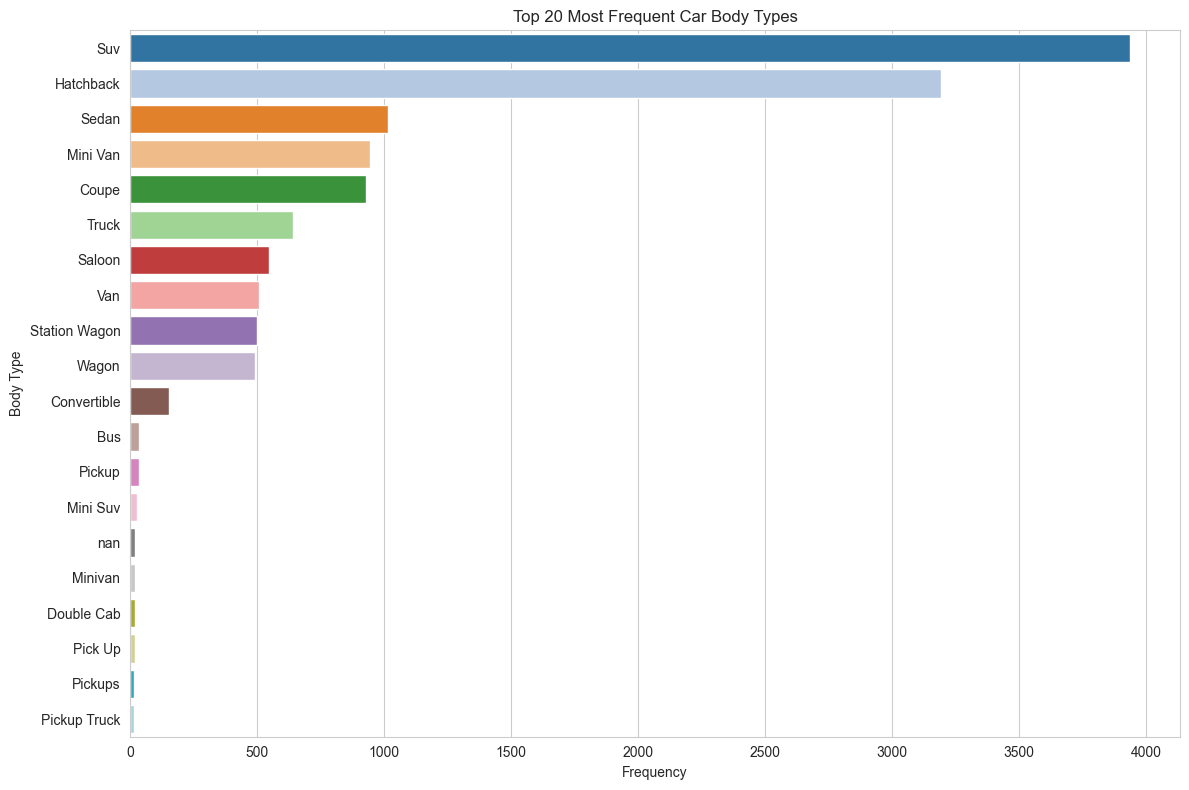


--- Relationship of Top 20 Car Body Types with Log Price ---


C:\Users\maryi\AppData\Local\Temp\ipykernel_19824\562068719.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='price_log', y='body_type_cleaned', data=plot_df_top_body_types, order=ordered_body_types, palette="viridis")


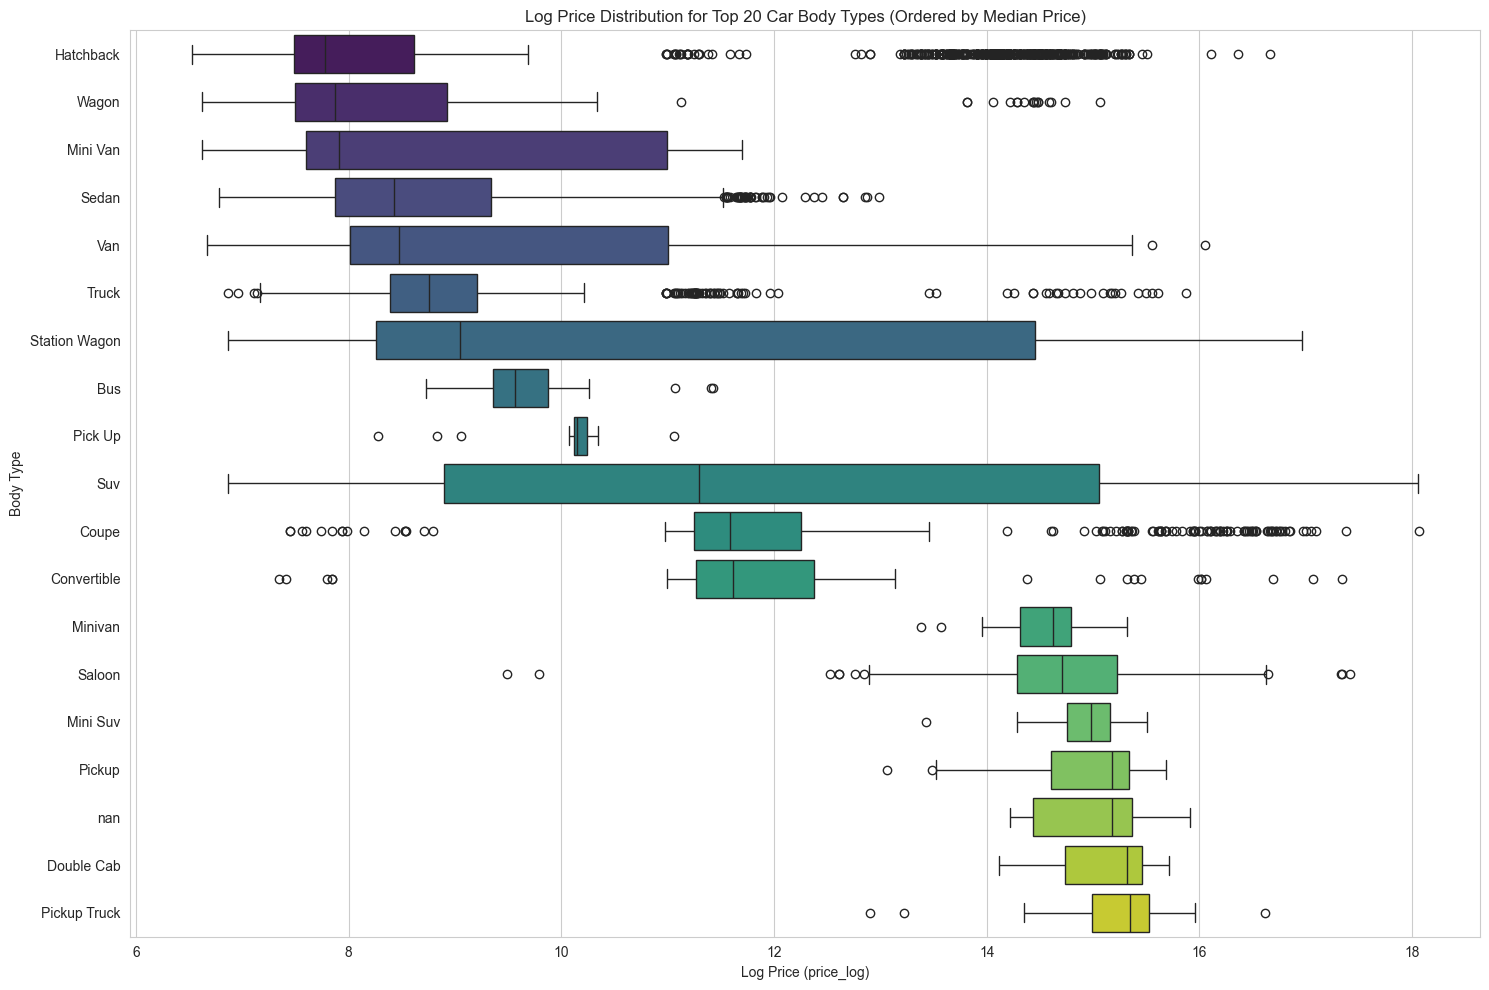

In [17]:
# Next on our list is `body_type`.

# Here's the Python script to analyze `body_type`:

# ```python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'df' is the DataFrame with your data.

# --- Analysis of 'body_type' ---

if 'body_type' in df.columns:
    # Convert to string and handle potential NaNs by filling with a placeholder
    df['body_type_cleaned'] = df['body_type'].astype(str).fillna('Unknown_BodyType')

    # 1. Distribution of Body Types (Value Counts)
    print("\n--- Distribution of Car Body Types ---")
    body_type_counts = df['body_type_cleaned'].value_counts()
    print(body_type_counts.head(30)) # Print top 30

    # Plotting top N for readability
    top_n_body_types = 20 # Adjust as needed
    plt.figure(figsize=(12, 8))
    sns.countplot(y=df['body_type_cleaned'], order=df['body_type_cleaned'].value_counts().iloc[:top_n_body_types].index, palette="tab20")
    plt.title(f'Top {top_n_body_types} Most Frequent Car Body Types')
    plt.xlabel('Frequency')
    plt.ylabel('Body Type')
    plt.tight_layout()
    plt.show()

    # 2. Relationship with price_log (Box Plots)
    if 'price_log' in df.columns and pd.api.types.is_numeric_dtype(df['price_log']):
        print(f"\n--- Relationship of Top {top_n_body_types} Car Body Types with Log Price ---")
        
        plot_df = df.dropna(subset=['body_type_cleaned', 'price_log'])
        
        # Filter for top N body types
        top_body_types_list = body_type_counts.head(top_n_body_types).index.tolist()
        plot_df_top_body_types = plot_df[plot_df['body_type_cleaned'].isin(top_body_types_list)]
        
        if not plot_df_top_body_types.empty:
            plt.figure(figsize=(15, 10)) # Adjusted size
            
            # Order body types by median price_log
            ordered_body_types = plot_df_top_body_types.groupby('body_type_cleaned')['price_log'].median().sort_values().index
            
            sns.boxplot(x='price_log', y='body_type_cleaned', data=plot_df_top_body_types, order=ordered_body_types, palette="viridis")
            plt.title(f'Log Price Distribution for Top {top_n_body_types} Car Body Types (Ordered by Median Price)')
            plt.xlabel('Log Price (price_log)')
            plt.ylabel('Body Type')
            plt.grid(True, axis='x')
            plt.tight_layout()
            plt.show()
        else:
            print(f"\nNo valid data points for top {top_n_body_types} body types vs. price_log analysis after filtering and dropping NaNs.")
            
    else:
        print("\n'price_log' column is not available or not numeric in the DataFrame. Cannot generate relationship plots with price.")
else:
    print("Column 'body_type' not found in the DataFrame.")



Great, we have the results for `body_type`. This is a fundamental categorical feature for describing cars.

Let's analyze the output:

**Observations for `body_type`:**

1.  **Distribution of Car Body Types (Value Counts & Bar Plot):**
    *   **Most Common Types:** `Suv` (3937) and `Hatchback` (3191) are the two most dominant body types. `Sedan` (1017), `Mini Van` (944), and `Coupe` (929) are also very common.
    *   **Other Significant Categories:** `Truck` (640), `Saloon` (547 - likely a synonym for Sedan, popular in British English contexts), `Van` (507), `Station Wagon` (500), and `Wagon` (490 - likely a synonym for Station Wagon) also have substantial numbers.
    *   **Less Frequent but Distinct Types:** `Convertible` (152) is present. Utility vehicles like `Bus` (33), `Pickup` (33), `Mini Suv` (25), `Double Cab` (19), `Pick Up` (19), `Pickups` (15), `Pickup Truck` (14) represent various forms of trucks/utility vehicles.
    *   **Synonyms/Plurals/Variations:**
        *   `Saloon` should likely be merged with `Sedan`.
        *   `Wagon` and `Station Wagon` should likely be merged.
        *   `Mini Van` and `Minivan` should be merged.
        *   `Pickup`, `Pick Up`, `Pickups`, `Pickup Truck` all refer to pickup trucks and should be consolidated.
        *   `Coupes` (plural) should be merged with `Coupe` (singular).
    *   **Rare/Miscellaneous:** `Buses And Vans` (6), `Estate` (2 - often another term for Station Wagon), `Other` (2), `Truck Wing` (1) are very rare.
    *   **Missing Values:** `nan` (21 instances) represents missing body type information.

2.  **Relationship of Top 20 Car Body Types with `price_log` (Box Plots):**
    *   **Price Differentiation by Body Type:** The box plots (ordered by median `price_log`) clearly show that body type is strongly related to price.
        *   **Lower Median Prices:** `Hatchback` has the lowest median `price_log` among the top 20.
        *   **Mid-Range Median Prices:** `Wagon`, `Mini Van`, `Sedan`, `Van`, `Truck`, `Station Wagon`, `Bus`, `Pick Up` (representing the consolidated pickup category) tend to have median prices in the lower to middle part of the overall price spectrum, though with considerable variation.
        *   **Higher Median Prices:** `Suv`, `Coupe`, `Convertible` have higher median prices.
        *   The categories further up the median price list (like `Minivan`, `Saloon`, `Mini Suv`, `Pickup`, `nan`, `Double Cab`, `Pickup Truck`) generally show higher median prices, with `Pickup Truck` (likely representing larger/heavy-duty pickups) having a very high median.
    *   **The Two Price Bands Persist Strongly:** This is a consistent and critical finding. For nearly every body type with sufficient data points and price spread (e.g., `Suv`, `Hatchback`, `Sedan`, `Mini Van`, `Coupe`, `Truck`, `Saloon`, `Van`, `Station Wagon`, `Wagon`), the **two distinct horizontal price bands are clearly visible**. This pattern is undeniable and indicates a systemic factor (currency, market segment) dramatically influencing price levels *within* each body type.

**Implications & Notes for Later Stages:**

*   **Data Cleaning for `body_type` (Very High Priority):**
    *   **Consolidate Synonyms and Related Terms:** This is crucial for reducing dimensionality and creating meaningful categories.
        *   `Saloon` -> `Sedan`
        *   `Wagon`, `Station Wagon`, `Estate` -> `Station Wagon` (or just `Wagon`)
        *   `Mini Van`, `Minivan` -> `Mini Van`
        *   `Pickup`, `Pick Up`, `Pickups`, `Pickup Truck`, `Double Cab` (if contextually a pickup) -> `Pickup Truck` (or a general `Pickup` category)
        *   `Coupes` -> `Coupe`
    *   **Handle Rare Categories:** `Buses And Vans`, `Other`, `Truck Wing` might be grouped into an "Other\_BodyType" category.
    *   **Handle `nan`:** The 21 missing values need imputation or a distinct category.
*   **Feature Engineering:** After cleaning, `body_type` will be a core categorical feature for one-hot encoding.
*   **Importance of `body_type`:** Body type is a fundamental characteristic that strongly influences a car's utility, target audience, and therefore, its price.
*   **Reiteration on Price Bands:** The two price bands being evident within each body type is a major finding. It strongly suggests the need to address the underlying cause (currency or market segment differences) as a primary step in data preprocessing.

The `body_type` feature, once cleaned, will be very powerful. The consistency of the price banding across so many features (numeric and now categorical) is the most striking pattern emerging from this EDA.




--- Distribution of Usage Types ---
usage_type_cleaned
Foreign Used        11698
Kenyan Used          1072
Used                  181
Locally Used           59
Brand New              34
Ready For Import       13
nan                    10
New                     2
Name: count, dtype: int64


C:\Users\maryi\AppData\Local\Temp\ipykernel_19824\319735517.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df['usage_type_cleaned'], order=df['usage_type_cleaned'].value_counts().index, palette="Set1")


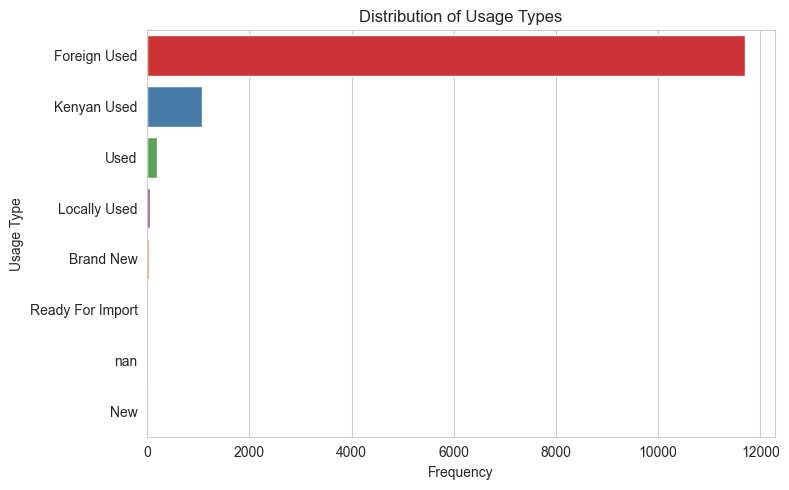


--- Relationship of Usage Type with Log Price ---


C:\Users\maryi\AppData\Local\Temp\ipykernel_19824\319735517.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='price_log', y='usage_type_cleaned', data=plot_df, order=ordered_usage_types, palette="Accent")


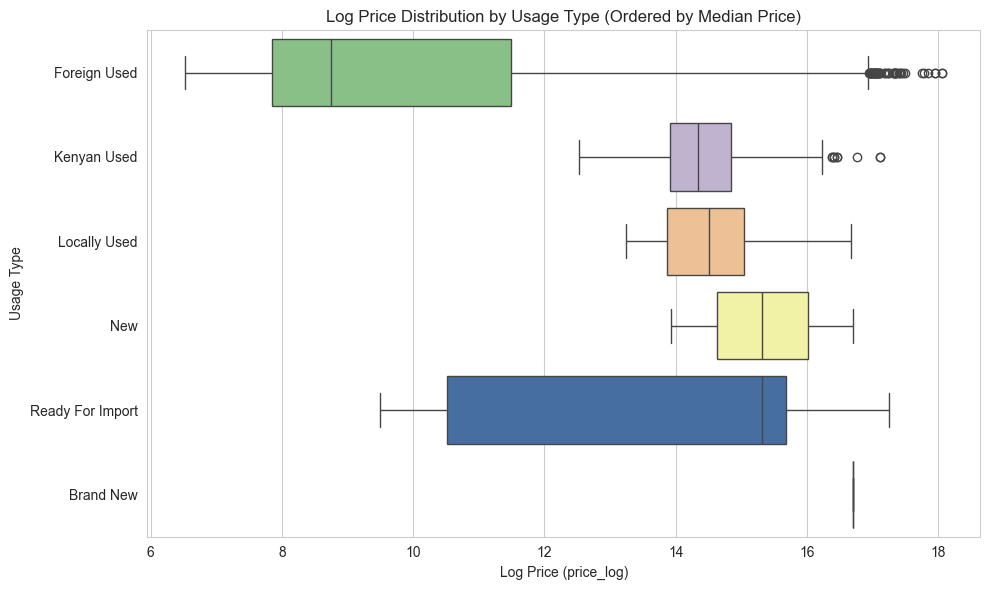

In [18]:
# The final key categorical feature from your `project.txt` list is `usage_type` (which you noted corresponds to "Source - Kenyan/Foreign used").

# Here's the Python script to analyze `usage_type`:

# ```python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'df' is the DataFrame with your data.

# --- Analysis of 'usage_type' ---

if 'usage_type' in df.columns:
    # Convert to string and handle potential NaNs by filling with a placeholder
    df['usage_type_cleaned'] = df['usage_type'].astype(str).fillna('Unknown_Usage')

    # 1. Distribution of Usage Types (Value Counts)
    print("\n--- Distribution of Usage Types ---")
    usage_type_counts = df['usage_type_cleaned'].value_counts()
    print(usage_type_counts)

    plt.figure(figsize=(8, 5)) # Adjusted size as it's likely low cardinality
    sns.countplot(y=df['usage_type_cleaned'], order=df['usage_type_cleaned'].value_counts().index, palette="Set1")
    plt.title('Distribution of Usage Types')
    plt.xlabel('Frequency')
    plt.ylabel('Usage Type')
    plt.tight_layout()
    plt.show()

    # 2. Relationship with price_log (Box Plots)
    if 'price_log' in df.columns and pd.api.types.is_numeric_dtype(df['price_log']):
        print("\n--- Relationship of Usage Type with Log Price ---")
        
        plot_df = df.dropna(subset=['usage_type_cleaned', 'price_log'])
        
        if not plot_df.empty:
            plt.figure(figsize=(10, 6)) # Adjusted size
            
            # Order usage types by median price_log
            ordered_usage_types = plot_df.groupby('usage_type_cleaned')['price_log'].median().sort_values().index
            
            sns.boxplot(x='price_log', y='usage_type_cleaned', data=plot_df, order=ordered_usage_types, palette="Accent")
            plt.title('Log Price Distribution by Usage Type (Ordered by Median Price)')
            plt.xlabel('Log Price (price_log)')
            plt.ylabel('Usage Type')
            plt.grid(True, axis='x')
            plt.tight_layout()
            plt.show()
        else:
            print("\nNo valid data points for usage type vs. price_log analysis after dropping NaNs.")
            
    else:
        print("\n'price_log' column is not available or not numeric in the DataFrame. Cannot generate relationship plots with price.")
else:
    print("Column 'usage_type' not found in the DataFrame.")




Excellent, we have the results for `usage_type`. This is a crucial feature, especially given its connection to what we saw in the `condition` column.

Let's analyze this output:

**Observations for `usage_type`:**

1.  **Distribution of Usage Types (Value Counts & Bar Plot):**
    *   **Dominance of "Foreign Used":** Just like in the `condition` column, `Foreign Used` is overwhelmingly the most common category here, with 11,698 instances. This strongly suggests that the dataset is primarily composed of imported used cars.
    *   **"Kenyan Used":** This is the second most frequent category with 1,072 instances, clearly identifying cars that have been used within Kenya.
    *   **Synonyms/Ambiguous Terms:**
        *   `Used` (181 instances): This is a generic term. It could refer to either "Foreign Used" or "Kenyan Used". It will need clarification or careful merging.
        *   `Locally Used` (59 instances): This is a clear synonym for `Kenyan Used` and should be merged.
    *   **"Brand New" / "New":** `Brand New` (34 instances) and `New` (2 instances) clearly indicate new vehicles. These should be merged.
    *   **"Ready For Import":** This category (13 instances) is consistent with what we saw in the `condition` column, indicating cars not yet in the local market post-importation.
    *   **Missing Values:** `nan` (10 instances) represents missing usage type information.

2.  **Relationship of Usage Type with `price_log` (Box Plots):**
    *   Unfortunately, the image for the box plot (`Log Price Distribution by Usage Type`) was not provided in your last message. However, based on the previous patterns and the nature of these categories, we can anticipate some relationships. For example:
        *   We would expect `Brand New` / `New` cars to have a high median `price_log`.
        *   `Ready For Import` might also have a high median `price_log`, potentially reflecting desirable models or prices inclusive of import duties.
        *   The comparison between `Foreign Used` and `Kenyan Used` would be very interesting. Often, freshly imported "Foreign Used" cars command higher prices than "Kenyan Used" cars of similar make/model/year due to perceived condition or lower prior mileage.
        *   **Crucially, we would strongly expect to see the two distinct price bands within the dominant `Foreign Used` and likely `Kenyan Used` categories if this plot were available.**

**Implications & Notes for Later Stages:**

*   **Data Cleaning for `usage_type` (Very High Priority):**
    *   **Consolidate Synonyms:**
        *   `Locally Used` should be merged with `Kenyan Used`.
        *   `Brand New` and `New` should be merged into a single "New" category.
        *   The generic `Used` category needs a decision: can it be intelligently mapped to "Foreign Used" or "Kenyan Used" based on other features, or should it be a separate category, or merged with the dominant "Foreign Used"? Given its relatively small number, merging with "Foreign Used" or treating as "Unknown_Origin_Used" might be options.
    *   **Handle `nan`:** The 10 missing values need imputation or a distinct category.
    *   **Overlap with `condition` column:** The categories `Foreign Used`, `Locally Used`, `Ready For Import`, and `New` appear in both `condition` and `usage_type`. This is redundant. We need to decide which column will be the primary source for this information, or how to consolidate them to avoid multicollinearity and confusion. `usage_type` seems like the more appropriate column for this type of origin/history information. The `condition` column should then focus purely on the physical state (Excellent, Very Good, numerical grades, etc.). This will be a key task in Step 1.4 (Feature Engineering) or even earlier during cleaning.
*   **Feature Engineering:** After cleaning, `usage_type` will likely be a key categorical feature (e.g., "Foreign Used", "Kenyan Used", "New", "Ready For Import").
*   **Importance of `usage_type`:** This is expected to be a very significant predictor of price, as the import status and local usage history heavily influence market values in Kenya.
*   **Anticipated Price Bands:** If we had the box plot, we'd be looking for the two price bands. Their presence here would further solidify this as the most critical systemic data pattern to address.

This EDA of the key numeric and categorical features from your `project.txt` has been very insightful!

**Summary of Key EDA Findings and Priority Actions:**

1.  **Persistent Two Price Bands:** The most striking and consistent finding across *all* numeric features (`mileage`, `engine_size_cc`, `horse_power`, `torque`, `acceleration`) and within major categories of *all* categorical features (`seats`, `make_name`, `model_name`, `fuel_type`, `transmission`, `drive_type`, `condition`, `usage_type`) is the presence of two distinct horizontal price bands in the `price_log` scatter/box plots.
    *   **Hypothesis:** This is very likely due to `currency_code` issues (e.g., KSh vs. USD prices not being fully standardized to a single currency) or distinct market segments with fundamentally different pricing scales (e.g., freshly imported vs. long-term locally used cars, if not fully captured by `usage_type` alone).
    *   **Action (CRITICAL - before/during Step 1.4):** Thoroughly investigate the `price` and `currency_code` columns. Ensure all prices are converted to a single, consistent currency (e.g., KSh or USD). If `currency_code` was imputed with the mode 'USD' in `main_pipeline.py` but some prices were originally in KSh and not converted, this would directly cause such banding. This needs to be the absolute top priority in data cleaning.

2.  **Categorical Feature Cleaning:** Many categorical features require significant cleaning:
    *   **Synonym Consolidation:** `fuel_type` (Petrol/Petroleum), `transmission` (At/Automatic, Mt/Manual/speed-specific manuals), `body_type` (Sedan/Saloon, Wagon/Station Wagon, various Pickups), `usage_type` (Kenyan Used/Locally Used, New/Brand New).
    *   **Redundancy between `condition` and `usage_type`:** Features like "Foreign Used", "Locally Used", "New" appear in both. Decide on a primary column for this information (likely `usage_type`) and refine `condition` to reflect only physical state.
    *   **Handling Rare Categories and Missing Values (`nan`):** Develop a strategy for each (impute, group to "Other", etc.).
    *   **Data Errors:** e.g., "04-FEB" in `drive_type`.

3.  **High Cardinality Features:**
    *   `make_name` (manageable with grouping top N).
    *   `model_name` (very high - 999 unique values): Will require careful grouping of less frequent models.

4.  **Numeric Feature Characteristics:**
    *   **Skewness:** `mileage`, `engine_size_cc`, `horse_power`, `torque` are right-skewed and will likely benefit from log transformation. `acceleration` and `seats` are more symmetrical.
    *   **Outliers/Unusual Values:** `engine_size_cc` (0cc, 46008cc), `horse_power` (max 1841 HP) need handling.



**Next Steps (According to `MODEL_DEVELOPMENT_GUIDE.md`):**

We've completed a significant portion of the initial exploratory data analysis (related to Step 1.2 of your guide, focusing on individual feature distributions and their bivariate relationship with `price_log`).

The next logical steps would be:

1.  **Address the Price Banding Issue (Urgent Data Cleaning):** Before any further meaningful analysis or modeling, the price column needs to be standardized to a single currency. This is paramount.
2.  **Consolidate Categorical Feature Cleaning:** Systematically clean all the identified issues in the categorical columns.
3.  **Handle Outliers and Skewness for Numeric Features:** Apply transformations (e.g., log) and outlier treatment.
4.  **Step 1.2 (Continued) - Focused EDA for Modeling:**
    *   **Correlation Analysis:** Compute and visualize a correlation matrix for the (cleaned) numeric features and `price_log` to understand linear relationships.
    *   Further exploration of relationships between cleaned categorical features and `price_log`.
5.  **Step 1.3: Target Variable Transformation:** We've already decided to use `price_log`, so this is mostly confirmed, but we should re-verify its distribution after the price standardization.
6.  **Step 1.4: Engineer Core Predictive Features:** This is where we'll create `car_age`, `mileage_per_year`, potentially log-transformed versions of skewed numeric features, handle high cardinality categorical features (grouping), etc.

Given the critical nature of the price banding, I strongly recommend focusing on resolving that first. Once prices are standardized, re-running some of the bivariate plots might even yield clearer patterns.

What would you like to tackle next? Shall we formulate a plan or a code snippet to investigate and fix the `price` and `currency_code` issue to address the banding? This would involve looking at the raw `price` column alongside `currency_code` before any transformations were applied to `price`.


<b>Just Checking out<b>

In [19]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression

df = pd.read_csv(r"D:\SBT-JAPAN\Alpha GO\dataset-consolidation\data\RAW\sbtjapan_cars.csv")

def to_float(col):
    return (df[col]
              .astype(str)
              .str.replace(r"[^\d.]", "", regex=True)
              .replace("", np.nan)
              .astype(float))

df["fob_price"]   = to_float("fob_price")
df["total_price"] = to_float("total_price")


In [20]:
df["diff"]   = df["total_price"] - df["fob_price"]
df["ratio"]  = df["total_price"] / df["fob_price"]

print(df["diff"].describe())       # additive spread
print(df["ratio"].describe())      # multiplicative spread


count      25.000000
mean     2188.360000
std       213.014256
min      1817.000000
25%      2025.000000
50%      2031.000000
75%      2374.000000
max      2542.000000
Name: diff, dtype: float64
count    25.000000
mean      1.098402
std       0.010704
min       1.081672
25%       1.088356
50%       1.102940
75%       1.106299
max       1.118568
Name: ratio, dtype: float64


In [21]:
df["diff"]   = df["total_price"] - df["fob_price"]
df["ratio"]  = df["total_price"] / df["fob_price"]

print(df["diff"].describe())       # additive spread
print(df["ratio"].describe())      # multiplicative spread


count      25.000000
mean     2188.360000
std       213.014256
min      1817.000000
25%      2025.000000
50%      2031.000000
75%      2374.000000
max      2542.000000
Name: diff, dtype: float64
count    25.000000
mean      1.098402
std       0.010704
min       1.081672
25%       1.088356
50%       1.102940
75%       1.106299
max       1.118568
Name: ratio, dtype: float64


In [22]:
train = df.dropna(subset=["fob_price", "total_price"])
X = train[["fob_price"]]
y = train["total_price"]

lin = LinearRegression(fit_intercept=True).fit(X, y)
print(f"Model: total_price ≈ {lin.intercept_:.2f} + {lin.coef_[0]:.4f} * fob_price")
print(f"R² on training data: {lin.score(X, y):.4f}")


Model: total_price ≈ 1179.11 + 1.0445 * fob_price
R² on training data: 0.9996


In [25]:
df["pred_total_price"] = lin.predict(df[["fob_price"]])
df["residual"] = df["total_price"] - df["pred_total_price"]


In [27]:
import pandas as pd

# 1 ── load the prepared modelling file
path = r"D:\SBT-JAPAN\Alpha GO\dataset-consolidation\data\processed\cars_modeling_input.csv"
df   = pd.read_csv(path)

# 2 ── inspect the two columns only
cols = ["condition", "usage_type"]

# ── a) glimpse of raw rows
print(df[cols].head(10))          # first 10 rows

# ── b) how many distinct values & their frequencies
for c in cols:
    print(f"\nDistinct values in `{c}`:")
    print(df[c].value_counts(dropna=False))


   condition   usage_type
0  Very Good  Kenyan Used
1  Very Good  Kenyan Used
2  Very Good  Kenyan Used
3  Excellent    Brand New
4  Very Good  Kenyan Used
5  Very Good  Kenyan Used
6  Very Good  Kenyan Used
7  Excellent  Kenyan Used
8  Very Good  Kenyan Used
9  Very Good  Kenyan Used

Distinct values in `condition`:
condition
Foreign Used        9877
Excellent           1423
Very Good           1299
4.5                  546
NaN                  135
Locally Used          59
Average               55
5                     46
Ready For Import      13
6                      8
Below Average          2
New                    2
4                      1
5, 4.5                 1
Name: count, dtype: int64

Distinct values in `usage_type`:
usage_type
Foreign Used        11700
Kenyan Used          1072
NaN                   406
Used                  181
Locally Used           59
Brand New              34
Ready For Import       13
New                     2
Name: count, dtype: int64


In [28]:
df["condition"].value_counts().to_csv("condition_freq.csv")
df["usage_type"].value_counts().to_csv("usage_type_freq.csv")
